In [6]:
# librairies de gestion des chemins d'accès des fichiers/dossiers
import os
from pathlib import Path
import json
import pickle
import timeit

# librairies de manipulation des données tabulaires et itérateurs
import pandas as pd
import numpy as np
from collections import Counter
import itertools

# librairies de manipulation des données textuelles
# import nltk
# import gensim
# import re
# import string
# from bs4 import BeautifulSoup
# import contractions

# librairies de fonctionction statistiques
from scipy import stats

# librairies de visualtion
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
from tqdm.notebook import trange, tqdm

# module de chargement de fonctions utiles pour l'ACP
import ACP_functions

In [2]:
# paramètres d'affichage général

pd.set_option('display.max_rows', 100)

# plt.rcParams['figure.figsize'] = [15, 8]

In [3]:
# désactivation de l'affichage des WARNING, INFO et DEBUG

import logging
logging.disable(logging.WARNING) 

In [4]:
# contrôle de la reproductibilité des résultats aléatoires

SEED = 49

In [5]:
# fonction de sauvegarde des images

IMAGES_PATH = Path() / "img" / "test"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"tests - {fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

In [6]:
# fonctions de sauvegarde et chargement des résultats intermédiaires qui ne sont pas des dataframes

INTER_RESULTS_PATH = Path() / "datasets" / "tests" / "intermediary_results"
INTER_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

def save_pickle(results, file_name):
    file_path = INTER_RESULTS_PATH / f"{file_name}.pkl"
    filehandler = open(file_path,"wb")
    pickle.dump(results, filehandler)
    filehandler.close()
    print(f"Fichier enregistré sous le nom '{file_name}' ")

def load_pickle(file_name):
    file_path = INTER_RESULTS_PATH / f"{file_name}.pkl"
    file = open(file_path,'rb')
    globals()[file_name] = pickle.load(file)
    file.close()
    print(f"Variable créée sous le nom '{file_name}' ")

In [2]:
# %%time
# raw_queries = pd.read_pickle('datasets/raw_queries.pkl')

In [3]:
# %%time
# df = raw_queries.copy()
# df.sort_values('creation_date', inplace=True)
# df.reset_index(drop=True, inplace=True)

# Pré-traitement des données et feature engineering

Avant d'aborder la problématique du projet de manière non supervisée puis supervisée, nous allons réaliser plusieurs pré-traitements des données qui nous serviront à comparer les résultats avec chacun des approches, puis nous comparerons les résultats obtenus dans les meilleures configurations de chaque approche et nous déciderons du modèle final que nous déploierons sous forme d'API afin qu'il puisse être utilisé par les utilisateurs novices de **StackOverFlow**.

**NB** : Dans un premier temps, nous allons conserver tous les posts de notre jeu de données, et nous verrons dans un second temps si nous pourrons améliorer les performances de nos modèles en ne conservant que les posts avec un certain niveau de score ou nombre de réponses ou de vues ou une combinaison de tous ces critères à la fois.

## Conservation des paragraphes des corps des posts uniquement

In [5]:
def keep_text_from_tags(html, tags=['p']):
    """
        But :
        
        Analyse le contenu HTML et extrait le contenu textuel des balises passées en argument.
        
        Arguments :
        
        htmt : document au format HTML.
        tags : list des balises dont l'on veut extraire le contenu textuel.
        
        Valeur retournée :
        
        Une chaîne de caractère issue de la jointure des contenus textuels des différentes balises analysées.
    """
    
    soup = BeautifulSoup(html, "lxml")
    
    list_text = list()
    
    for tag in tags:
        list_text.extend([x.get_text() for x in soup.find_all(tag)])
 
    
    return ' '.join(list_text)

In [6]:
# df_datas['body'] = df_datas['body'].apply(keep_text_from_tags)

## Nettoyage du texte

Cette étape est constituée des tâches suivantes :

   1. **Formattage** : Passsage en minuscule de tout le texte (dans un second temps, nous pourrons conserver la trace des mots comprennant des majuscules pour voir si cela améliore les performances de nos modèles)
   2. **Othographe** : Corriger les fautes d'orthographes ainsi que les abréviations argotiques
   3. **Suppression du bruit** : Suppression des caractères spéciaux, ponctuations, caractères non-ASCII, URL, balises HTML...
   4. **Filtre syntaxique** : Tri des mots et conservation des noms uniquement (POS_tagging)
   

In [7]:
# 1. FORMATTAGE

# df_datas = df_datas.apply(lambda x: x.str.lower())

In [8]:
# 2. ORTHOGRAPHE

# df_datas['title'] = df_datas['title'].apply(lambda x: contractions.fix(x))
# df_datas['body'] = df_datas['body'].apply(lambda x: contractions.fix(x))

In [9]:
# df_contractions = df_datas.merge(df_target, right_index=True, left_index=True)
# df_contractions.to_csv('datasets/tests/df_contractions.csv', index=False)

In [40]:
df_contractions = pd.read_csv("datasets/tests/df_contractions.csv")
df_datas = df_contractions.copy().dropna()

In [41]:
def remove_punct(text):
    """"
        But :
        
        Supprimer les caractères spéciaux ainsi que la ponctuation, les caractères non-ASCII à l'exception de c++ et c#.
        
        Arguments :
        
        text : texte à nettoyer.
        
        Valeur retournée :
        
        Texte nettoyé.
    """
    
    pattern_1 = re.compile(r'[^\w]|[\d_]')
    pattern_2 = re.compile(r'[^\x00-\x7f]')
    
    exceptions = ['c++', 'c#']
    
    text_splitted = text.split()
    
    try:
        text_splitted = [re.sub(pattern_1,"", text) for text in text_splitted if not text in exceptions]
        text_splitted = [re.sub(pattern_2,"", text) for text in text_splitted]
    except TypeError:
        return text
    
    return " ".join(text_splitted)

In [42]:
df_datas['title'] = df_datas['title'].apply(remove_punct)

In [43]:
df_datas['body'] = df_datas['body'].apply(remove_punct)

In [44]:
df_datas

,title,body,tags
0,modifying bonita process instance after started,is it possible to change the processinstance c...,bonita
1,what does elevation in drawshadow do exactly,i know that flutters canvasdrawshadow translat...,c++|flutter|dart|skia
2,how to use a trait object that contains a meth...,what is the correct way to use a trait object ...,rust
3,a way for users to store selections as inputs ...,i am trying to create a way in which a user ca...,r|shiny|shiny-server|shiny-reactivity|shinyapps
4,how to open downloaded photo using gallery app...,i am facing a problem cannot figure out how to...,react-native|linker|expo|gallery
...,...,...,...
999995,can you do a pull in a mongodb bulk write whic...,version mongodb v i have the following mongod...,mongodb
999996,non static method cannot be called statically,i am so lost with how to get this working all ...,php|laravel
999997,sorting oslistdirs arbitrary order for desired...,image of txt files in folder i currently posse...,python|list|sorting
999998,big o complexity of nested loop,what could be the big o of this code i thought...,big-o


On peut observer que certains tags contiennent plusieurs mentions d'un même sujet, mais associé à chaque fois à un autre (voir exemple ci-après) : dans ces cas là, nous ne souhaitons garder que les tags principaux.

In [53]:
test = 	'r|shiny|shiny-server|shiny-reactivity|shinyapps'
{re.split(r'[^\w]|[\d_]',x)[0] if (not x in ['c++', 'c#']) else x for x in test.split('|')}

{'r', 'shiny', 'shinyapps'}

In [77]:
def split_tags(tags):
    """
        But :
        
            Splitter la chaîne de caractères autour de l'élément '|', supprimer les caractères spéciaux ainsi que la ponctuation, 
            les caractères non-ASCII, à l'exception de c++ et c#.
        
        Arguments :
        
            tags : tag à nettoyer.
        
        Valeur retournée :
        
            Liste de tags nettoyés.
    """
    
    pattern_1 = re.compile(r'[^\w]|[\d_]')
    pattern_2 = re.compile(r'[^\x00-\x7f]')
    
    exceptions = ['c++', 'c#']
    
    tags_splitted = tags.split('|')
    
    try:
        tags_splitted = [re.sub(pattern_2,"", tag) for tag in tags_splitted]
        tags_splitted = [re.split(pattern_1, tag)[0] if (not tag in ['c++', 'c#']) else tag for tag in tags_splitted]
        tags_splitted = sorted({tag for tag in tags_splitted if tag != ''})
    except TypeError:
        return tags
    
    return tags_splitted

In [80]:
for tags in df_datas['tags'].sample(20).values :
    print(f"original : {tags} \ntransformed :{split_tags(tags)}\n")

original : php|function|codeigniter|count|codeigniter-4 
transformed :['codeigniter', 'count', 'function', 'php']

original : docker|caching|npm|docker-build 
transformed :['caching', 'docker', 'npm']

original : mysql|sql|date|datetime|time 
transformed :['date', 'datetime', 'mysql', 'sql', 'time']

original : javascript|stripe-payments|payment-gateway 
transformed :['javascript', 'payment', 'stripe']

original : snowflake-cloud-data-platform|dbt 
transformed :['dbt', 'snowflake']

original : c++|mingw|libcurl 
transformed :['c++', 'libcurl', 'mingw']

original : reactjs|typescript|react-native 
transformed :['react', 'reactjs', 'typescript']

original : azure|azure-devops|azure-pipelines 
transformed :['azure']

original : python|numpy 
transformed :['numpy', 'python']

original : rust|pattern-matching 
transformed :['pattern', 'rust']

original : flutter|dart|flutter-dependencies 
transformed :['dart', 'flutter']

original : github|google-cloud-platform|google-cloud-functions|terraf

Le résultat est plutôt satisfaisant dans l'ensemble, mais il faudrait construire un dictionnaire plus exhaustif pour que la fonction soit optimale.

Par exemple, il est dommage de se retrouver avec 'deep' seulement lorsque l'on a 'deep-learning', ou 'machine' lorsque l'on a 'machine-learning' ou encore 'computer' à la place de 'computer-vision', 'visual' à la place de 'visual-studio'...

Cela pourrait amener nos modèles à confondre le résultat de notre fonction avec des tags unitaires saisis par l'utilisateur et qui n'ont rien à voir (un post sur le sujet de front-end et utilisant le tag 'visual' n'a rien à voir avec un post qui demande de l'aide sur une fonctionnalité avancée de 'visual-studio').

In [81]:
df_datas['tags'] = df_datas['tags'].apply(split_tags)
df_datas

,title,body,tags
0,modifying bonita process instance after started,is it possible to change the processinstance c...,[bonita]
1,what does elevation in drawshadow do exactly,i know that flutters canvasdrawshadow translat...,"[c++, dart, flutter, skia]"
2,how to use a trait object that contains a meth...,what is the correct way to use a trait object ...,[rust]
3,a way for users to store selections as inputs ...,i am trying to create a way in which a user ca...,"[r, shiny, shinyapps]"
4,how to open downloaded photo using gallery app...,i am facing a problem cannot figure out how to...,"[expo, gallery, linker, react]"
...,...,...,...
999995,can you do a pull in a mongodb bulk write whic...,version mongodb v i have the following mongod...,[mongodb]
999996,non static method cannot be called statically,i am so lost with how to get this working all ...,"[laravel, php]"
999997,sorting oslistdirs arbitrary order for desired...,image of txt files in folder i currently posse...,"[list, python, sorting]"
999998,big o complexity of nested loop,what could be the big o of this code i thought...,[big]


In [86]:
# Tokenization
from nltk.tokenize import word_tokenize

df_datas['tokens'] = df_datas.apply(lambda x: x['title'] + x['body'], axis=1)

df_datas['tokens'] = df_datas['tokens'].apply(word_tokenize)

df_datas

,title,body,tags,tokens
0,modifying bonita process instance after started,is it possible to change the processinstance c...,[bonita],"[modifying, bonita, process, instance, after, ..."
1,what does elevation in drawshadow do exactly,i know that flutters canvasdrawshadow translat...,"[c++, dart, flutter, skia]","[what, does, elevation, in, drawshadow, do, ex..."
2,how to use a trait object that contains a meth...,what is the correct way to use a trait object ...,[rust],"[how, to, use, a, trait, object, that, contain..."
3,a way for users to store selections as inputs ...,i am trying to create a way in which a user ca...,"[r, shiny, shinyapps]","[a, way, for, users, to, store, selections, as..."
4,how to open downloaded photo using gallery app...,i am facing a problem cannot figure out how to...,"[expo, gallery, linker, react]","[how, to, open, downloaded, photo, using, gall..."
...,...,...,...,...
999995,can you do a pull in a mongodb bulk write whic...,version mongodb v i have the following mongod...,[mongodb],"[can, you, do, a, pull, in, a, mongodb, bulk, ..."
999996,non static method cannot be called statically,i am so lost with how to get this working all ...,"[laravel, php]","[non, static, method, can, not, be, called, st..."
999997,sorting oslistdirs arbitrary order for desired...,image of txt files in folder i currently posse...,"[list, python, sorting]","[sorting, oslistdirs, arbitrary, order, for, d..."
999998,big o complexity of nested loop,what could be the big o of this code i thought...,[big],"[big, o, complexity, of, nested, loopwhat, cou..."


In [17]:
# df_datas.to_pickle("datasets/tests/df_datas.pkl")
df_datas = pd.read_pickle("datasets/tests/df_datas.pkl")

In [18]:
df = df_datas[['tokens', 'tags']].copy()

In [19]:
# nous retirons les stopwords usuels en anglais

from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

In [20]:
df['tags'] = df['tags'].apply(lambda x: [word for word in x if not word in stop])

In [21]:
df['tokens'] = df['tokens'].apply(lambda x: {word for word in x if not word in stop})

In [97]:
df

,tokens,tags
0,"{bonita, processinstance, possible, instance, ...",[bonita]
1,"{see, additionally, completely, ensure, affect...","[c++, dart, flutter, skia]"
2,"{correct, trait, resolve, bar, either, underst...",[rust]
3,"{create, many, steps, want, usei, app, name, u...","[r, shiny, shinyapps]"
4,"{find, want, external, app, using, shows, phot...","[expo, gallery, linker, react]"
...,...,...
999995,"{update, single, bulkwrite, array, script, run...",[mongodb]
999996,"{staticallyi, static, lost, want, looking, app...","[laravel, php]"
999997,"{find, sort, capture, best, using, folder, alp...","[list, python, sorting]"
999998,"{n, like, big, also, loopwhat, looks, code, ne...",[big]


In [22]:
# nous supprimmons les mots dont la longueur est inférieure ou égale à 3 caractères à moins qu'ils constituent un tag

# nous récupérons la liste des tags dont la longueur est inférieure ou égale à 3 caractères
dict_pos_tags = json.load(open('dictionnaries/dict_position_tags.json'))
list_short_tags = [tags for tags in dict_pos_tags.keys() if len(tags) <=3]

In [23]:
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if (len(word)>3 or word in list_short_tags)])

In [106]:
tokenized_docs = df['tags'].values
tags = Counter()
for token in tokenized_docs:
    tags.update(token)

In [109]:
len(tags)

20889

Nous sommes passés de **39139** à près de la moitié à ce stade du nettoyage des données.

In [ ]:
bag_of_tags = ' '.join([' '.join(x) for x in df['tags'].to_list()])

wordcloud = WordCloud(width=2048, height=2048, background_color="white", max_words=50).generate(bag_of_tags)

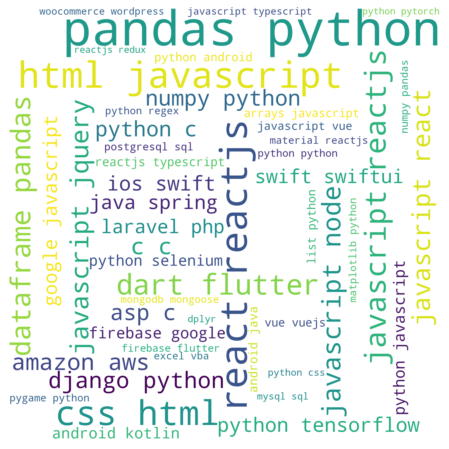

In [112]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [26]:
# 4. Filtre syntaxique

from nltk.corpus import wordnet
from nltk.corpus import brown

wordnet_map = {"N":wordnet.NOUN}

train_sents = brown.tagged_sents(categories='learned')

t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

Étant donné le caractère technologique et technique des mots de notre corpus, nous décidons d'entraîner un tagger sur les documents de la catégorie *LEARNED* du corpus **Brown**, qui regroupe 80 textes dans les domaines des sciences, de la technologie et de l'ingénirie : nous espérons ainsi créer un tagger qui sera mieux à même de reconnaître correctement la nature des mots de notre corpus.

In [27]:
def pos_tag(tokens):
    """
        But :
        
            Filtrer les tokens de type "nom"
        
        Arguments :
        
            tokens : tokens à analyser.
        
        Valeur retournée :
        
            Liste des tokens de type "nom"
    """
    pos_tagged_tokens = t2.tag(tokens)
    
    nouns = [word for (word, pos_tag) in pos_tagged_tokens if (pos_tag[0] in wordnet_map.keys())]
    
    return nouns

In [28]:
df['tokens'] = df['tokens'].apply(pos_tag)

In [29]:
df.to_pickle("datasets/tests/df_datas_nouns.pkl")

Toujours dans un soucis de diminuer la taille de notre vocabulaire, nous allons maintenant conserver uniquement les lemmes des tokens de notre corpus :

In [159]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [160]:
df

,tokens,tags
0,"[bonita, processinstance, instance, process, d...",[bonita]
1,"[additionally, information, elevation, impleme...","[c++, dart, flutter, skia]"
2,"[trait, error, circumstance, way, code, object...",[rust]
3,"[step, usei, name, panel, clicked, checkboxes,...","[r, shiny, shinyapps]"
4,"[photo, screen, google, default, problem, phot...","[expo, gallery, linker, react]"
...,...,...
999995,"[update, bulkwrite, array, script, example, hi...",[mongodb]
999996,"[staticallyi, approach, calculation, rename, b...","[laravel, php]"
999997,"[sort, capture, folder, outputimage, oslistdir...","[list, python, sorting]"
999998,"[n, loopwhat, code, nested, complexity]",[big]


A ce stade, vérifions si notre nettoyage de données à généré des valeurs vides dans nos colonnes :

In [163]:
df[df['tags'].map(len)==0]

,tokens,tags
60,"[htaccessi, url, help, format, htaccess, redir...",[]
855,"[parameter, pedestrian, route, google, matrix,...",[]
1217,"[section, releasedebug, configured, filesdotne...",[]
1758,"[lib, trick, system, reference, mean, netstand...",[]
3684,"[description, memory, javascript, image, page,...",[]
...,...,...
985273,"[caching, image, wondering, image, folderi, fo...",[]
993425,"[ajax, chart, graph, channelactivecallsgavgtim...",[]
994752,"[image, httpscodesandboxiosintelligentfasteowu...",[]
998388,"[redirection, rule, errori, rewrite, redirecte...",[]


In [168]:
df_contractions.loc[df[df['tags'].map(len)==0].index, 'tags'].unique()

array(['.htaccess', 'here-api', '.net-core', '.net-core|.net-standard',
       'd3.js', '.net|.net-core', 'here-api|here-maps-rest', '.net',
       'd3.js|d3fc', 'd3fc',
       '.net-standard|.net-core-3.1|.net-standard-2.1', 'or-tools',
       '.net-core|.net-assembly', 'in-app-purchase', '5g', 'can-bus',
       'after-effects', '.net|.net-standard|.net-standard-2.0',
       '.net-traceprocessing', 'd3.js|d3-force-directed',
       '.net-core|.net-core-configuration', '2sxc', 'for-loop', '6502',
       '.net|.net-framework-version', 'here-olp', 'was',
       '.net-core|.net-core-3.1', '.net-core-3.1', 'm4', 'd3.js|d3.geo',
       '.net|.net-core|.net-5', 's6', '.netrc', 'm3u8', 'd', 'i3', '3cx',
       '.net-5', 'i18next', '.net|.net-core|.net-standard-2.1', 'i2c',
       '.net|.net-core|.net-standard', 's3fs',
       '.net-core|.net-5|.net-core-publishsinglefile', '.net|.net-5',
       '.net|.net-5|.net-4.8', 'm2doc', '.net-core|.net-5',
       'at-sign|at-platform|at-protocol', 'do1

De toute évidence, il faudrait ajouter les termes **'.net'** et **'.htaccess'** à la liste des exceptions de notre fonction **split_tags** .

In [164]:
df[df['tokens'].map(len)==0]

,tokens,tags
920273,[],"[arrays, python]"


In [180]:
df_contractions.loc[df[df['tokens'].map(len)==0].index, 'title'].values[0]

'why am i getting res as [[2,3],[2,3]] and not as [[1,4],[2,3]]?'

In [181]:
df_contractions.loc[df[df['tokens'].map(len)==0].index, 'body'].values[0]

'why am i getting res as [[2,3],[2,3]] and not as [[1,4],[2,3]] ? '

Il s'agit d'un cas très particulier car le titre du post est identique au corps du post, et aucun des 2 ne comporte de nom traitable comme élément technique.

> Nous supprimons les posts ayant des valeurs vides.

In [185]:
df[df['tags'].map(len)==0].index

Int64Index([    60,    855,   1217,   1758,   3684,   6636,   7365,   8230,
              8316,   8891,
            ...
            981252, 983238, 983888, 984447, 984513, 985273, 993425, 994752,
            998388, 998949],
           dtype='int64', length=523)

In [186]:
df.drop(index=df[df['tags'].map(len)==0].index, inplace=True)
df.drop(index=df[df['tokens'].map(len)==0].index, inplace=True) 

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998596 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tokens  998596 non-null  object
 1   tags    998596 non-null  object
dtypes: object(2)
memory usage: 22.9+ MB


In [189]:
# df.to_pickle("datasets/tests/lemmatized_datas.pkl")

In [21]:
df_lemmas = pd.read_pickle("datasets/tests/lemmatized_datas.pkl")

In [14]:
# df_unsupervised = pd.DataFrame(df_lemmas['tokens'].copy())
# df_unsupervised.to_pickle("datasets/tests/df_unsupervised.pkl")

In [6]:
df_unsupervised = pd.read_pickle("datasets/tests/df_unsupervised.pkl")

## Vocabulaire du corpus nettoyé

In [7]:
tokenized_docs = df_unsupervised["tokens"].values
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [8]:
len(vocab)

1379766

In [247]:
pd.DataFrame(vocab.most_common(50))

,0,1
0,code,337206
1,error,244678
2,work,236083
3,file,193331
4,value,193096
5,example,159005
6,data,158719
7,problem,154940
8,function,143934
9,time,106299


# Approche non-supervisée

Nous allons essayer 3 méthodes non-supervisées : 

   1. **Latent Dirichlet Allocation** : qui consiste à extraire de l'ensemble des documents un certain nombre de sujets caractérisés par un ensemble de mots restreint (<u>*approche probabiliste*</u>).

   
   2. **Non-Negative Matrix Factorisation** : l'objectif de cette méthode est similaire à celle du **LDA**, mais dans une approche totalement <u>*algébrique*</u>.

L'objectif dans les 2 cas est de trouver le nombre de sujets qui permet d'obtenir la **cohérence maximale** entre les mots caractéristiques des sujets (*proximité sémantique*).

> Chaque document se verra alors projeter comme un vecteur dans la base des sujets détectés et chaque sujet discerné comme un vecteur dans la base des tokens du corpus.

> Nous pourrons alors utiliser les mots les plus caractéristiques de chaque sujet pour les assigner en tant que tags à de nouveaux documents vectorisés.

Afin de les rendre exploitables par nos modèles statistiques, nous devons numériser nos données textuelles nettoyées : 

   1. **Bag-of-word** pour le **LDA** : nous indiquons tout simplement le nombre d'occurences de chaque token dans chacun des documents.
   2. **TF-IDF** pour le **NMF** : nous associons à chaque token une mesure d'autant plus élevée qu'il est fréquent dans un document, mais d'autant plus faible qu'il se retrouve dans de nombreux documents.

### Score de cohérence

Bien que la métrique de score de cohérence *c_v* soit populaire car c'est la métrique par défaut dans le module **Topic_Modelling** de **Gensim**, elle présente toutefois quelques problèmes.

Son auteur recommande même de lui préférer d'autres métriques [1] , conseil que nous allons suivre : il propose les scores *c_p*, *c_npmi* ou *c_uci*, dans notre cas, en utilisant la librairie **Gensim**, la métrique <b>*c_uci*</b> est la plus rapide à calculer, c'est celle que nous choisissons [2].

[1] https://github.com/dice-group/Palmetto/issues/13#issuecomment-371553052

[2] https://radimrehurek.com/gensim/models/coherencemodel.html#gensim.models.coherencemodel.CoherenceModel

In [54]:
import gensim
from gensim.test.utils import datapath
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import Nmf, CoherenceModel

import multiprocessing
cores = multiprocessing.cpu_count()-1

### Latent Dirichlet Allocation

Nous utilisons le modèle **Ldamulticore** de **Gensim** qui permet de paralléliser les calculs sur tous les coeurs disponibles (-1) de notre processeur afin d'accélérer l'entraînement du modèle, ce qui n'est pas négligeable étant donnée le volume de donnes que nous avons à traiter ici.

In [51]:
def compute_coherence_values_LDA(dictionary, bow_corpus, corpus, nb_topics_max=100, nb_topics_start=2, step=3):
    """
        But :

            Calculer le score de cohérence des topics déterminés par le modèle LDA pour une plage de valeur 
            du nombre de topics donnée

        Arguments :

            dictionnary : dictionnaire des tokens du corpus
            bow_corpus : ensemble des bag-of-words obtenus sur chacun des documents du corpus
            corpus : liste de l'ensemble des documents (liste de liste de tokens)
            nb_topics_max : nombre de topics 

        Valeurs retournées :

            LDA_optimal : modèle LDA ayant obtenu le meilleur score de cohérence
            coherence_values : liste des valeurs du score de cohérence obtenus pour les différentes valeurs du nombre
                               de topics étudiées
    """
    
    coherence_values = []
    model_list = []
    
    for nb_topics in trange(nb_topics_start, nb_topics_max, step):
        
        model = LdaMulticore(corpus=bow_corpus,
                             id2word=dictionary,
                              num_topics=nb_topics, 
                             random_state=SEED,
                             passes=10,
                             workers=cores)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=corpus, dictionary=dictionary, coherence='c_uci')
        coherence_values.append(round(coherencemodel.get_coherence(),3))
        
        LDA_optimal = model_list[np.argmax(coherence_values)]

    return LDA_optimal, coherence_values

In [32]:
corpus_unsupervised = df_unsupervised['tokens'].tolist()

In [ ]:
id2word_unsupervised = corpora.Dictionary(corpus_unsupervised)
id2word_unsupervised.filter_extremes(no_below=1000)

In [34]:
bow_corpus_unsupervised = [id2word_unsupervised.doc2bow(doc) for doc in corpus_unsupervised]

In [35]:
# save_pickle(id2word_unsupervised, "id2word_unsupervised")
# save_pickle(bow_corpus_unsupervised, "bow_corpus_unsupervised")

Fichier enregistré sous le nom 'id2word_unsupervised' 
Fichier enregistré sous le nom 'bow_corpus_unsupervised' 


In [36]:
load_pickle("id2word_unsupervised")
load_pickle("bow_corpus_unsupervised")

Variable créée sous le nom 'id2word_unsupervised' 
Variable créée sous le nom 'bow_corpus_unsupervised' 


In [54]:
LDA_optimal, coherence_values_LDA = compute_coherence_values_LDA(dictionary=id2word, bow_corpus=bow_corpus, corpus=corpus, nb_topics_max=50, nb_topics_start=2, step=4)

  0%|          | 0/12 [00:00<?, ?it/s]

In [154]:
save_pickle(coherence_values_LDA, "coherence_values_LDA")

Fichier enregistré sous le nom coherence_values_LDA


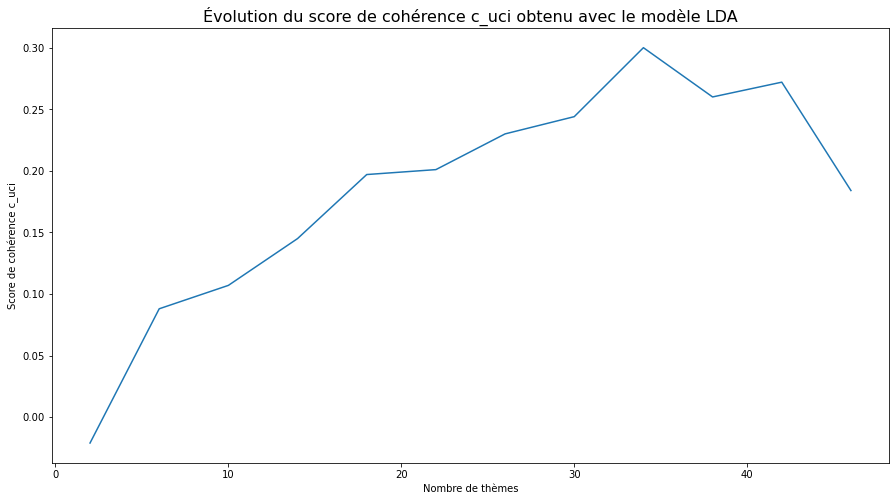

Thème n° 2 . Score de cohérence : -0.021
Thème n° 6 . Score de cohérence : 0.088
Thème n° 10 . Score de cohérence : 0.107
Thème n° 14 . Score de cohérence : 0.145
Thème n° 18 . Score de cohérence : 0.197
Thème n° 22 . Score de cohérence : 0.201
Thème n° 26 . Score de cohérence : 0.23
Thème n° 30 . Score de cohérence : 0.244
Thème n° 34 . Score de cohérence : 0.3
Thème n° 38 . Score de cohérence : 0.26
Thème n° 42 . Score de cohérence : 0.272
Thème n° 46 . Score de cohérence : 0.184


In [63]:
limit=50
start=2
step=4
x = range(start, limit, step)
plt.plot(x, coherence_values_LDA)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_uci obtenu avec le modèle LDA", fontsize=16)
plt.show()

for i, c_uci in zip(x, coherence_values_LDA):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

Assurons nous que le score de cohérence *c_uci* ne prend pas de de plus grandes valeurs pour des nombres de thème plus élevés.

In [57]:
LDA_optimal_100, coherence_values_LDA_100 = compute_coherence_values_LDA(dictionary=id2word, bow_corpus=bow_corpus, corpus=corpus, nb_topics_max=100, nb_topics_start=50, step=10)

  0%|          | 0/5 [00:00<?, ?it/s]

In [155]:
save_pickle(coherence_values_LDA_100, "coherence_values_LDA_100")

Fichier enregistré sous le nom coherence_values_LDA_100


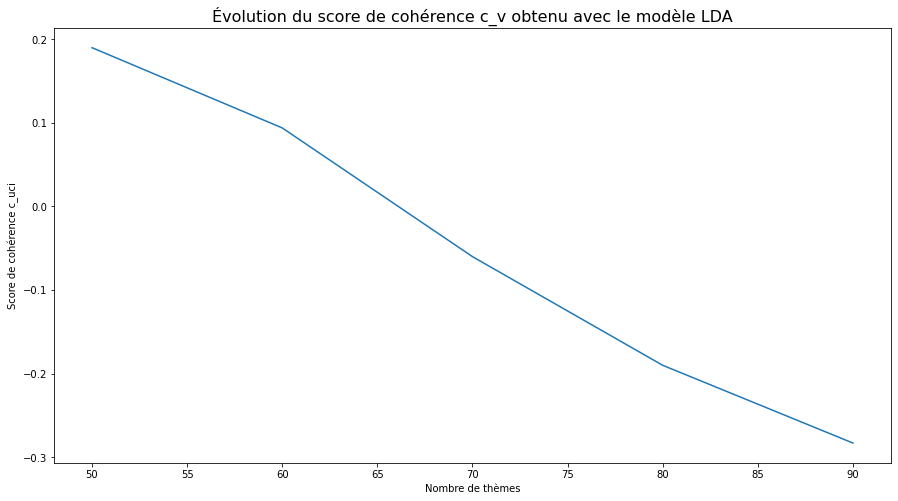

Thème n° 50 . Score de cohérence : 0.19
Thème n° 60 . Score de cohérence : 0.094
Thème n° 70 . Score de cohérence : -0.06
Thème n° 80 . Score de cohérence : -0.19
Thème n° 90 . Score de cohérence : -0.283


In [59]:
limit=100
start=50
step=10
x_100 = range(start, limit, step)
plt.plot(x_100, coherence_values_LDA_100)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_v obtenu avec le modèle LDA", fontsize=16)
plt.show()

for i, c_uci in zip(x_100, coherence_values_LDA_100):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

Recherche de d'un éventuel optimum caché dans la plage [32,36] :

In [72]:
LDA_optimal_tight, coherence_values_LDA_tight = compute_coherence_values_LDA(dictionary=id2word, bow_corpus=bow_corpus, corpus=corpus, nb_topics_max=37, nb_topics_start=32, step=1)

  0%|          | 0/5 [00:00<?, ?it/s]

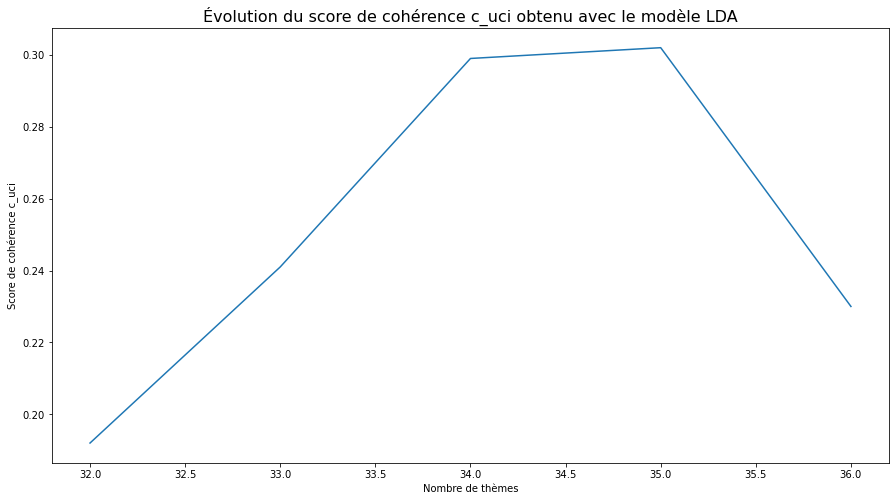

Thème n° 32 . Score de cohérence : 0.192
Thème n° 33 . Score de cohérence : 0.241
Thème n° 34 . Score de cohérence : 0.299
Thème n° 35 . Score de cohérence : 0.302
Thème n° 36 . Score de cohérence : 0.23


In [73]:
limit=37
start=32
step=1
x_tight = range(start, limit, step)
plt.plot(x_tight, coherence_values_LDA_tight)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_uci obtenu avec le modèle LDA", fontsize=16)
plt.show()

for i, c_uci in zip(x_tight, coherence_values_LDA_tight):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

**Nous avions bien un maximum caché : *C_UCI_max* = 0.302 pour 35 thèmes**.

### Non-negative Matrix Factorisation

In [64]:
def compute_coherence_values_NMF(dictionary, tfidf_corpus, corpus, nb_topics_max=100, nb_topics_start=2, step=3):
    """
        But :

            Calculer le score de cohérence des topics déterminés par le modèle NMF pour une plage de valeur du 
            nombre de topics donnée

        Arguments :

            dictionnary : dictionnaire des tokens du corpus
            tfidf_corpus : ensemble des vecteurs TF-IDF obtenus sur chacun des documents du corpus
            corpus : liste de l'ensemble des documents (liste de liste de tokens)
            nb_topics_max : nombre de topics 

        Valeurs retournées :

            NMF_optimal : modèle NMF ayant obtenu le meilleur score de cohérence
            coherence_values : liste des valeurs du score de cohérence obtenus pour les différentes valeurs du nombre
                               de topics étudiées
    """
    coherence_values = []
    model_list = []
    
    for nb_topics in trange(nb_topics_start, nb_topics_max, step):
        
        model = Nmf(corpus=tfidf_corpus,
                    id2word=dictionary,
                    num_topics=nb_topics, 
                    random_state=SEED,
                    passes=10,
                    normalize=True
                   )

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=corpus, dictionary=dictionary, coherence='c_uci')
        coherence_values.append(round(coherencemodel.get_coherence(),3))
        
        NMF_optimal = model_list[np.argmax(coherence_values)]

    return NMF_optimal, coherence_values

In [ ]:
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

In [156]:
save_pickle(tfidf, "tfidf_unsupervised")
save_pickle(tfidf_corpus, "tfidf_corpus_unsupervised")

Fichier enregistré sous le nom tfidf_unsupervised
Fichier enregistré sous le nom tfidf_corpus_unsupervised


In [16]:
%store -r tfidf
tfidf_corpus = [tfidf[text] for text in bow_corpus]

In [66]:
NMF_optimal, coherence_values_NMF = compute_coherence_values_NMF(dictionary=id2word, tfidf_corpus=tfidf_corpus, corpus=corpus, nb_topics_max=50, nb_topics_start=2, step=4)

  0%|          | 0/12 [00:00<?, ?it/s]

In [157]:
save_pickle(coherence_values_NMF, "coherence_values_NMF")

Fichier enregistré sous le nom coherence_values_NMF


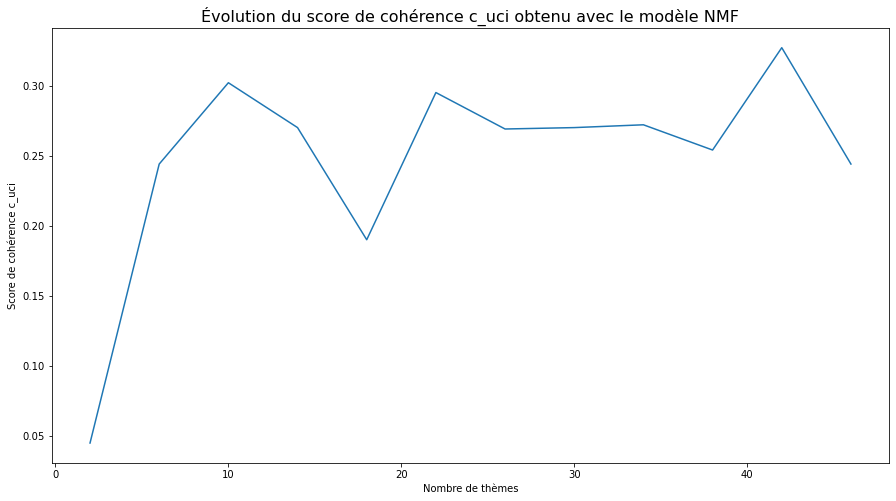

Thème n° 2 . Score de cohérence : 0.045
Thème n° 6 . Score de cohérence : 0.244
Thème n° 10 . Score de cohérence : 0.302
Thème n° 14 . Score de cohérence : 0.27
Thème n° 18 . Score de cohérence : 0.19
Thème n° 22 . Score de cohérence : 0.295
Thème n° 26 . Score de cohérence : 0.269
Thème n° 30 . Score de cohérence : 0.27
Thème n° 34 . Score de cohérence : 0.272
Thème n° 38 . Score de cohérence : 0.254
Thème n° 42 . Score de cohérence : 0.327
Thème n° 46 . Score de cohérence : 0.244


In [68]:
plt.plot(x, coherence_values_NMF)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_uci obtenu avec le modèle NMF", fontsize=16)
plt.show()

for i, c_uci in zip(x, coherence_values_NMF):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

Assurons nous que le score de cohérence *c_uci* ne prend pas de de plus grandes valeurs pour des nombres de thème plus élevés.

In [69]:
NMF_optimal_100, coherence_values_NMF_100 = compute_coherence_values_NMF(dictionary=id2word, tfidf_corpus=tfidf_corpus, corpus=corpus, nb_topics_max=100, nb_topics_start=50, step=10)

  0%|          | 0/5 [00:00<?, ?it/s]

In [158]:
save_pickle(coherence_values_NMF_100, "coherence_values_NMF_100")

Fichier enregistré sous le nom coherence_values_NMF_100


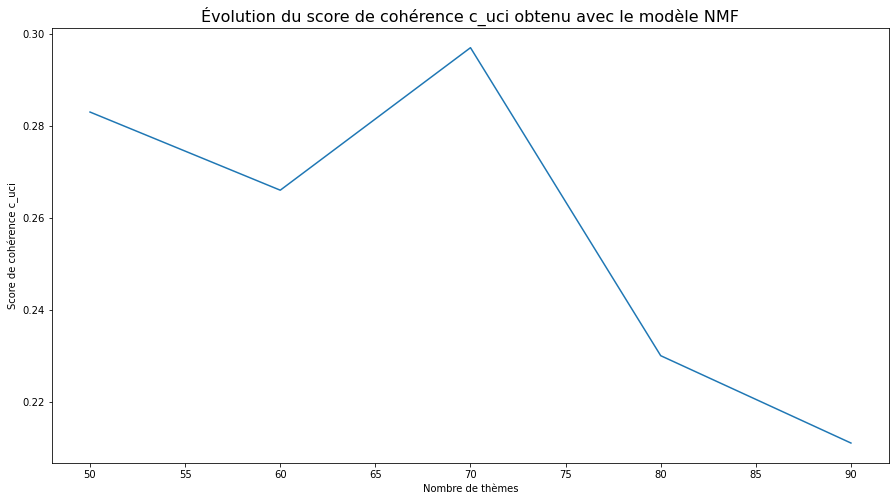

Thème n° 50 . Score de cohérence : 0.283
Thème n° 60 . Score de cohérence : 0.266
Thème n° 70 . Score de cohérence : 0.297
Thème n° 80 . Score de cohérence : 0.23
Thème n° 90 . Score de cohérence : 0.211


In [71]:
plt.plot(x_100, coherence_values_NMF_100)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_uci obtenu avec le modèle NMF", fontsize=16)
plt.show()

for i, c_uci in zip(x_100, coherence_values_NMF_100):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

Recherche d'un éventuel optimum caché dans la plage [40,44] :

In [74]:
NMF_optimal_tight, coherence_values_NMF_tight = compute_coherence_values_NMF(dictionary=id2word, tfidf_corpus=tfidf_corpus, corpus=corpus, nb_topics_max=45, nb_topics_start=40, step=1)

  0%|          | 0/5 [00:00<?, ?it/s]

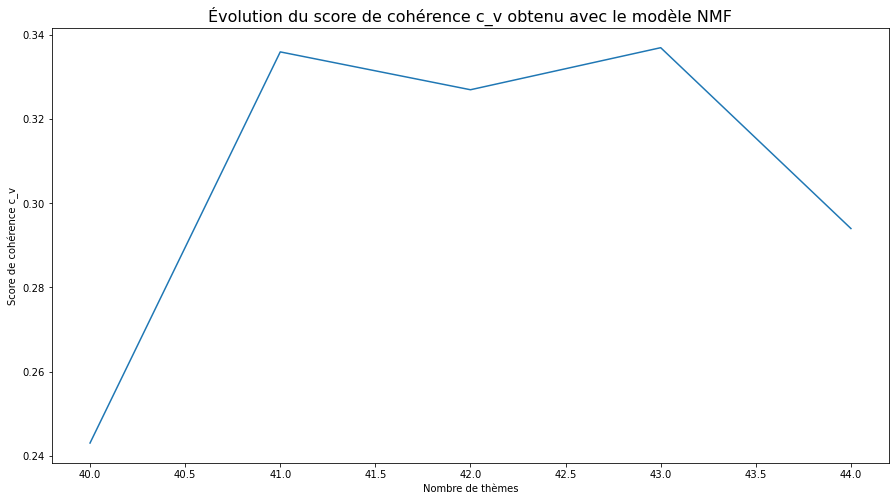

Thème n° 40 . Score de cohérence : 0.243
Thème n° 41 . Score de cohérence : 0.336
Thème n° 42 . Score de cohérence : 0.327
Thème n° 43 . Score de cohérence : 0.337
Thème n° 44 . Score de cohérence : 0.294


In [77]:
x_tight = range(40,45)
plt.plot(x_tight, coherence_values_NMF_tight)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_v")
plt.title("Évolution du score de cohérence c_v obtenu avec le modèle NMF", fontsize=16)
plt.show()

for i, c_uci in zip(x_tight, coherence_values_NMF_tight):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

**Nous avions bien un maximum caché : *C_UCI_max* = 0.337 pour 43 thèmes**.

In [10]:
# enregistrement des meilleurs modèles LDA et NMF 

# LDA_optimal_file = datapath("LDA_optimal")
# LDA_optimal_tight.save(LDA_optimal_file)

LDA_optimal_final = LdaMulticore.load(datapath("LDA_optimal"))

# NMF_optimal_file = datapath("NMF_optimal")
# NMF_optimal_tight.save(NMF_optimal_file)

NMF_optimal_final = Nmf.load(datapath("NMF_optimal"))

## Comparaison des 2 approches non-supervisées

### <u>Temps d'entraînement</u>

En dépit de l'utilisation de tous les ressources de calculs disponibles au sein du processeur de l'ordinateur, l'entraînement des 12 premiers modèles **LDA** a prit environ **2,5** fois plus de temps que celui des modèles **NMF** (3h soit ~15 minutes par modèle contre 1h15 soit ~6 minutes par modèle).

Cependant, pour l'entraînement des modèles pour de plus grandes valeurs du nombre de thèmes, cet écart a très grandement diminué :

   1. **LDA** : 1h10 soit 14 minutes par modèle
   2. **NMF** : 1h05 soit 13 minutes par modèle
   
Puis, pour la recherche du maximum :

   1. **LDA** : 1h10 soit 14 minutes par modèles
   2. **NMF** : 47 minutes soit ~9 minutes

Il semble donc que l'algorithme **NMF** soit moins stable en terme de rapidité de calcul que **LDA** lorsque le nombre de thèmes augmente beaucoup (même temps de calcul pour **LDA** contre plus de 100% d'augmentation pour **NMF**).

### <u>Score de cohérence</u> *c_uci*

Nous obtenons avec nos modèles, des scores de cohérence maximaux relativement proches (12% d'écart en faveur du modèle **NMF**):
    
   1. **LDA** : *c_uci* = **0.302** pour **35** thèmes
   2. **NMF** : *c_uci* = **0.337** pour **43** thèmes

### <u>Interprétation des thèmes</u>

Nous allons étudier les mots les plus représentatifs de chacun des thèmes discernées par nos 2 modèles afin d'en évaluer la pertinence du point de vue de la compréhension humaine.

In [78]:
def plot_top_words(model, feature_names, n_top_words, title):
    """
        But :

            Tracer un graphique regroupant pour chaque thème discerné par le modèle concerné, les mots les plus représentatifs 
            en mettant en exergue leurs importances relatives au sein même du thème.

        Arguments :

            model : modèle de Topic Modelling entraîné.
            features_names : listes des tokens du corpus sur lequel le modèle a été entraîné.
            n_top_words : nombre des mots les plus représentatifs à comparer.
            title : titre du graphique.

        Valeurs retournées :

            None : affiche le graphique attendu.
    """
    
    if len(model.get_topics())//5 == len(model.get_topics())/5:
        nb_rows = int(len(model.get_topics())/5)
        last_row_nb_cols = 5
    else:
        nb_rows = int(len(model.get_topics())//5+1)
        last_row_nb_cols = int(len(model.get_topics())%(nb_rows-1))
    
    for row in range(nb_rows):
        
        if row != nb_rows-1:
            fig, axes = plt.subplots(1, 5, figsize=(15, 8))
            axes = axes.flatten()
        else:
            fig, axes = plt.subplots(1, last_row_nb_cols, figsize=(15, 8))
            axes = axes.flatten()
    
        topics_data = model.get_topics()[5*row:np.min([5*(row+1), len(model.get_topics())])]

        for topic_idx, topic in enumerate(topics_data):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.3)
            ax.set_title(f"Topic {topic_idx + 1 + 5*row}", fontdict={"fontsize": 20})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=12)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            if row == 0:
                fig.suptitle(title, fontsize=24)

        plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
        plt.show()

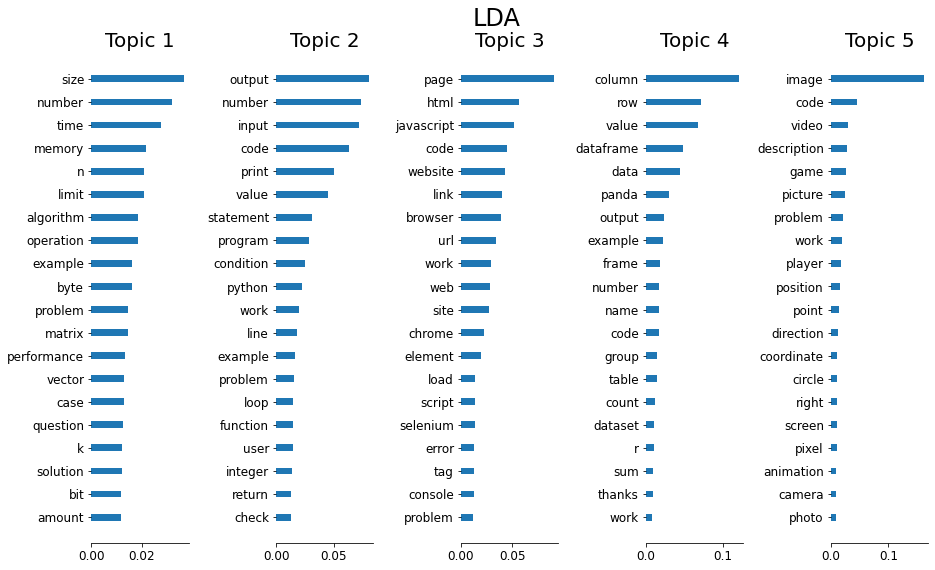

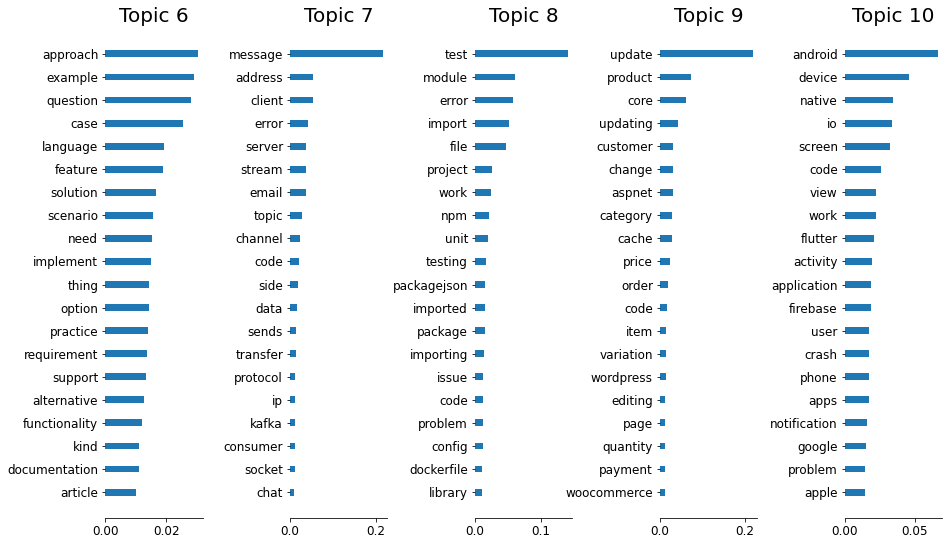

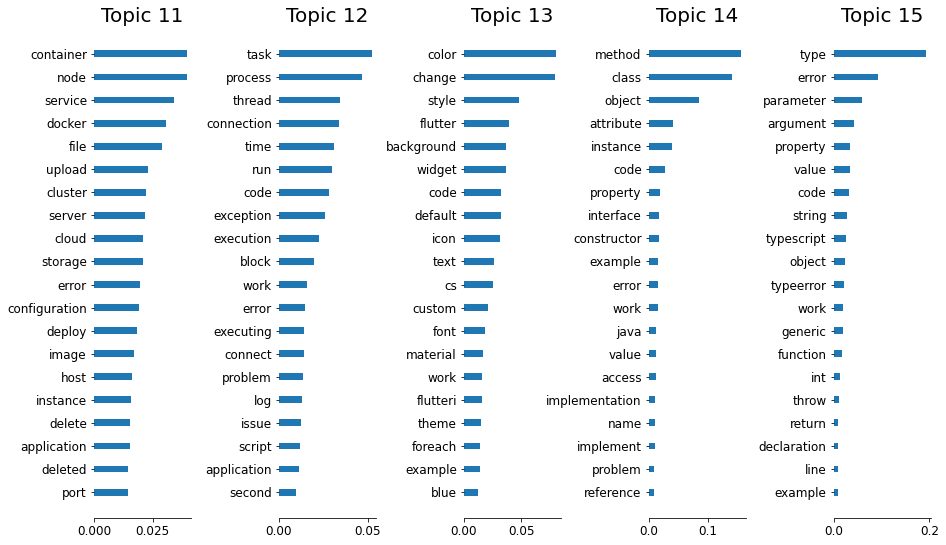

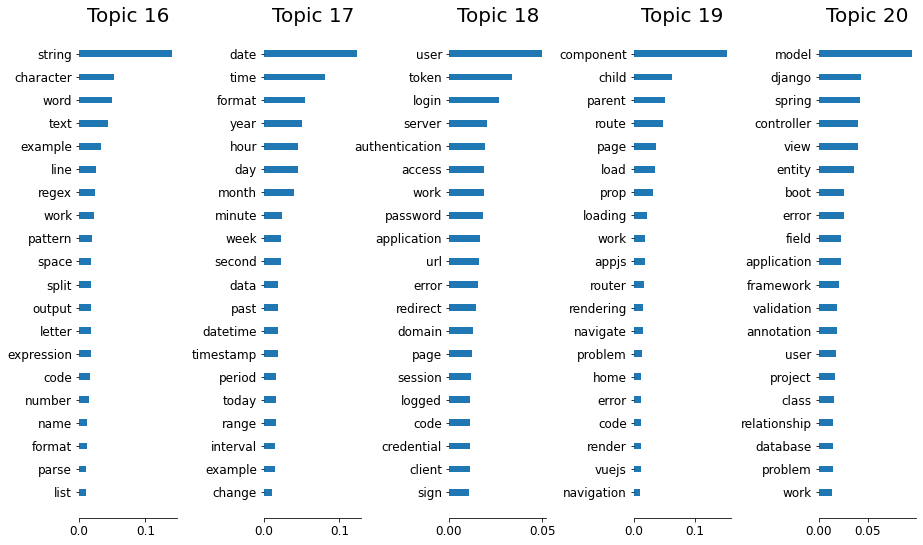

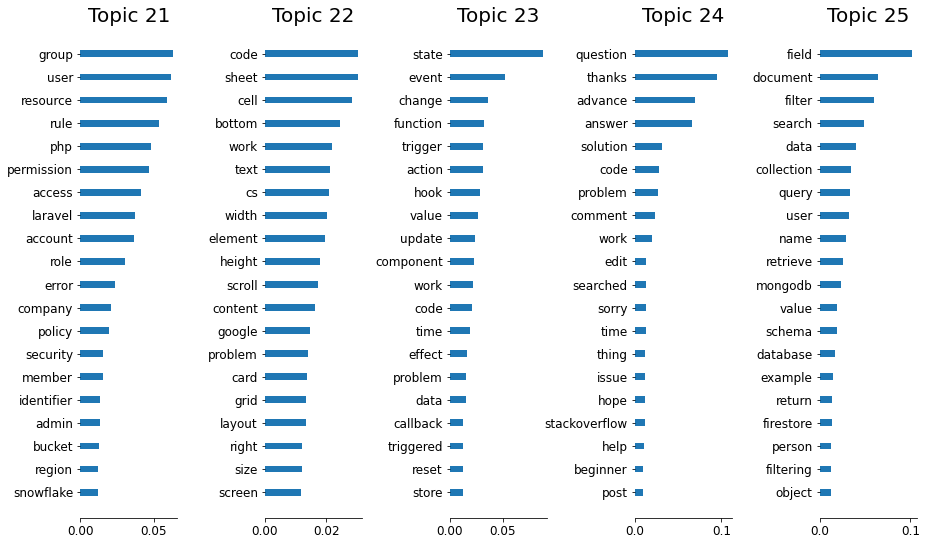

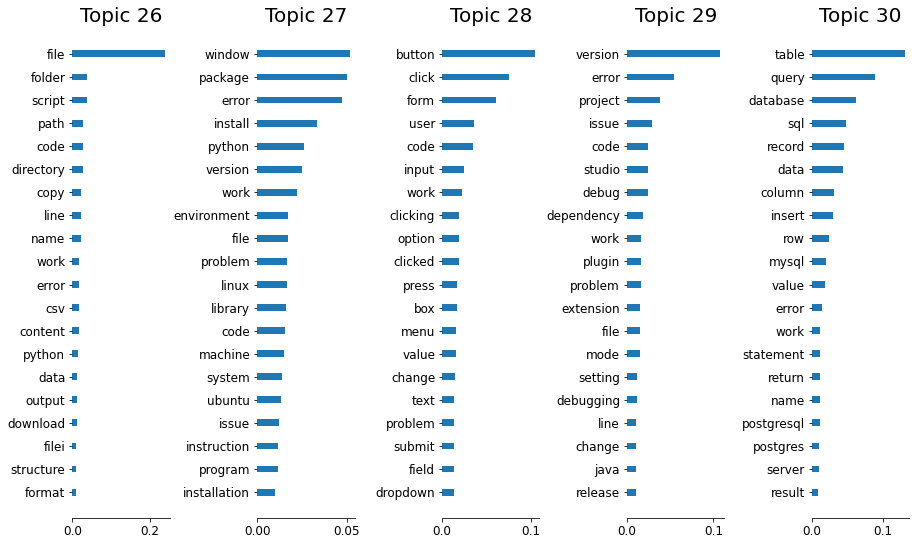

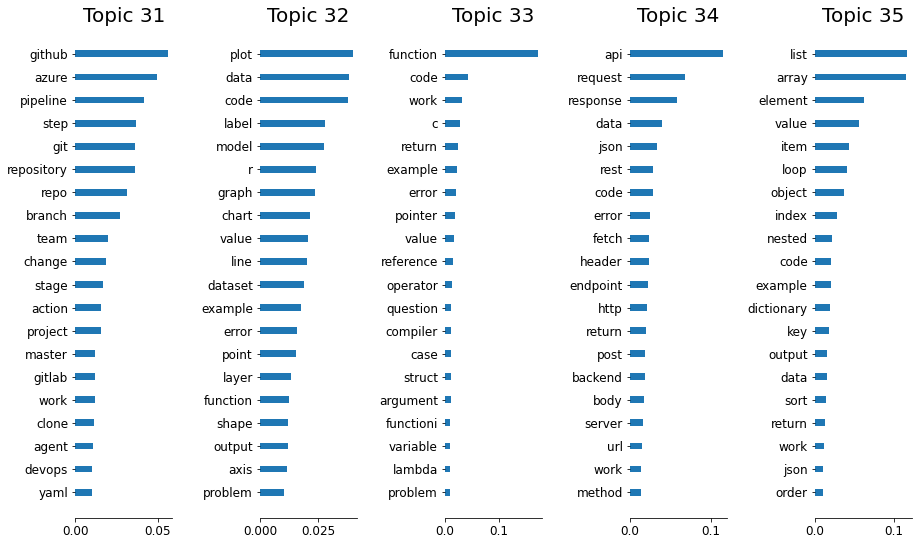

In [80]:
plot_top_words(LDA_optimal_final, list(id2word.itervalues()), 20, "LDA")

**Interprétation des thèmes discernés par le modèle LDA**

   1. Algorithmique
   2. Questions sur la structure du code
   3. Usage d'internet et des navigateurs
   4. Manipulation de données tabulaires/dataframes
   5. Intégration Web de contenu multimédia
   6. Paradigme de programmation
   7. Gestion de réseaux de données
   8. Test de projets informatiques
   9. Mises à jour, changements d'état
   10. Développement d'applciation Android
   11. Gestion de données dans le cloud
   12. Optimisation de calculs
   13. Front End
   14. Programmation Orientée Objet
   15. Gestion des types de données
   16. Manipulation de données textuelles
   17. Manipulation de données temporelles
   18. Gestion de l'authentification
   19. Développement d'interfaces usagers Web
   20. Développement d'applicatifs Web
   21. Back End Web
   22. Front End Web
   23. Gestions d'évènement et programamtion asynchrone
   24. Débuggage du code
   25. Recherche d'information textuelle dans les documents
   26. Manipulation de fichiers et dossiers
   27. Installations de programmes
   28. Front End Web
   29. Gestions de librairies et versionnage
   30. Bases de données relationnelles
   31. Hébergement et gestion de développment de projets
   32. Visualisation de données
   33. Conception des fonctions
   34. Utilisation d'API
   35. Itérateurs
   
**Les thèmes se retrouvent aisément en lisant les 20 mots les plus représentatifs**.

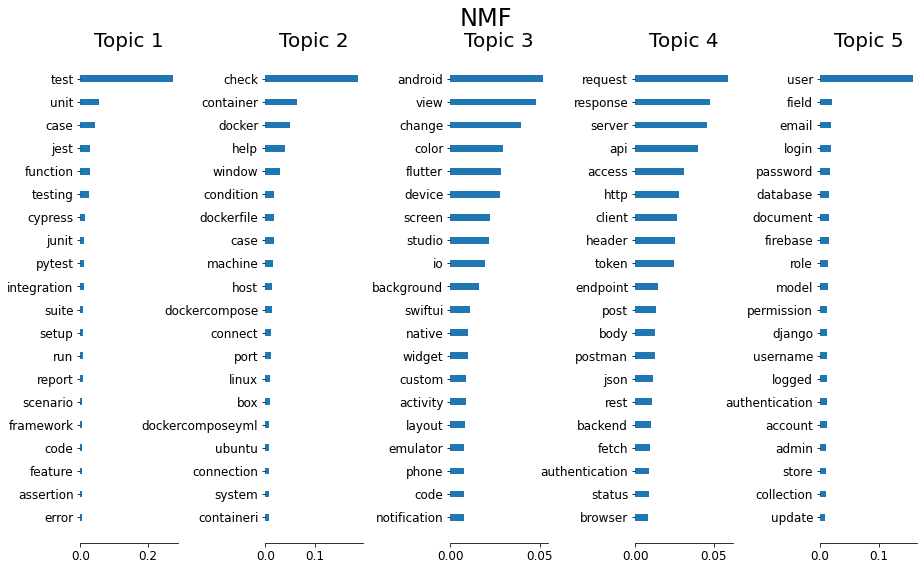

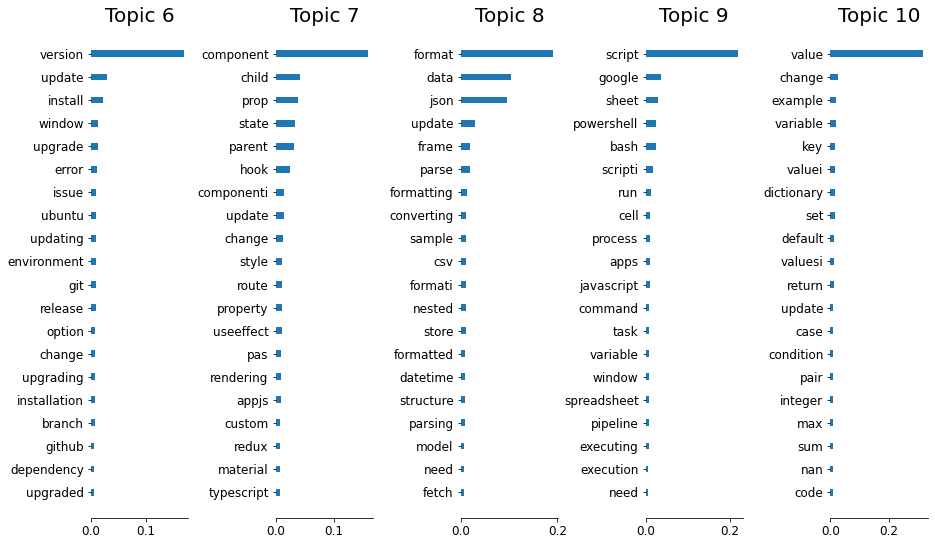

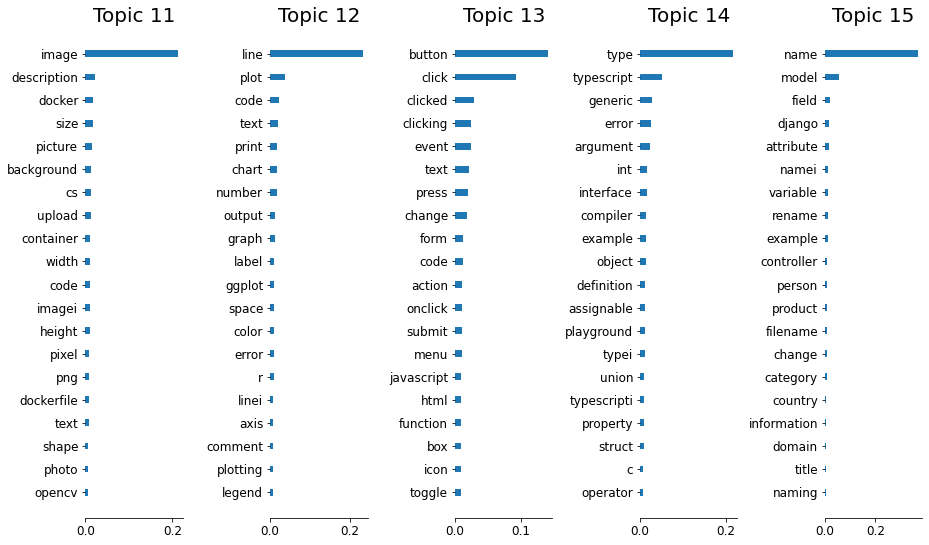

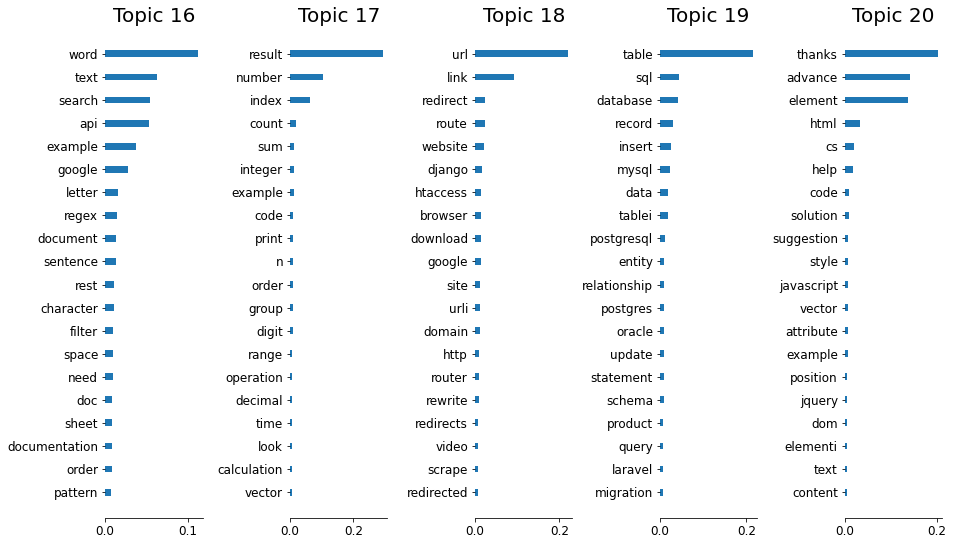

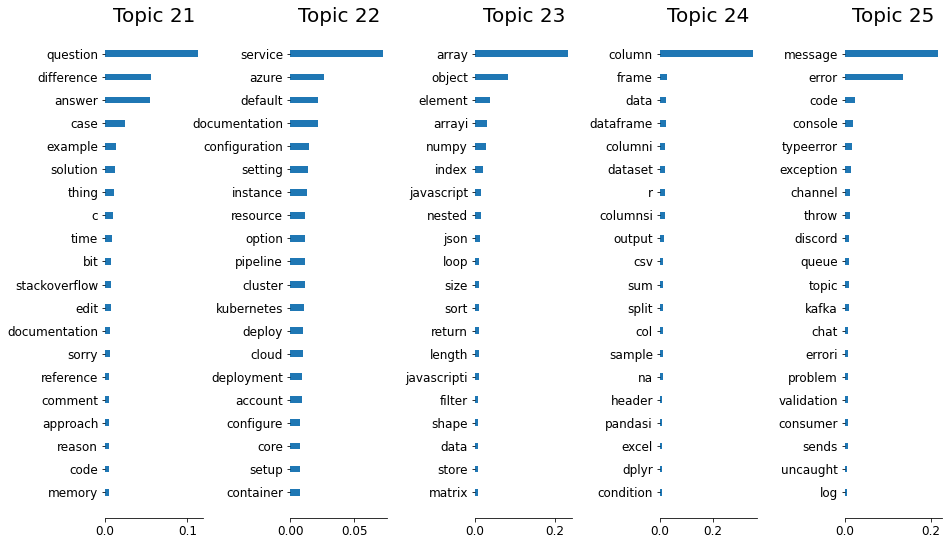

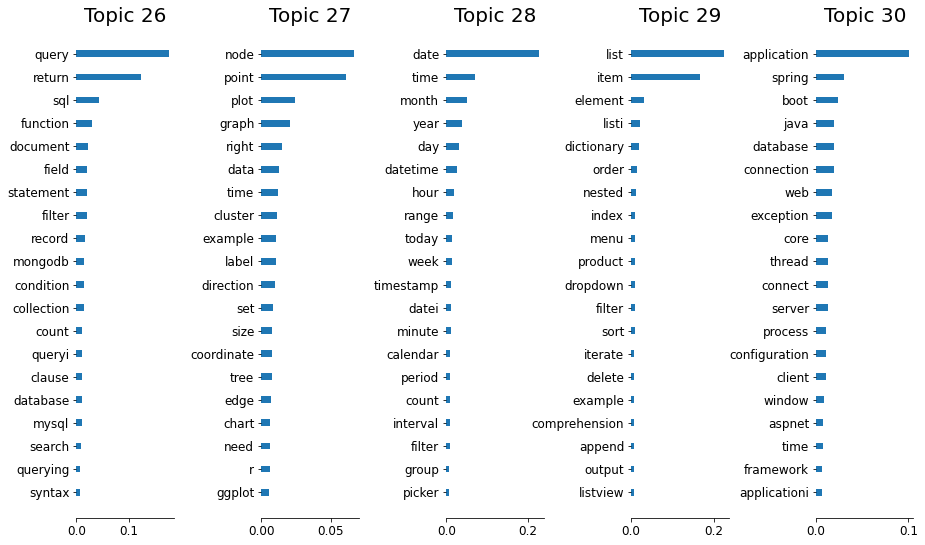

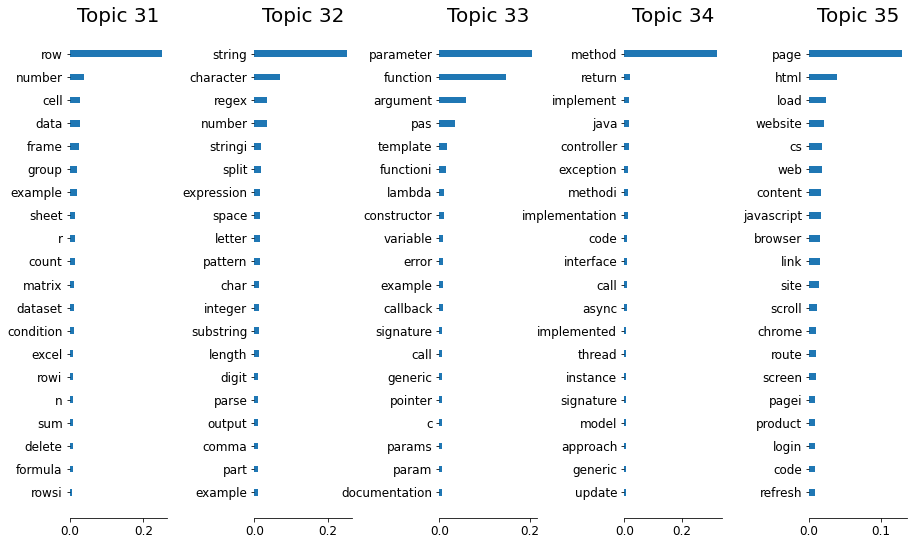

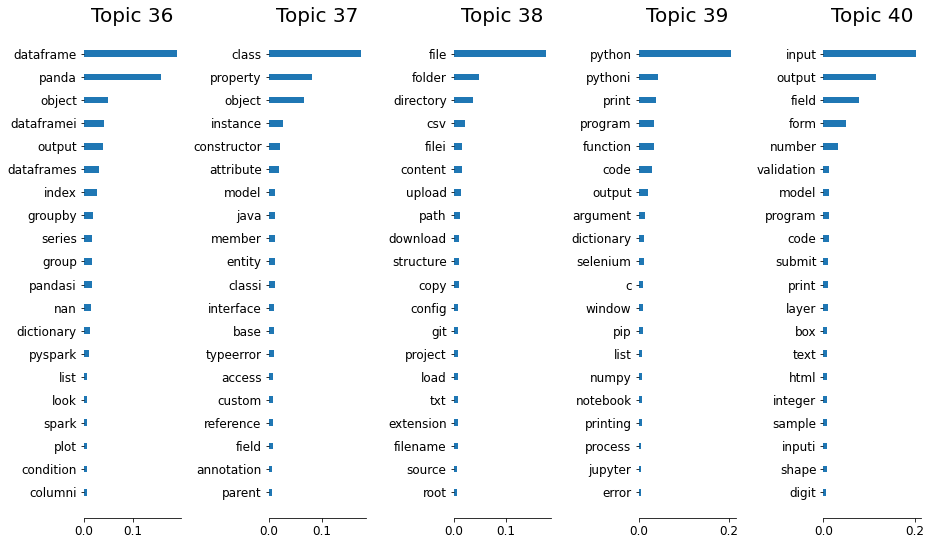

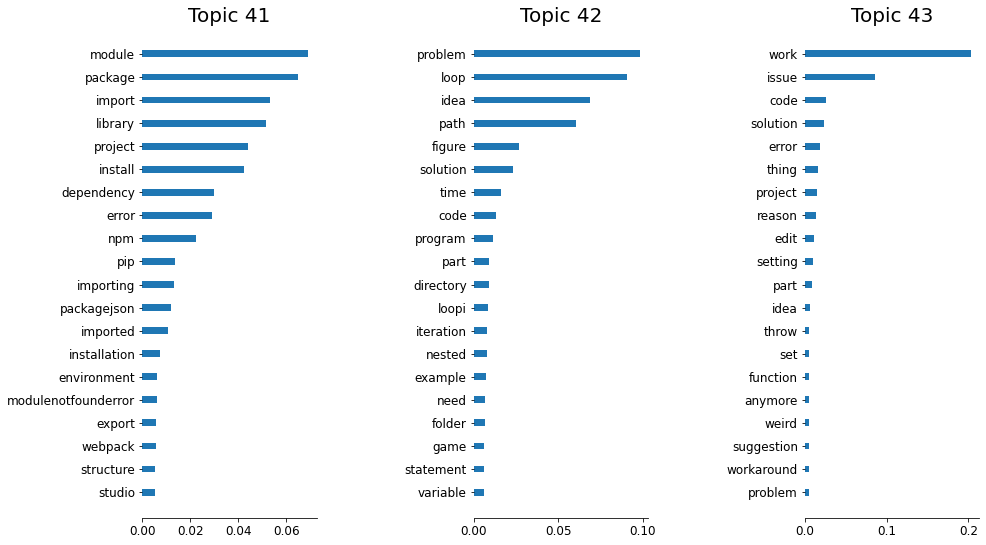

In [81]:
plot_top_words(NMF_optimal_final, list(id2word.itervalues()), 20, "NMF")

**Interprétation des thèmes discernés par le modèle NMF**

   1. Tests de projets informatiques
   2. Gestions de données dans le cloud
   3. Développemeent d'application Android
   4. Gestion de réseaux de données
   5. Gestion de l'auhtentification
   6. Versionnage
   7. Développement d'interfaces usagers Web
   8. Formattage des données ~
   9. Tableurs dans le cloud
   10. Interprétation des données ~
   11. Intégration d'image ~
   12. Visualisation de données
   13. Éléments Web interactable
   14. Gestion de types de données
   15. Développement d'applicatifs Web ~
   16. Recherche d'information textuelle dans les documents ~
   17. Manipulation de données tabulaires (ou liste) ~
   18. Usage d'internet et des navigateurs ~
   19. Bases de données relationnelles
   20. Questions sur le développement HTML/CSS ~
   21. *Questions ~~* (divers ??)
   22. Services cloud
   23. Manipulations de données tabulaires
   24. Navigation dans des données tabulaires
   25. Gestions des erreurs ou exceptions
   26. Recherche d'informations dans un corpus de documents ~
   27. Visualisation de partitionnement ~
   28. Manipulation de données temporelles
   29. Manipulation de listes
   30. Développement d'applicatifs Web
   31. Navigation dans des données tabulaires
   32. Manipulation de chaînes de caractères
   33. Conception des fonctions
   34. Utilisation des méthodes (POO)
   35. Navigation sur internet
   36. Manipulation de dataframes
   37. Programmation Orientée Objet
   39. Programmation avec Python
   40. Gestion de l'I/O
   41. Gestions de librairies et versionnage
   42. Questions sur la structure du code
   43. Débuggage du code ~
   
**Un grand nombre de thèmes sont difficiles à interpréter (12, dont 1 très difficile à interpréter, soit près de 30% des thèmes discernés par le modèle)**.

### <u>Examen actif des documents associés à chaque thème</u>

Maintenant que nous avons interpréter chaque thème, examinons les documents les plus représentatifs de chaque thème pour vérifier la pertinence des partiotionnement réalisés par nos modèles

In [110]:
def format_topics_sentences(ldamodel, corpus):
    # Init output
    df_topics = pd.DataFrame(data={'Dominant_Topic_num':[], 'Perc_Contribution':[], 'Topic_Keywords':[]})

    # Get main topic in each document
    for i in trange(len(ldamodel[corpus])):
        row = ldamodel[corpus][i]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for (word, prop) in wp])
                df_topics = pd.concat([df_topics, 
                                            pd.DataFrame(data = {'Dominant_Topic_num':[int(topic_num)+1],
                                                                 'Perc_Contribution':[round(prop_topic,4)],
                                                                 'Topic_Keywords':[topic_keywords]
                                                                })
                                           ], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    df_topics.set_index(df_supervised.index, inplace=True)
    return df_topics

In [111]:
df_topics = format_topics_sentences(ldamodel=LDA_optimal_final, corpus=bow_corpus_unsupervised)

  0%|          | 0/998596 [00:00<?, ?it/s]

In [117]:
df_topics.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            999990, 999991, 999992, 999993, 999994, 999995, 999996, 999997,
            999998, 999999],
           dtype='int64', length=998596)

Nous pouvons désormais concaténer le résultat de notre fonction prédécente avec le le contenu des paragraphes des posts originaux ainsi que les tags nettoyés :

In [113]:
original_cleaned_keywords = df_lemmas['tags'][df_unsupervised.index]

In [114]:
original_post = df_datas.apply(lambda x: x['title'] + x['body'], axis=1)[df_unsupervised.index]

In [158]:
df_topics_tags =  df_topics.merge(pd.DataFrame(original_post), right_index=True, left_index=True)
df_topics_tags =  df_topics_tags.merge(pd.DataFrame(original_cleaned_keywords), right_index=True, left_index=True)
df_topics_tags.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Tags']

In [159]:
df_topics_tags

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Tags
0,17.0,0.3797,"date, time, format, year, hour, day, month, mi...",modifying bonita process instance after starte...,[bonita]
1,5.0,0.1826,"image, code, video, description, game, picture...",what does elevation in drawshadow do exactlyi ...,"[c++, dart, flutter, skia]"
2,33.0,0.5433,"function, code, work, c, return, example, erro...",how to use a trait object that contains a meth...,[rust]
3,28.0,0.5977,"button, click, form, user, code, input, work, ...",a way for users to store selections as inputs ...,"[r, shiny, shinyapps]"
4,10.0,0.3341,"android, device, native, io, screen, code, vie...",how to open downloaded photo using gallery app...,"[expo, gallery, linker, react]"
...,...,...,...,...,...
999995,26.0,0.3004,"file, folder, script, path, code, directory, c...",can you do a pull in a mongodb bulk write whic...,[mongodb]
999996,33.0,0.3196,"function, code, work, c, return, example, erro...",non static method cannot be called staticallyi...,"[laravel, php]"
999997,26.0,0.1937,"file, folder, script, path, code, directory, c...",sorting oslistdirs arbitrary order for desired...,"[list, python, sorting]"
999998,1.0,0.4514,"size, number, time, memory, n, limit, algorith...",big o complexity of nested loopwhat could be t...,[big]


In [161]:
df_topics_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998596 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dominant_Topic      998596 non-null  float64
 1   Topic_Perc_Contrib  998596 non-null  float32
 2   Keywords            998596 non-null  object 
 3   Text                998596 non-null  object 
 4   Tags                998596 non-null  object 
dtypes: float32(1), float64(1), object(3)
memory usage: 74.2+ MB


In [162]:
df_topics_tags['Dominant_Topic'] = df_topics_tags['Dominant_Topic'].astype(np.int8)
df_topics_tags['Topic_Perc_Contrib'] = df_topics_tags['Topic_Perc_Contrib'].astype(np.float16)

In [163]:
df_topics_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998596 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dominant_Topic      998596 non-null  int8   
 1   Topic_Perc_Contrib  998596 non-null  float16
 2   Keywords            998596 non-null  object 
 3   Text                998596 non-null  object 
 4   Tags                998596 non-null  object 
dtypes: float16(1), int8(1), object(3)
memory usage: 65.6+ MB


In [185]:
dict_topics_num_title = {
                           1: "Algorithmique",
                           2: "Questions sur la structure du code",
                           3: "Usage d'internet et des navigateurs",
                           4: "Manipulation de données tabulaires/dataframes",
                           5: "Intégration Web de contenu multimédia",
                           6: "Paradigme de programmation",
                           7: "Gestion de réseaux de données",
                           8: "Test de projets informatiques",
                           9: "Mises à jour, changements d'état",
                           10: "Développement d'applciation Android",
                           11: "Gestion de données dans le cloud",
                           12: "Optimisation de calculs",
                           13: "Front End",
                           14: "Programmation Orientée Objet",
                           15: "Gestion des types de données",
                           16: "Manipulation de données textuelles",
                           17: "Manipulation de données temporelles",
                           18: "Gestion de l'authentification",
                           19: "Développement d'interfaces usagers Web",
                           20: "Développement d'applicatifs Web",
                           21: "Back End Web",
                           22: "Front End Web",
                           23: "Gestions d'évènement et programamtion asynchrone",
                           24: "Débuggage du code",
                           25: "Recherche d'information textuelle dans les documents",
                           26: "Manipulation de fichiers et dossiers",
                           27: "Installations de programmes",
                           28: "Front End Web",
                           29: "Gestions de librairies et versionnage",
                           30: "Bases de données relationnelles",
                           31: "Hébergement et gestion de développment de projets",
                           32: "Visualisation de données",
                           33: "Conception des fonctions",
                           34: "Utilisation d'API",
                           35: "Itérateurs"
}

In [186]:
df_topics_tags['Topic_title'] = df_topics_tags['Dominant_Topic'].replace(dict_topics_num_title)

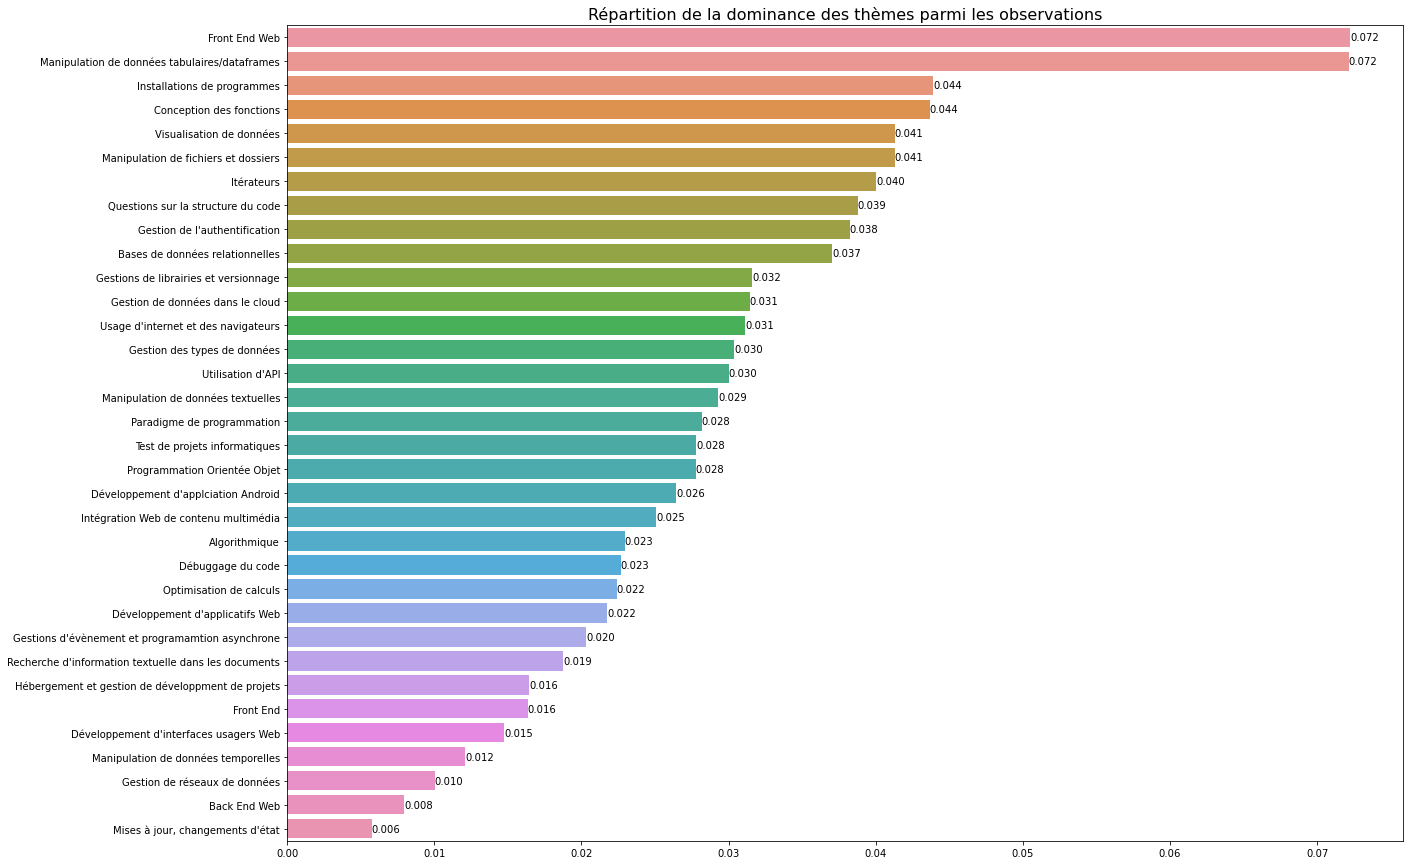

In [225]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=df_topics_tags['Topic_title'].value_counts(normalize=True).values, y=df_topics_tags['Topic_title'].value_counts(normalize=True).index)
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title("Répartition de la dominance des thèmes parmi les observations", fontsize=16);

> Les thèmes **Front End Web** et **Manipulation de données tabulaires/DataFrames** sont les plus récurrents, sont proches dans leur dominance sur l'ensemble des observations et se démarquent du reste des thèmes.

In [187]:
topic_most_representatives_docs = df_topics_tags.groupby(by="Dominant_Topic").agg({'Topic_Perc_Contrib':'max'})
topic_most_representatives_docs

,Topic_Perc_Contrib
Dominant_Topic,
1,0.939453
2,0.942871
3,0.939453
4,0.959473
5,0.942871
6,0.902832
7,0.935059
8,0.953613
9,0.935059


In [188]:
topic_most_representatives_docs = topic_most_representatives_docs.merge(df_topics_tags[['Topic_title','Topic_Perc_Contrib','Keywords', 'Text', 'Tags']], left_on='Topic_Perc_Contrib', right_on='Topic_Perc_Contrib')
topic_most_representatives_docs

,Topic_Perc_Contrib,Topic_title,Keywords,Text,Tags
0,0.939453,Hébergement et gestion de développment de projets,"github, azure, pipeline, step, git, repository...",gitlab default issue template for all new proj...,"[automation, gitlab, pipeline]"
1,0.939453,Manipulation de données tabulaires/dataframes,"column, row, value, dataframe, data, panda, ou...",pandas isin based on common column for differ...,"[pandas, python]"
2,0.939453,Installations de programmes,"window, package, error, install, python, versi...",centos on virtual box yum install errori am tr...,"[centos, virtualbox]"
3,0.939453,Gestion de l'authentification,"user, token, login, server, authentication, ac...",auth silent auth not working on mobile works f...,"[auth, authentication, javascript, oauth, reac..."
4,0.939453,Manipulation de données tabulaires/dataframes,"column, row, value, dataframe, data, panda, ou...",select columns in a dataframe conditional on r...,"[dataframe, pandas, python]"
...,...,...,...,...,...
8533,0.948730,Manipulation de données tabulaires/dataframes,"column, row, value, dataframe, data, panda, ou...",isolating and joining adjacent columnscells ba...,"[isolate, loops, multiple, r]"
8534,0.948730,Manipulation de données tabulaires/dataframes,"column, row, value, dataframe, data, panda, ou...",groupby two columns and create a new column ba...,"[apply, lambda, pandas, python, subtraction]"
8535,0.948730,Manipulation de données tabulaires/dataframes,"column, row, value, dataframe, data, panda, ou...",check if values in all n previous rows are gre...,"[dataframe, pandas, python]"
8536,0.948730,Manipulation de données tabulaires/dataframes,"column, row, value, dataframe, data, panda, ou...",filling nan based on reverse moving averageto ...,"[dataframe, pandas, python, rolling]"


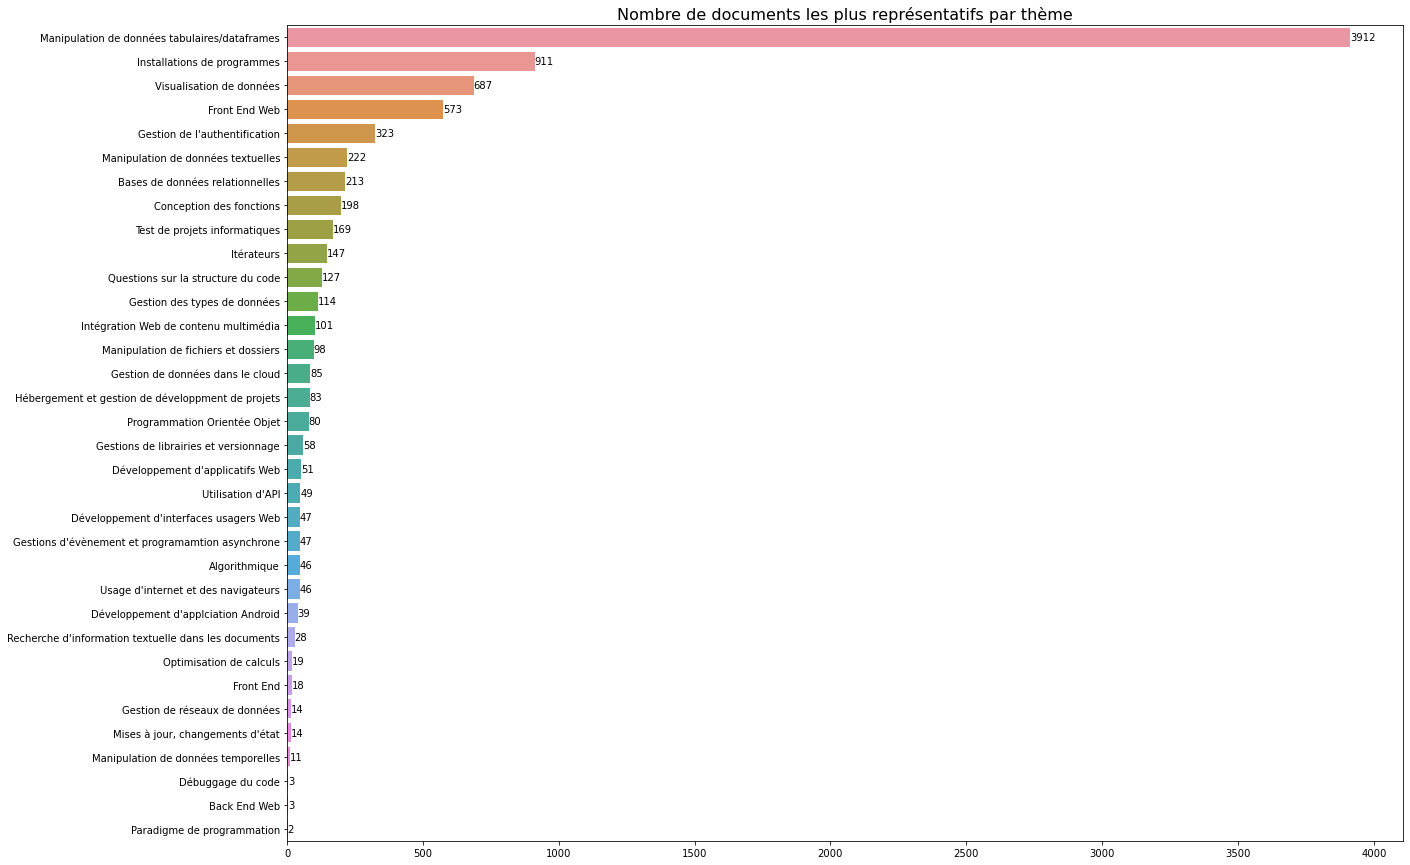

In [192]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=topic_most_representatives_docs['Topic_title'].value_counts().values, 
            y=topic_most_representatives_docs['Topic_title'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title("Nombre de documents les plus représentatifs par thème", fontsize=16);

> Il y a une nette différence entre le thème **Manipulation de données tabulaires/dataframes** et le reste des thèmes.

Étant donné qu'il s'agit du thème dominant dans le plus grand nombre d'observations, nous allons observer les distributions de la variable **Topi_Perc_Contrib** pour vérifier si ce sont les documents attribué au thème **Manipulation de données tabulaires/dataframes** qui sont particulièrement identifiables (distribution skewed vers les hautes valeurs) ou bien si le résultat précédent est le fait d'un plus grand nombre de documents attribués à ce thèmes.

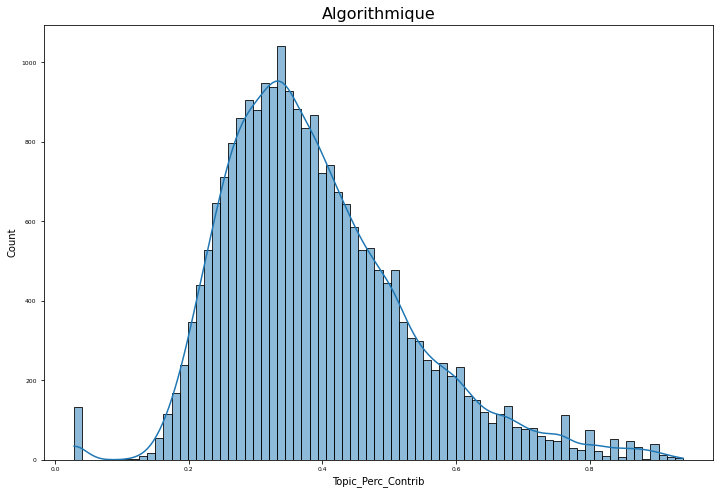

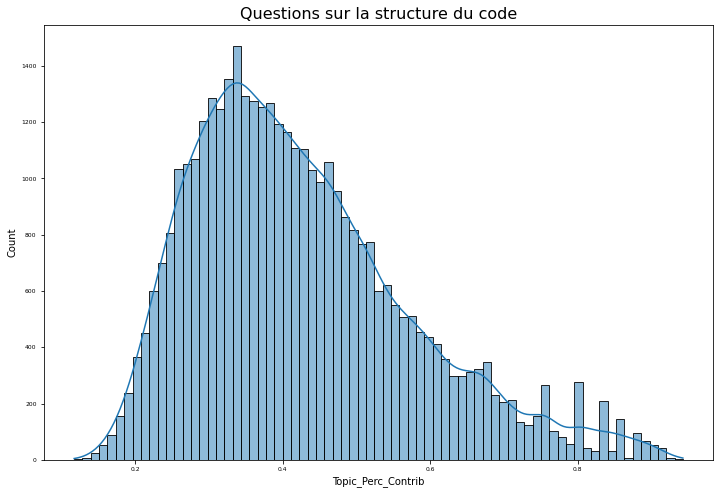

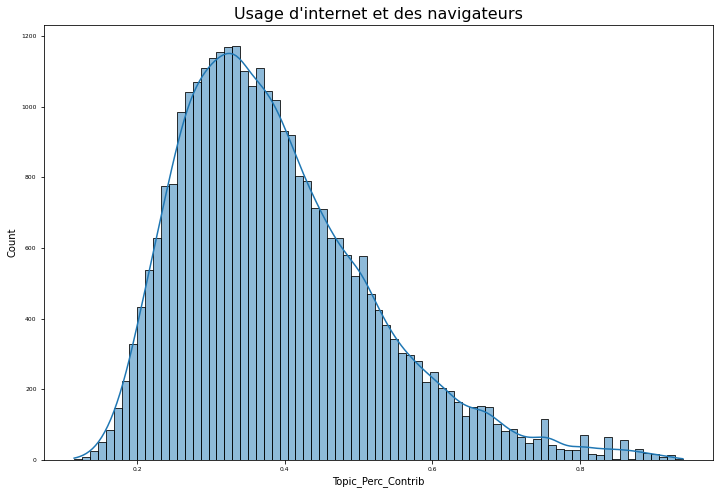

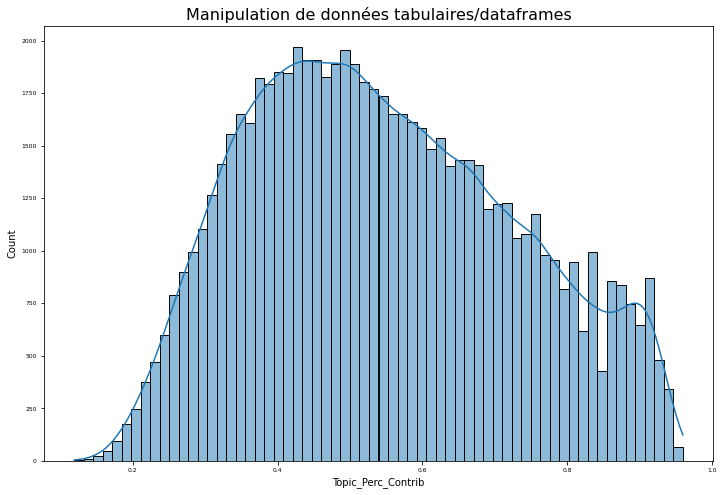

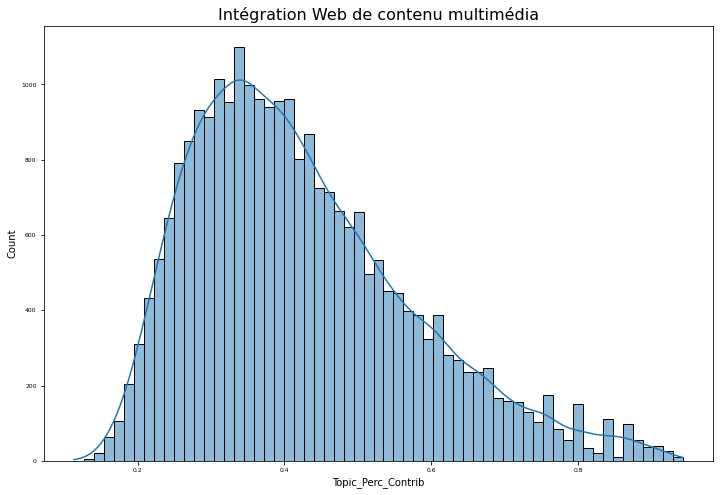

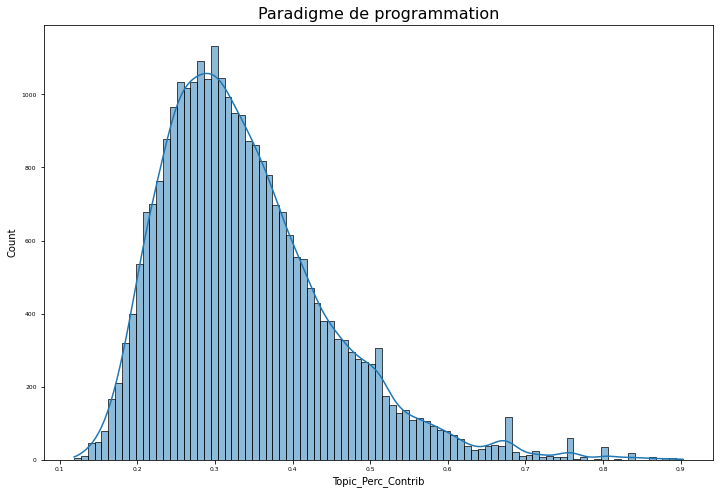

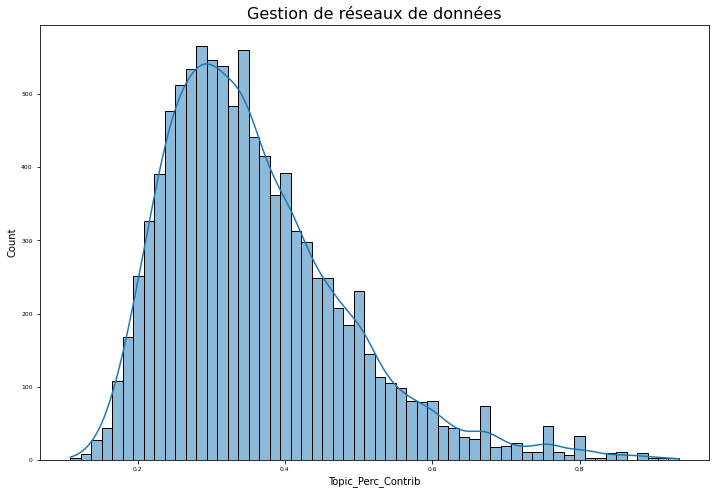

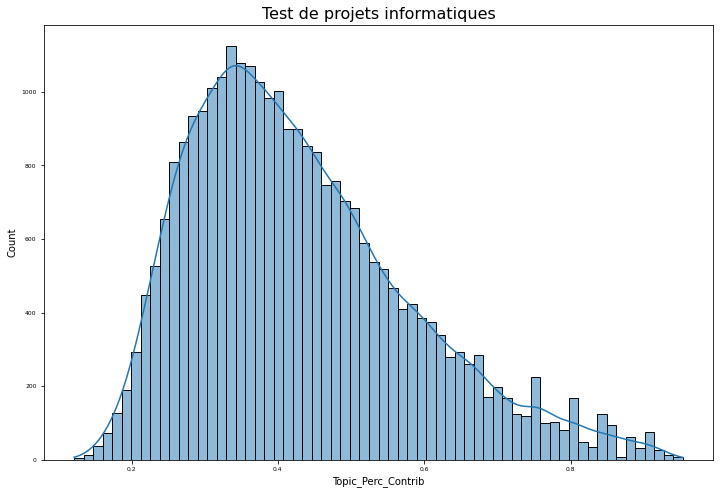

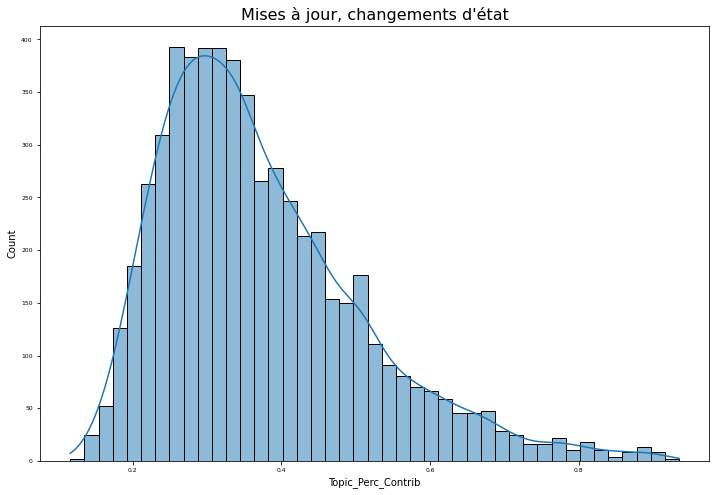

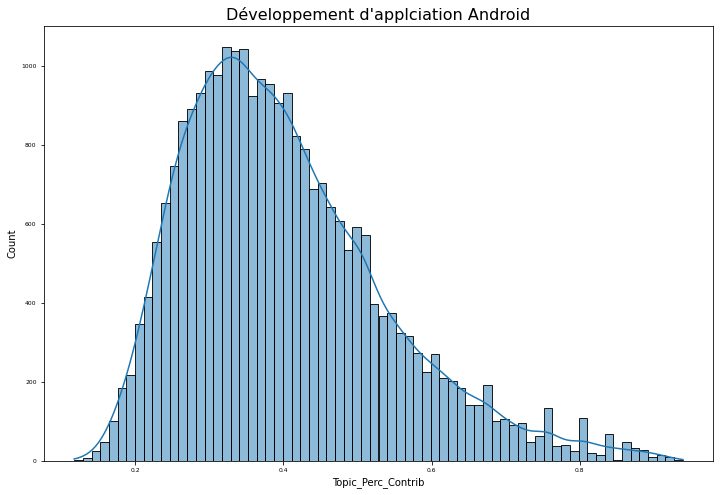

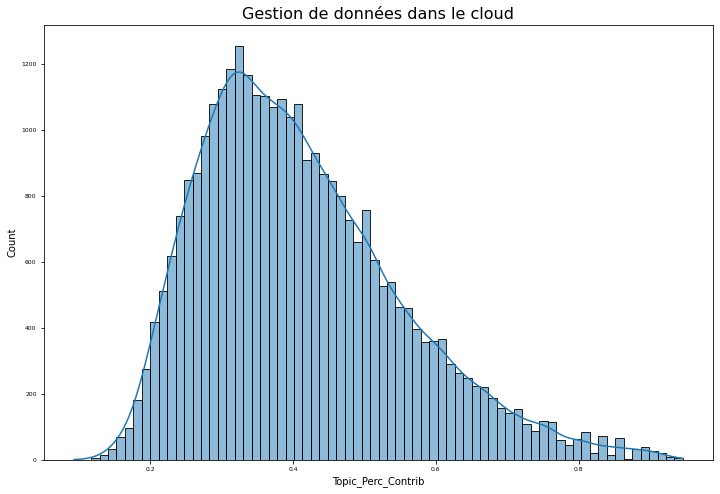

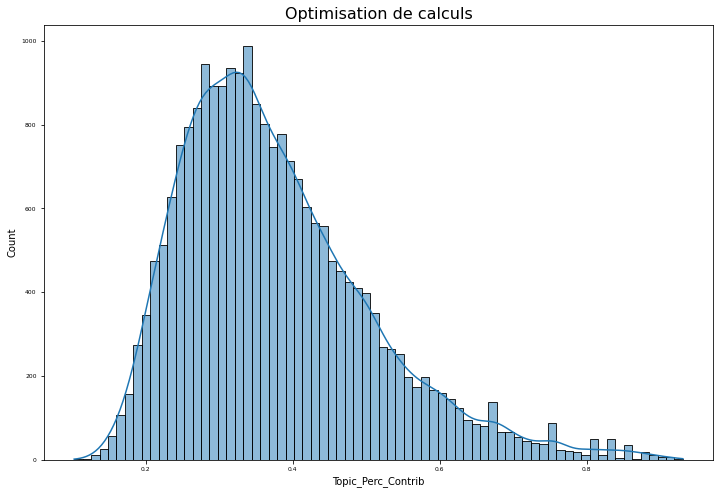

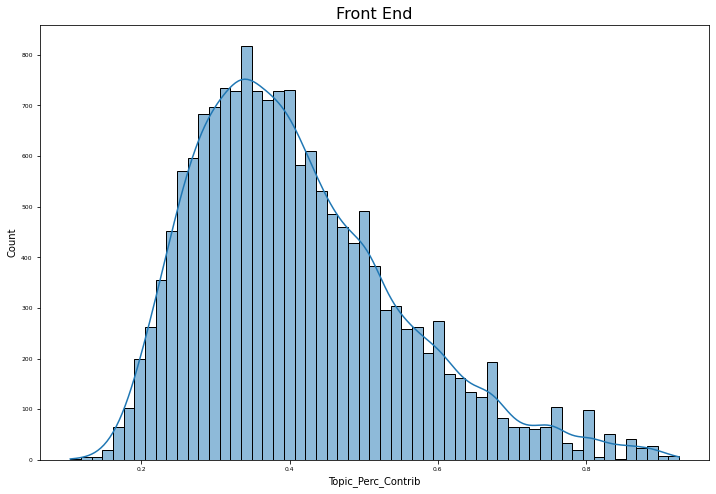

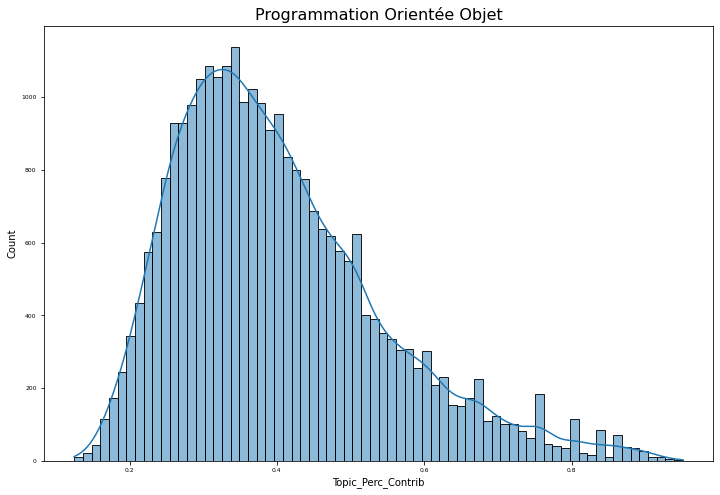

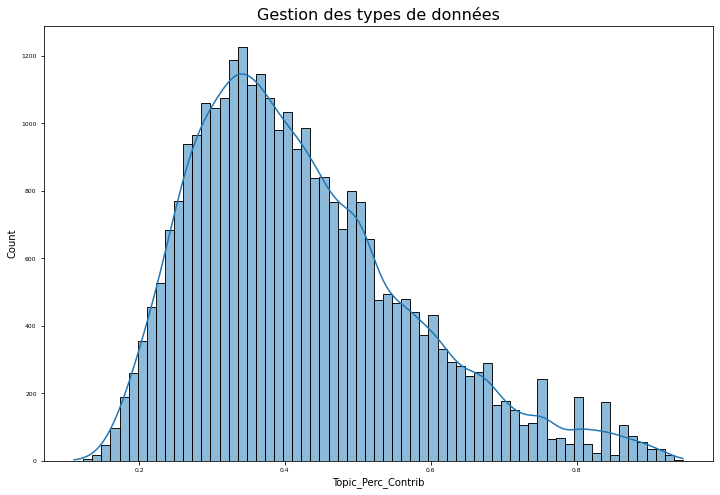

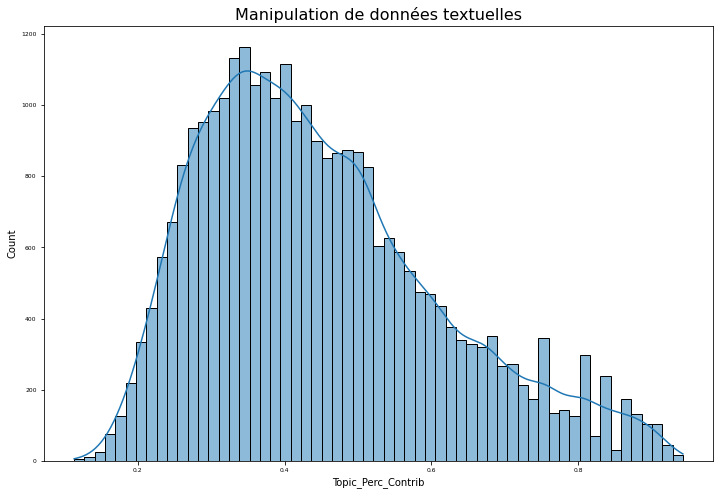

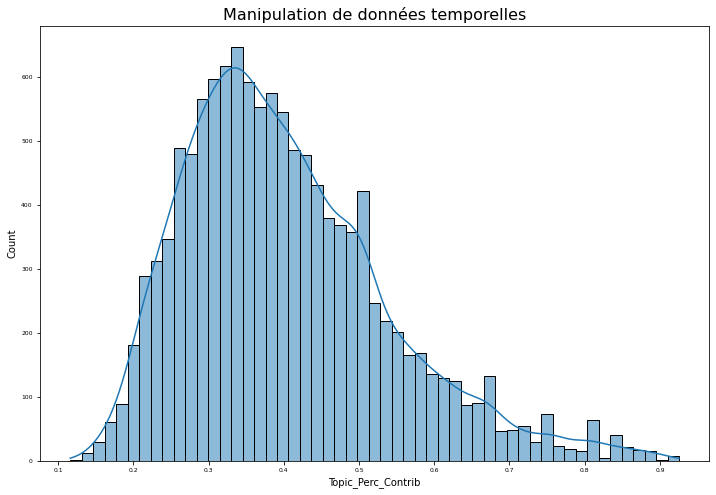

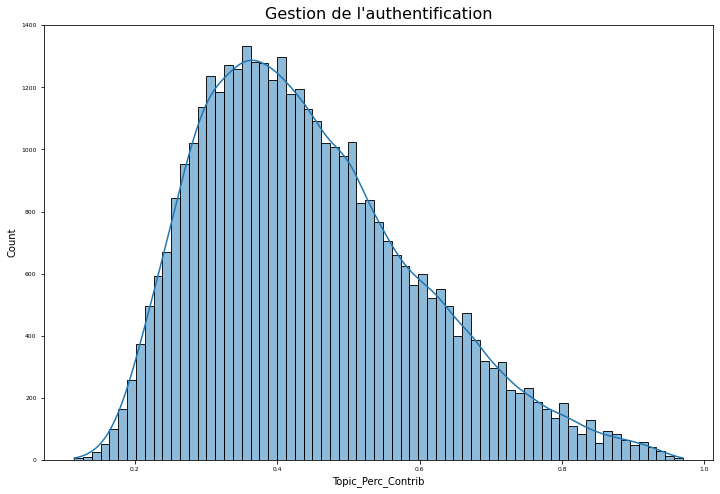

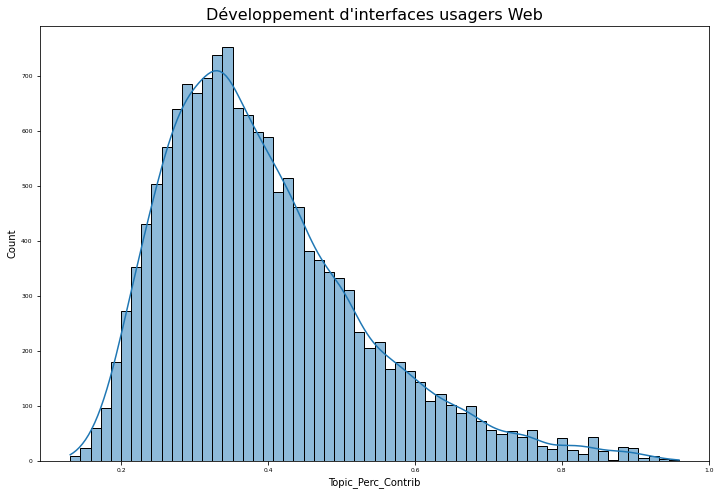

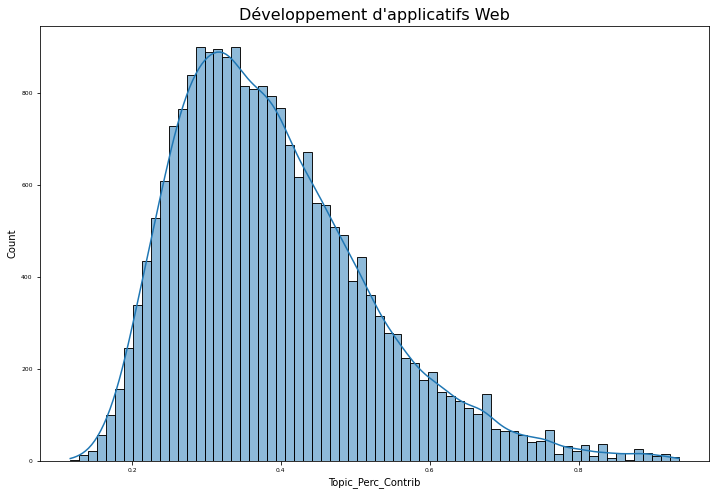

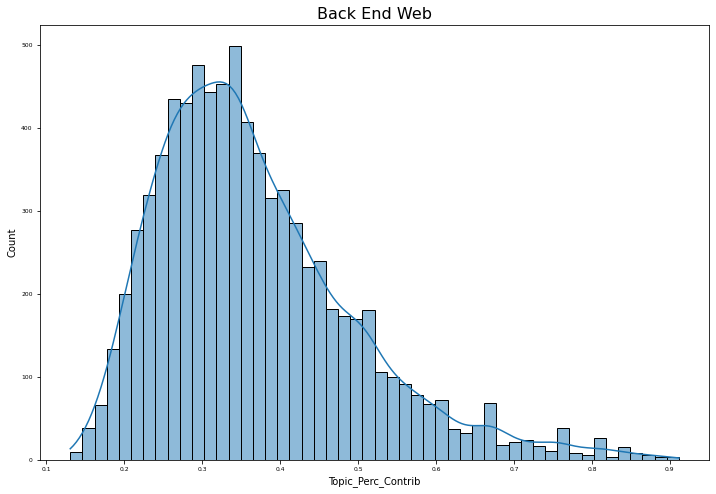

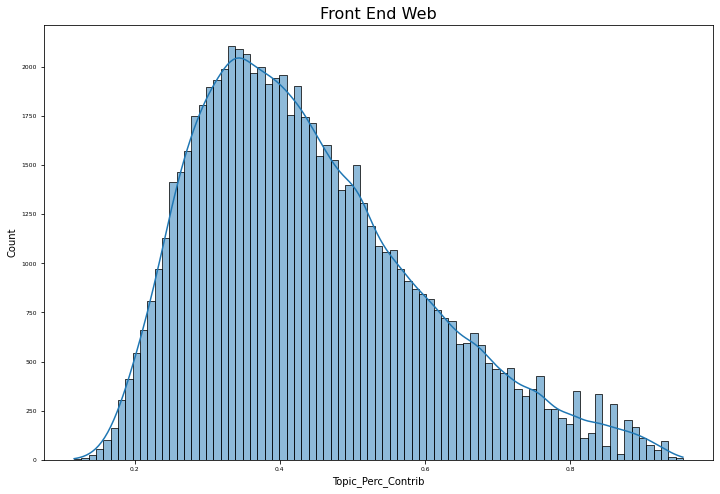

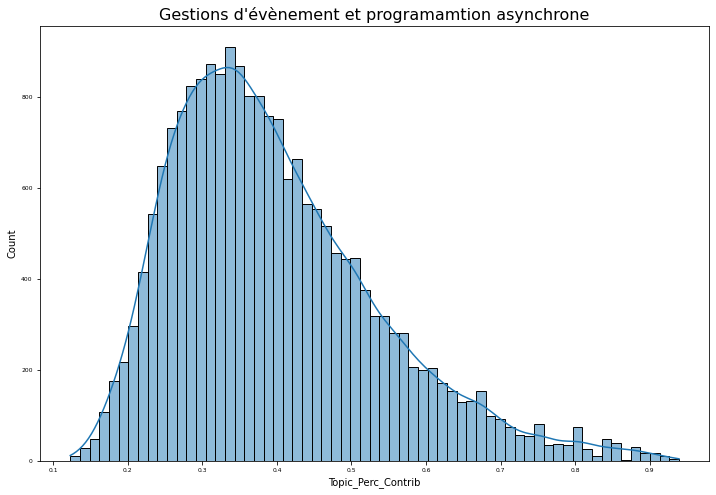

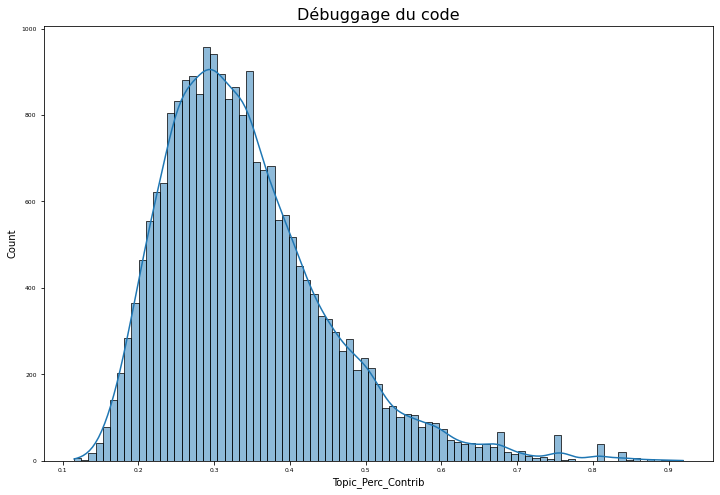

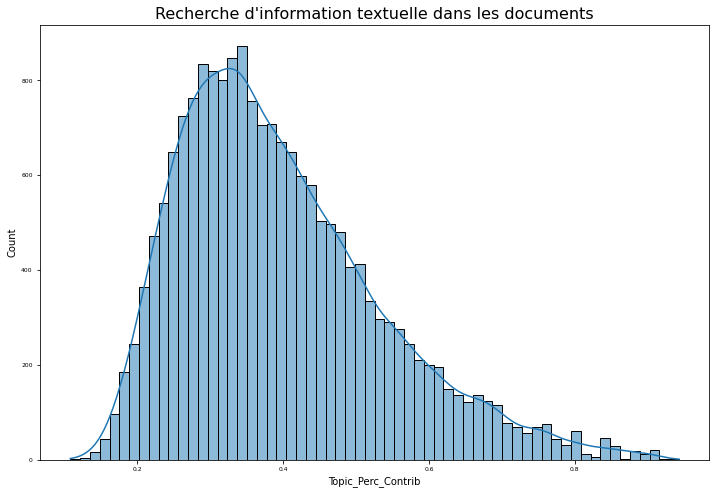

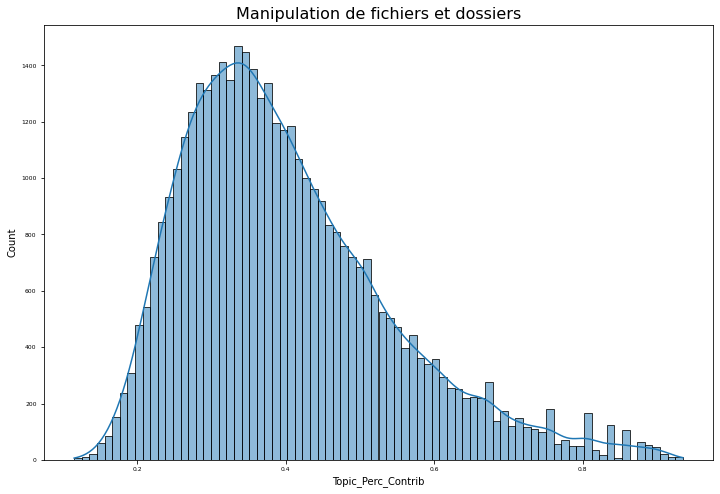

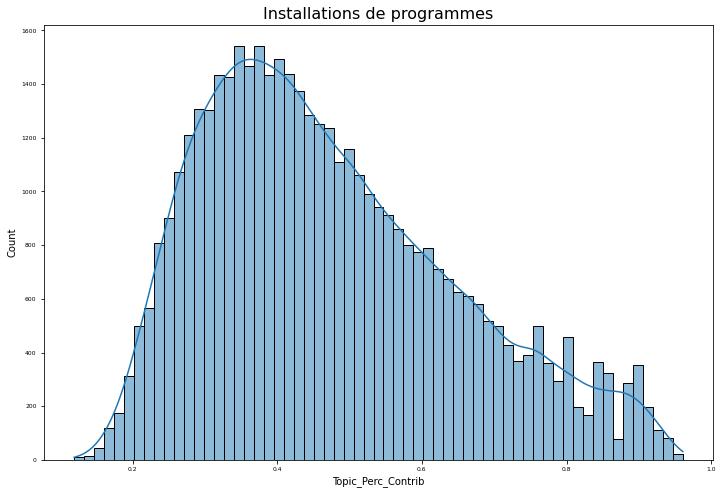

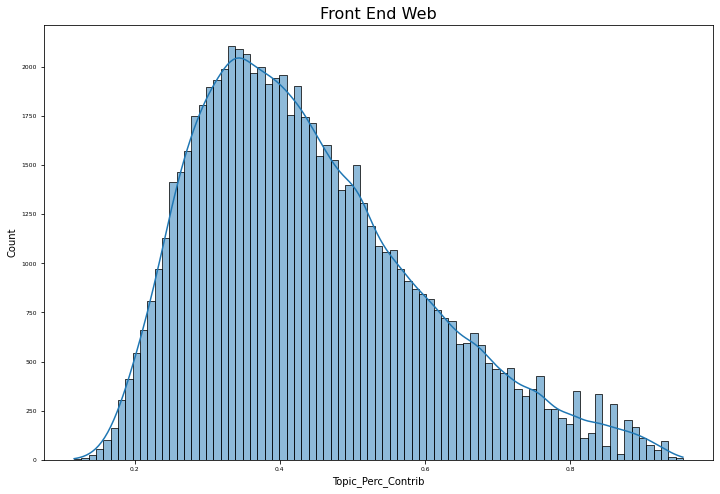

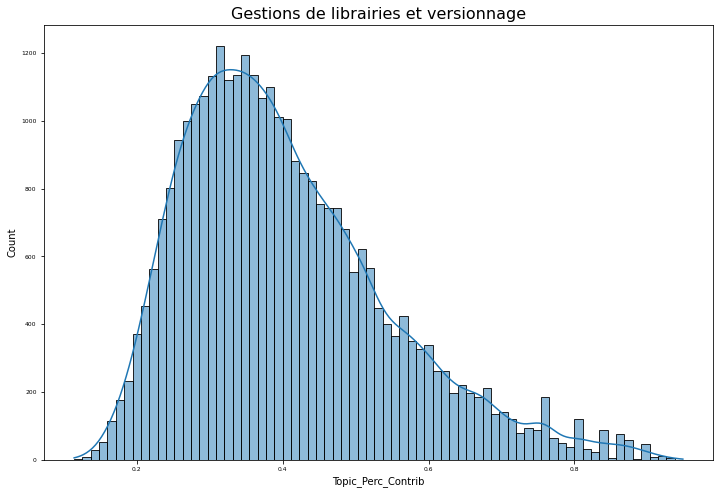

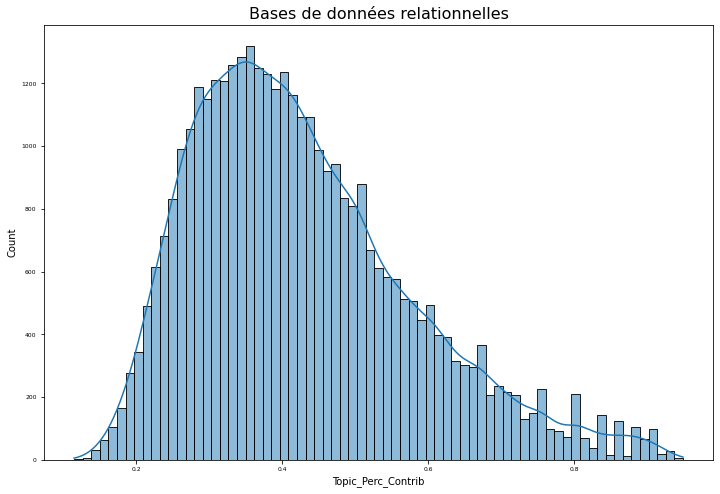

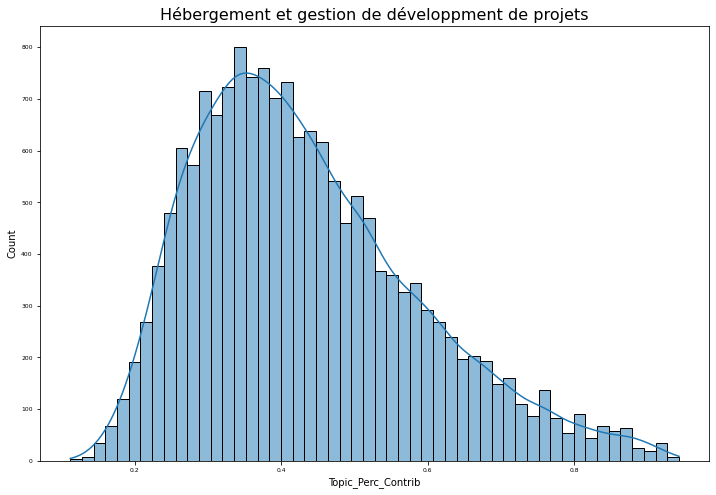

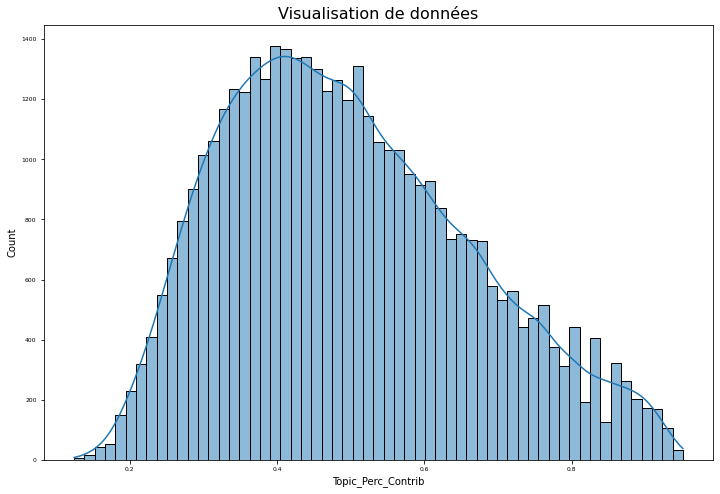

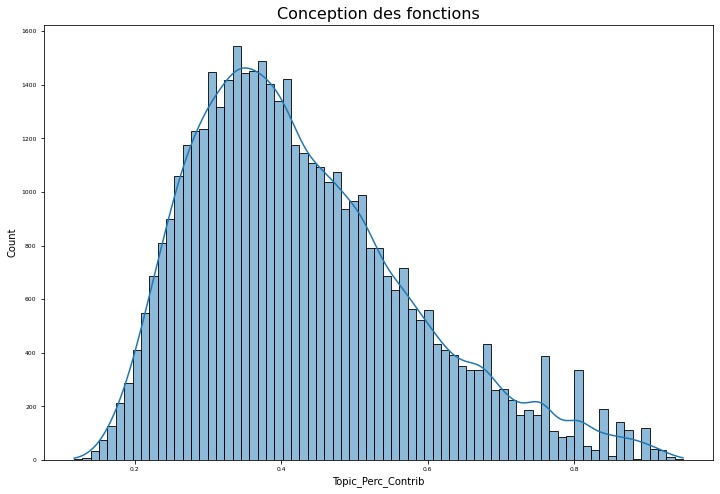

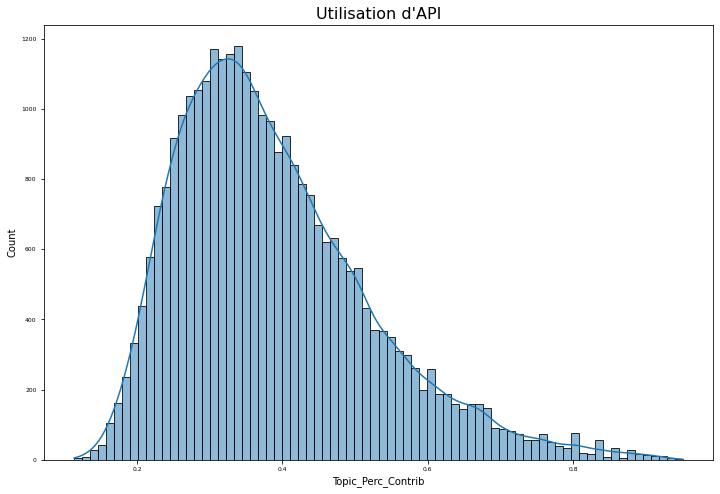

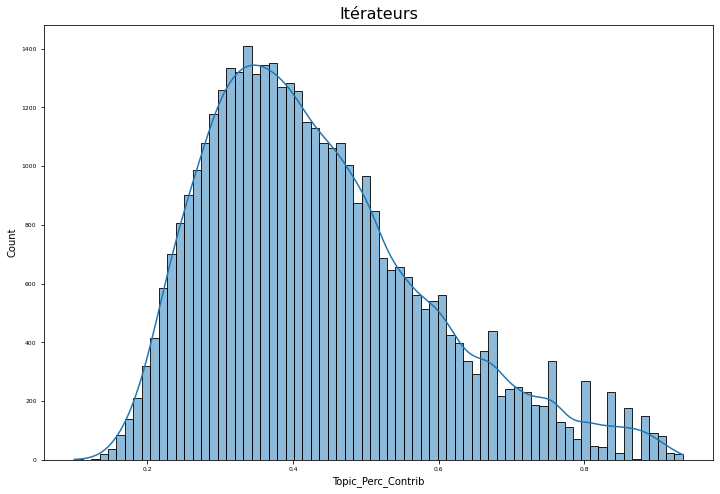

In [204]:
for num, topic in dict_topics_num_title.items():
    
    plt.figure(figsize=(12,8))
    ax = sns.histplot(data=df_topics_tags[df_topics_tags['Topic_title']==topic]['Topic_Perc_Contrib'], kde=True)
    ax.set_title(topic, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=6)
    plt.show()

> Toutes les distributions sont déviantes vers la gauche (petites valeurs), mais celle du thème **Manipulation de données tabulaires/dataframes** est nettement plus représenté pour les hautes valeurs que les autres.

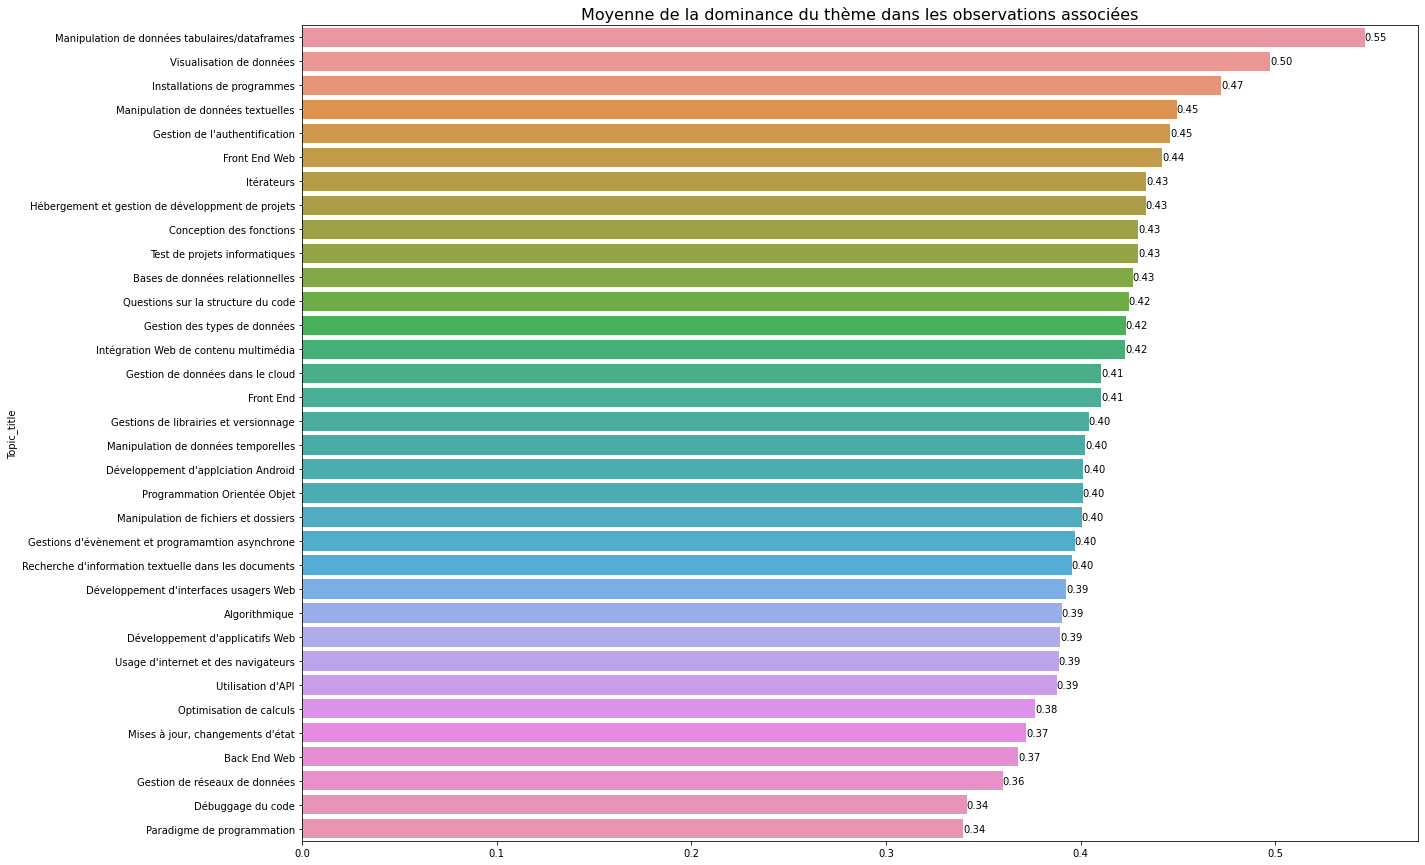

In [214]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=df_topics_tags.groupby(by='Topic_title')['Topic_Perc_Contrib'].mean().sort_values(ascending=False).values,
            y=df_topics_tags.groupby(by='Topic_title')['Topic_Perc_Contrib'].mean().sort_values(ascending=False).index)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title("Moyenne de la dominance du thème dans les observations associées", fontsize=16);

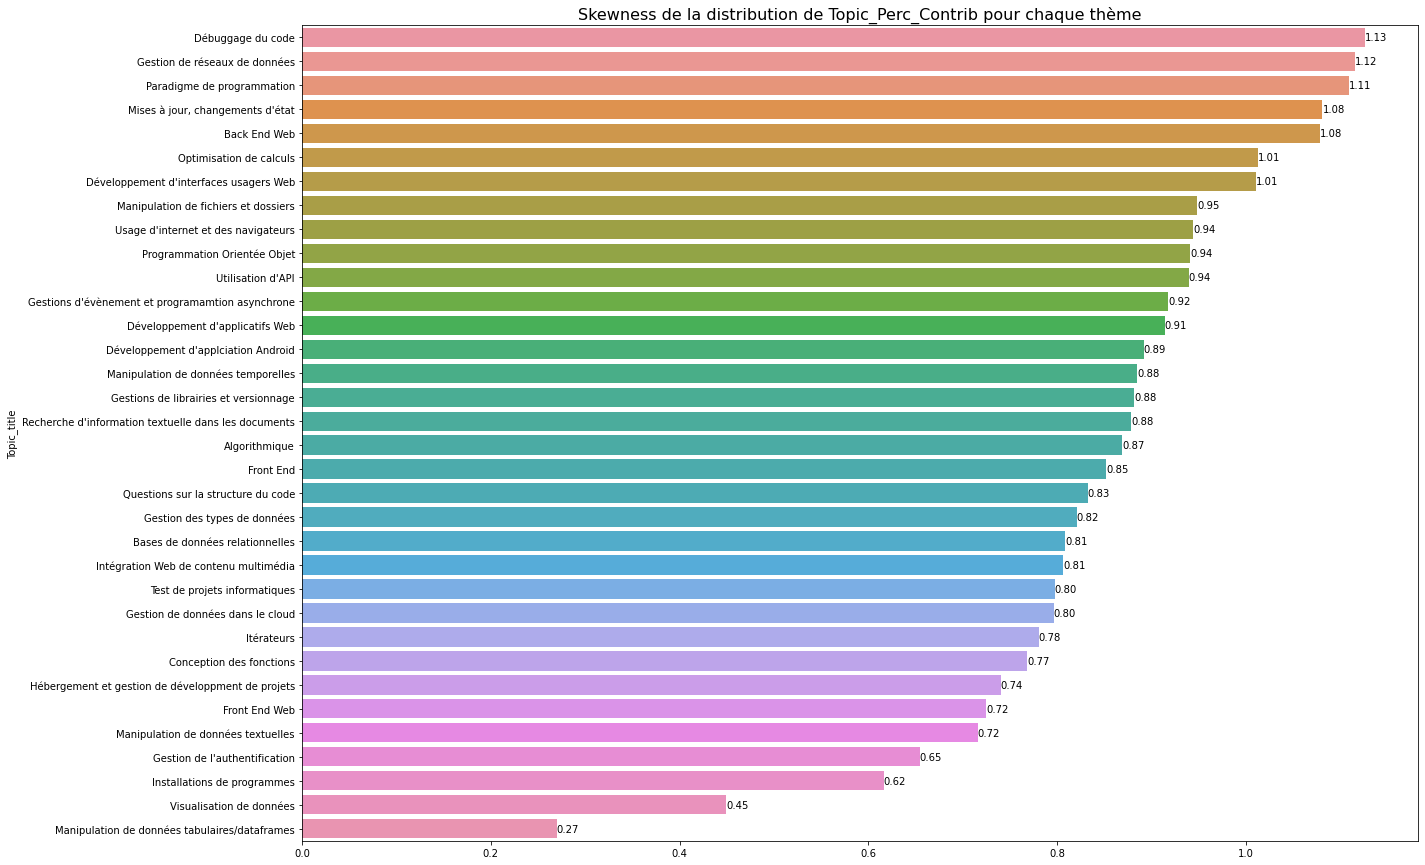

In [231]:
from scipy.stats import skew
plt.figure(figsize=(20,15))
ax = sns.barplot(x=df_topics_tags.groupby(by='Topic_title')['Topic_Perc_Contrib'].apply(lambda x: skew(x, bias=False)).sort_values(ascending=False).fillna(0).values,
            y=df_topics_tags.groupby(by='Topic_title')['Topic_Perc_Contrib'].apply(lambda x: skew(x, bias=False)).sort_values(ascending=False).index)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title("Skewness de la distribution de Topic_Perc_Contrib pour chaque thème", fontsize=16);

> La distribution de **Manipulation de données tabulaires/dataframes** est celle avec la plus grande moyenne et la plus petite asymétrie.

A l'opposé nous avons la distribution du thème **Débuggage du code** qui a la plus faible moyenne et la plus grande asymétrie, et on retrouve que ce thème est quasiment celui qui a le plus faible nombre de documents qui lui sont attribués ayant la valeur maximale de contribution de ce thème.

In [232]:
##################################CONCLUSION SUR le fait que les posts sur les dataframes sont plus interprétables, écrit de manières plus uniformes ?####
##### A vérifier le % de tokens utilisés dans les posts associés à ce thème ####

In [235]:
df_topics_tags['Text_length'] = df_topics_tags['Text'].str.split().apply(len)
df_topics_tags['Tags_nb'] = df_topics_tags['Tags'].apply(len)

### Influence du nombre de tags sur la longueur des posts

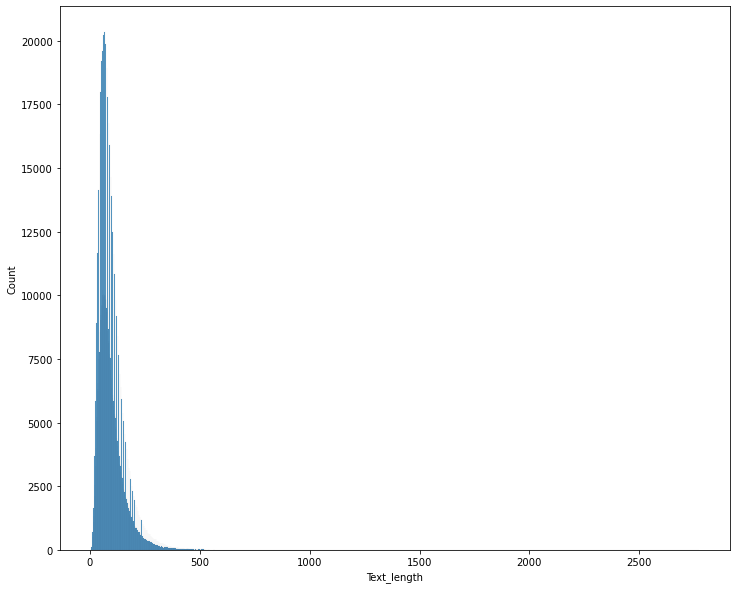

In [101]:
plt.figure(figsize=(12,10))
sns.histplot(data=df_topics_tags['Text_length']);

In [115]:
df_topics_tags['Text_length'].describe()

count    998596.000000
mean         99.992151
std          63.786990
min           4.000000
25%          59.000000
50%          84.000000
75%         123.000000
max        2772.000000
Name: Text_length, dtype: float64

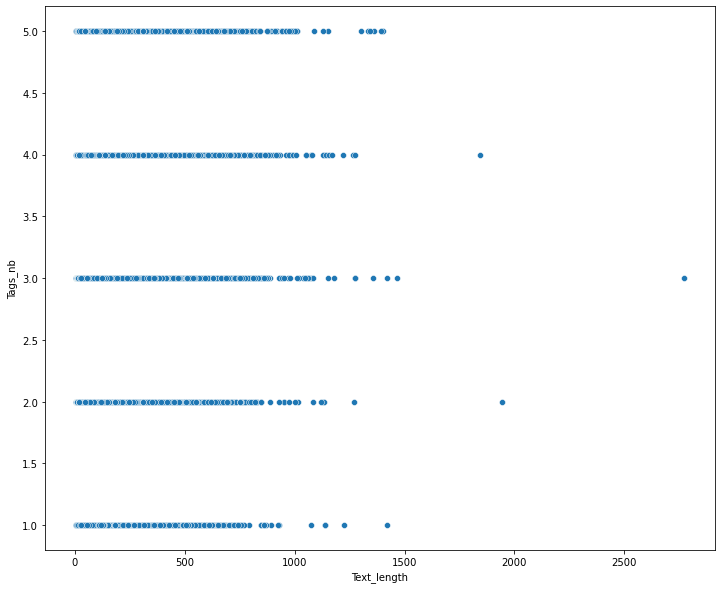

In [100]:
plt.figure(figsize=(12,10))
sns.scatterplot(y=df_topics_tags['Tags_nb'], x=df_topics_tags['Text_length']);

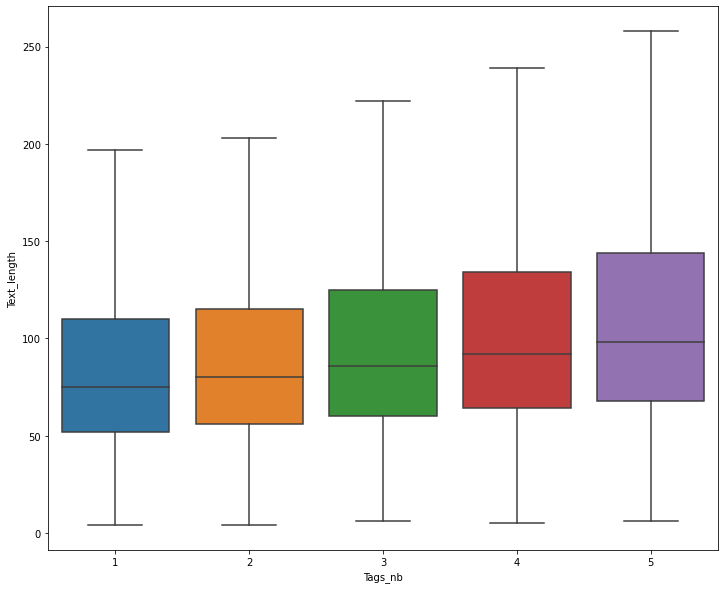

In [11]:
plt.figure(figsize=(12,10))
sns.boxplot(y=df_topics_tags['Text_length'], x=df_topics_tags['Tags_nb'], showfliers=False);

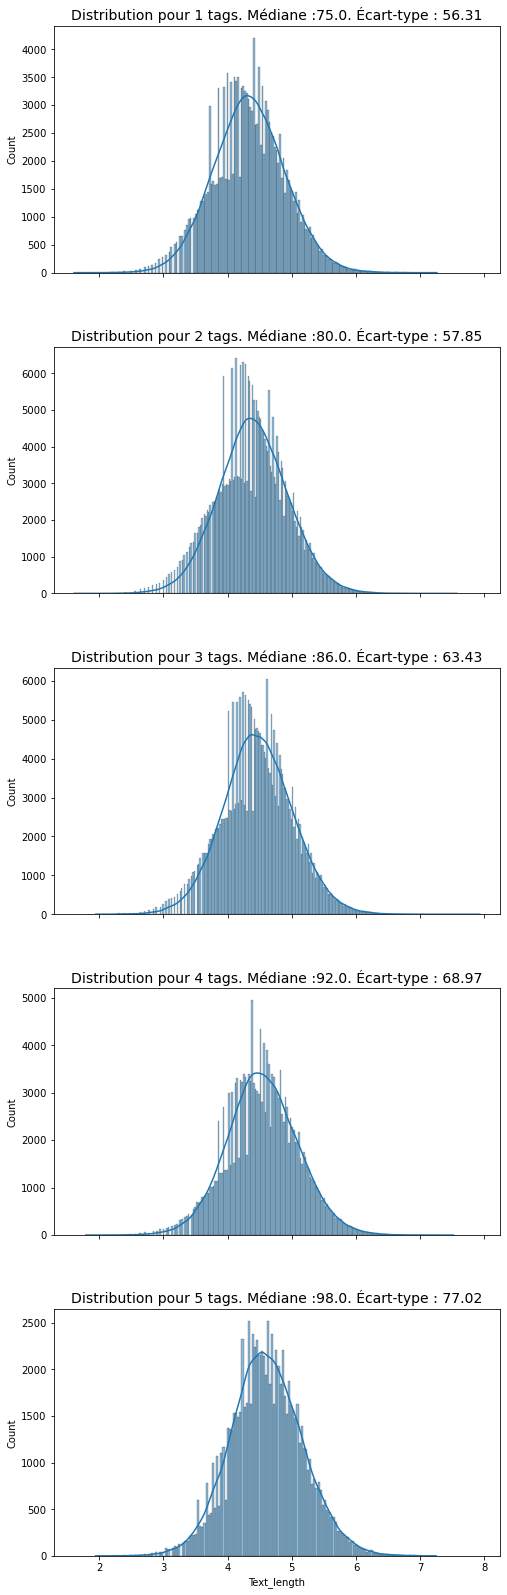

In [48]:
fig, axes = plt.subplots(5,1, figsize=(8, 25), sharex=True)
axes = axes.flatten()

for nb in range(5):
    data = df_topics_tags[df_topics_tags['Tags_nb']==nb+1]['Text_length']
    data_median = round(data.median(),2)
    data_std = round(data.std(),2)
    sns.histplot(data=np.log(data+1), kde=True, ax=axes[nb])
    axes[nb].set_title(f"Distribution pour {nb+1} tags. Médiane :{data_median}. Écart-type : {data_std}", fontsize=14)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
plt.show()

In [31]:
Kruskal_analysis = stats.kruskal(*[df_topics_tags[df_topics_tags['Tags_nb']==nb+1]['Text_length'] for nb in range(5)])
Kruskal_analysis

KruskalResult(statistic=21024.397923806002, pvalue=0.0)

In [46]:
list_permutations = [tuple(y) for y in np.unique([sorted(x) for x in list(itertools.permutations([1, 2, 3, 4, 5], 2))], axis=0)]
list_permutations

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [66]:
for i,j in list_permutations:
    print(f"p-value pour le test d'égalité des médianes {i} / {j} :\n{stats.median_test(df_topics_tags[df_topics_tags['Tags_nb']==i]['Text_length'],df_topics_tags[df_topics_tags['Tags_nb']==j]['Text_length'])[1]}")

p-value pour le test d'égalité des médianes 1 / 2 :
2.5322365208447833e-177
p-value pour le test d'égalité des médianes 1 / 3 :
0.0
p-value pour le test d'égalité des médianes 1 / 4 :
0.0
p-value pour le test d'égalité des médianes 1 / 5 :
0.0
p-value pour le test d'égalité des médianes 2 / 3 :
0.0
p-value pour le test d'égalité des médianes 2 / 4 :
0.0
p-value pour le test d'égalité des médianes 2 / 5 :
0.0
p-value pour le test d'égalité des médianes 3 / 4 :
8.417476472300945e-251
p-value pour le test d'égalité des médianes 3 / 5 :
0.0
p-value pour le test d'égalité des médianes 4 / 5 :
2.1035283216821985e-102


**Conlusion**

Les médianes sont toutes différentes une à une, et le **nombre de tags** est un facteur influent.

In [59]:
df_topics_tags['Tags_nb'].median()

3.0

In [102]:
df_topics_tags['Text_length'].median()

84.0

In [58]:
Contingency_test_analysis = stats.chi2_contingency(Median_test_analysis[3])
Contingency_test_analysis

(13775.798658142361,
 0.0,
 4,
 array([[ 80122.40259224, 149522.15168797, 141369.52052882,
          89940.11148953,  46442.81370144],
        [ 77564.59740776, 144748.84831203, 136856.47947118,
          87068.88851047,  44960.18629856]]))

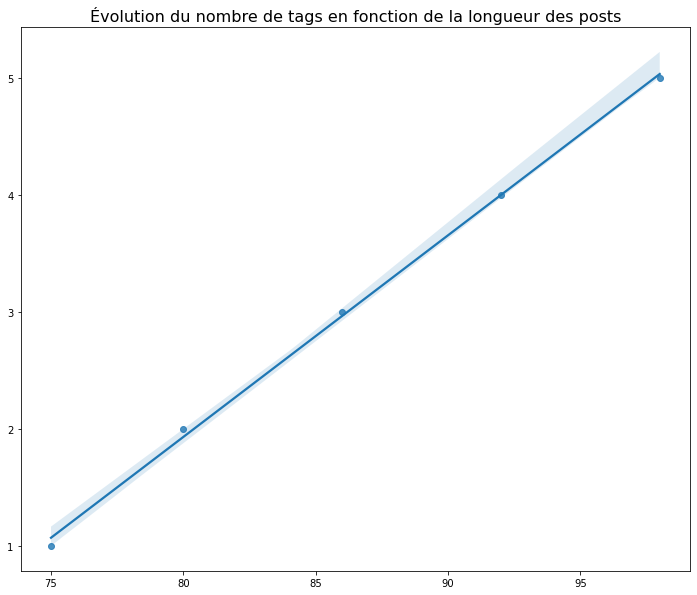

In [80]:
plt.figure(figsize=(12,10))
sns.regplot(y=list(range(1,6)), 
            x=[df_topics_tags[df_topics_tags['Tags_nb']==i+1]['Text_length'].median() for i in range(5)],
            seed=SEED
           );
plt.title("Évolution du nombre de tags en fonction de la longueur des posts", fontsize=16);

> La relation semble **linéaire**.

In [86]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(pd.DataFrame([df_topics_tags[df_topics_tags['Tags_nb']==i+1]['Text_length'].median() for i in range(5)]), pd.DataFrame(list(range(1,6))))

LinearRegression()

In [94]:
lin_reg.coef_[0][0], lin_reg.intercept_[0]

(0.172209026128266, -11.844418052256529)

In [98]:
est_nb_tags = lambda x : lin_reg.coef_[0][0]*x + lin_reg.intercept_[0]

In [117]:
list_text_length_nb_tags_int = [(x-lin_reg.intercept_[0])/lin_reg.coef_[0][0] for x in range(1,6)]
list_text_length_nb_tags_int

[74.58620689655172,
 80.39310344827587,
 86.2,
 92.00689655172414,
 97.81379310344828]

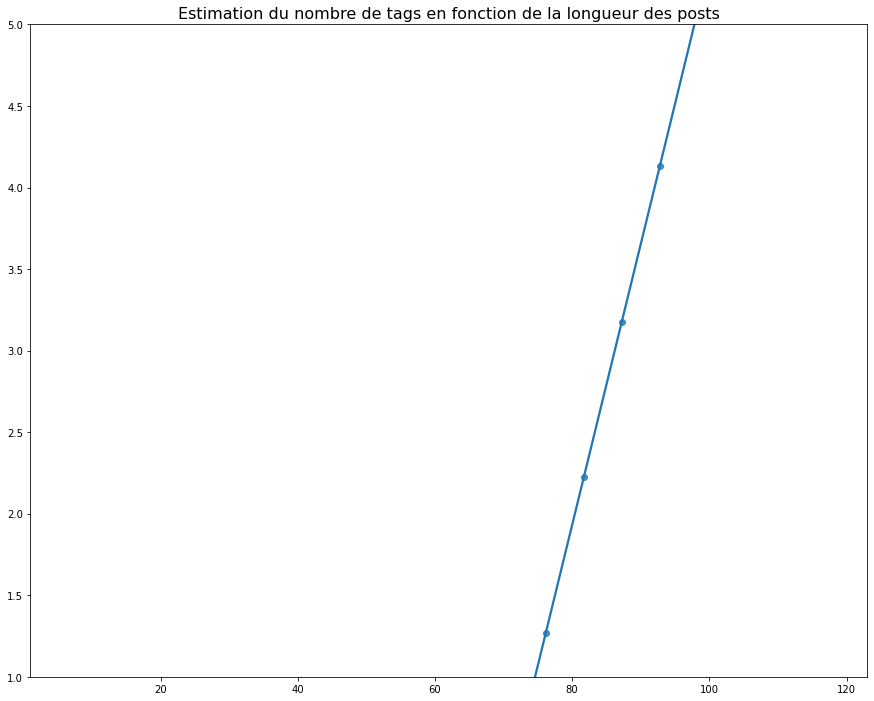

In [116]:
plt.figure(figsize=(15,12))
x_text_length = np.linspace(df_topics_tags['Text_length'].min(), df_topics_tags['Text_length'].max()+1,500)
sns.regplot(x= x_text_length,
            y= [est_nb_tags(x) for x in x_text_length]
           );
plt.ylim(1,5)
plt.xlim(1,123)
plt.title("Estimation du nombre de tags en fonction de la longueur des posts", fontsize=16);

In [240]:
df_topics_tags

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Tags,Topic_title,Text_length,Tags_nb
0,17,0.379639,"date, time, format, year, hour, day, month, mi...",modifying bonita process instance after starte...,[bonita],Manipulation de données temporelles,21,1
1,5,0.182617,"image, code, video, description, game, picture...",what does elevation in drawshadow do exactlyi ...,"[c++, dart, flutter, skia]",Intégration Web de contenu multimédia,195,4
2,33,0.543457,"function, code, work, c, return, example, erro...",how to use a trait object that contains a meth...,[rust],Conception des fonctions,97,1
3,28,0.597656,"button, click, form, user, code, input, work, ...",a way for users to store selections as inputs ...,"[r, shiny, shinyapps]",Front End Web,157,3
4,10,0.333984,"android, device, native, io, screen, code, vie...",how to open downloaded photo using gallery app...,"[expo, gallery, linker, react]",Développement d'applciation Android,154,4
...,...,...,...,...,...,...,...,...
999995,26,0.300293,"file, folder, script, path, code, directory, c...",can you do a pull in a mongodb bulk write whic...,[mongodb],Manipulation de fichiers et dossiers,118,1
999996,33,0.319580,"function, code, work, c, return, example, erro...",non static method cannot be called staticallyi...,"[laravel, php]",Conception des fonctions,122,2
999997,26,0.193726,"file, folder, script, path, code, directory, c...",sorting oslistdirs arbitrary order for desired...,"[list, python, sorting]",Manipulation de fichiers et dossiers,123,3
999998,1,0.451416,"size, number, time, memory, n, limit, algorith...",big o complexity of nested loopwhat could be t...,[big],Algorithmique,28,1


In [7]:
# df_topics_tags.to_pickle("datasets/tests/df_topics_tags.pkl")

df_topics_tags = pd.read_pickle("datasets/tests/df_topics_tags.pkl")

## Choix du modèle non-supervisé

Nous choisissons le modèle **LDA** car en dépit d'une plus faible valeur du score de cohérence *c_uci*, les thèmes qu'il distingue sont beaucoup plus facile à interpréter du point de vue du jugement humain.

De fait, les tags qu'il propose, qui sont les mots les plus représentatifs de chaque thème, auront plus de chance de susciter de l'attention auprès de l'auditoire de StackOverFlow compétent dans les domaines relatifs aux posts des utilisateurs qui utiliseront notre application.

Pour clôturer cette partie, nous pouvons visionner la projection des différents thèmes de notre modèle optimal dans le premier plan factoriel suite à une réduction de dimension avec l'algorithme *Multi-Dimensional Scaling* :

In [76]:
from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [77]:
# vis_lda = pyLDAvis.gensim_models.prepare(LDA_optimal_final, bow_corpus, id2word)
# pyLDAvis.save_html(vis, 'LDA_optimal_viz.html')
display(HTML('LDA_optimal_viz.html'))

# Approche supervisée

Dans cette partie, nous allons procéder en **2 étapes** :

   1. **Vectorisation** : nous allons numériser nos données nettoyées en utilisant les approches : 
        - **TF-IDF**
        - **Doc2Vec**
        - **BERT**
        - **USE**


   2. **Classification Multi-labels** : nous entraînerons et évaluerons ensuite sur les différents jeux de données vectorisés obtenus, les modèles de classification  suivants : 
       - **Random Forest**
       - **KNNClassifier**
       - **Passive-Agressive**
       - **Multinomial Naive Bayes**
       - ainsi qu'un <u>**modèle hybride**</u> entre le **SVM** et le **Multinomial Naive Bayes** censé être plus performant que ces 2 derniers. [1]

[1] https://aclanthology.org/P12-2018.pdf

In [10]:
df_supervised = pd.read_pickle("datasets/tests/lemmatized_datas.pkl")

## Réduction de la dimension de la variable cible

Dans un soucis de réduction de dimensions de notre jeu de données vectorisé, nous n'allons conserver que les posts dont les tags sont une combinaisons des **100 tags les plus fréquents**.

En effet, nous sommes ici dans le cadre d'une **classification multi-labels**, et chaque vecteur cible à la dimension du nombre de labels différents.

In [31]:
tags_count = Counter()
for token in df_supervised['tags'].to_list():
    tags_count.update(token)

In [32]:
tags_count.most_common(100)

[('python', 177112),
 ('javascript', 111290),
 ('reactjs', 56649),
 ('java', 51054),
 ('r', 46681),
 ('pandas', 40665),
 ('html', 39963),
 ('android', 38975),
 ('c#', 37104),
 ('google', 36236),
 ('node', 30565),
 ('css', 29915),
 ('react', 29819),
 ('flutter', 27650),
 ('c++', 27567),
 ('typescript', 25838),
 ('sql', 25015),
 ('php', 23047),
 ('dataframe', 22567),
 ('amazon', 21026),
 ('azure', 19929),
 ('angular', 19263),
 ('spring', 18924),
 ('c', 18660),
 ('arrays', 17856),
 ('django', 17817),
 ('swift', 16741),
 ('ios', 15279),
 ('json', 14162),
 ('apache', 14094),
 ('asp', 14000),
 ('dart', 13787),
 ('vue', 13736),
 ('firebase', 13698),
 ('docker', 13602),
 ('visual', 12570),
 ('kotlin', 12190),
 ('laravel', 12108),
 ('mysql', 12079),
 ('jquery', 12027),
 ('postgresql', 10941),
 ('numpy', 10798),
 ('regex', 10715),
 ('mongodb', 10251),
 ('aws', 9977),
 ('list', 9291),
 ('web', 9153),
 ('tensorflow', 9102),
 ('kubernetes', 8983),
 ('excel', 8818),
 ('swiftui', 8564),
 ('data', 812

In [40]:
list_100_tags = [x[0] for x in tags_count.most_common(100)]
list_100_tags

['python',
 'javascript',
 'reactjs',
 'java',
 'r',
 'pandas',
 'html',
 'android',
 'c#',
 'google',
 'node',
 'css',
 'react',
 'flutter',
 'c++',
 'typescript',
 'sql',
 'php',
 'dataframe',
 'amazon',
 'azure',
 'angular',
 'spring',
 'c',
 'arrays',
 'django',
 'swift',
 'ios',
 'json',
 'apache',
 'asp',
 'dart',
 'vue',
 'firebase',
 'docker',
 'visual',
 'kotlin',
 'laravel',
 'mysql',
 'jquery',
 'postgresql',
 'numpy',
 'regex',
 'mongodb',
 'aws',
 'list',
 'web',
 'tensorflow',
 'kubernetes',
 'excel',
 'swiftui',
 'data',
 'git',
 'string',
 'powershell',
 'linux',
 'selenium',
 'ruby',
 'windows',
 'dplyr',
 'github',
 'rust',
 'matplotlib',
 'go',
 'wordpress',
 'ggplot',
 'bash',
 'express',
 'api',
 'database',
 'vba',
 'function',
 'next',
 'discord',
 'xcode',
 'algorithm',
 'keras',
 'material',
 'dictionary',
 'oracle',
 'image',
 'pyspark',
 'loops',
 'xml',
 'macos',
 'unity',
 'vuejs',
 'npm',
 'scala',
 'machine',
 'datetime',
 'pytorch',
 'unit',
 'csv',
 'ht

In [15]:
load_pickle("list_100_tags")

Variable créée sous le nom 'list_100_tags' 


In [36]:
df_supervised['is_in_tags_100'] = df_supervised['tags'].apply(lambda tags_list: len([tag for tag in tags_list if tag in list_100_tags]) == len(tags_list))

In [14]:
# df_100_tags = df_supervised[df_supervised['is_in_tags_100']][['tokens', 'tags']]
# df_100_tags.to_pickle("datasets/tests/df_100_tags.pkl")
df_100_tags = pd.read_pickle("datasets/tests/df_100_tags.pkl")
df_100_tags

,tokens,tags
2,"[trait, error, circumstance, way, code, object...",[rust]
7,"[alarmmanager, manifest, problem, myalarm, ala...","[android, java]"
9,"[demo, matstepis, event, element, click, stack...","[angular, javascript, typescript]"
16,"[docker, update, parameter, name, network, for...",[docker]
17,"[year, update, item, array, choice, field, sto...","[firebase, google]"
...,...,...
999985,"[year, postgresqli, day, deduct, month, date, ...","[postgresql, sql]"
999992,"[boolean, column, apologize, value, thanks, da...","[dataframe, numpy, pandas, python]"
999995,"[update, bulkwrite, array, script, example, hi...",[mongodb]
999996,"[staticallyi, approach, calculation, rename, b...","[laravel, php]"


In [44]:
vocab_supervised = Counter()
for token in df_100_tags["tokens"]:
    vocab_supervised.update(token)

In [45]:
vocab_supervised.most_common(1000)

[('code', 106360),
 ('error', 71697),
 ('value', 71436),
 ('work', 67751),
 ('data', 54484),
 ('file', 50954),
 ('example', 48295),
 ('column', 47598),
 ('function', 46083),
 ('problem', 44079),
 ('user', 35160),
 ('thanks', 32034),
 ('change', 31979),
 ('time', 31641),
 ('output', 31164),
 ('row', 30521),
 ('list', 29181),
 ('object', 27971),
 ('type', 27456),
 ('name', 27182),
 ('string', 27102),
 ('number', 27027),
 ('question', 26581),
 ('issue', 26232),
 ('array', 25269),
 ('method', 24264),
 ('table', 23725),
 ('line', 21903),
 ('image', 21455),
 ('element', 21420),
 ('page', 21409),
 ('solution', 21333),
 ('return', 20965),
 ('python', 20882),
 ('dataframe', 20500),
 ('class', 20223),
 ('component', 20109),
 ('case', 20008),
 ('need', 18896),
 ('button', 18709),
 ('project', 17998),
 ('input', 17917),
 ('idea', 17422),
 ('update', 17414),
 ('text', 16712),
 ('api', 16370),
 ('field', 16251),
 ('query', 16027),
 ('message', 15841),
 ('check', 15189),
 ('version', 15078),
 ('item'

In [46]:
len(vocab_supervised.values())

455731

On observe que pour un peu moins d'un tiers du nombre d'observations total, nous avons un vocabulaire diminué dans les mêmes proportions.

(**455 731** contre **1 379 766**)

### Limitations matérielles

En raison des limites de nos capacités de mémoire de travail et de nombre de cellules de calculs, nous sommes contraints de réduire la taille de notre jeu de données de travail à **50 000** observations.

En effet, en prenant la totalité des **318 940** observations ci-haut, avec le jeu d'entraînement (80% des observations), nous devons crééer une matrice **TF-IDF** de forme **(379618, 39955)** qui nécessite une occuperait en mémoire un volume de **113. GiB** avec des données de type **float16**...

> En divisant par 6 le nombre d'observations, nous espérons réduire d'un même facteur le vocabulaire, et ramener à des ordres de grandeurs manipulables localement la taille de nos jeux de données.

### Séparation du jeu de données

In [16]:
# df_100_tags_red = df_100_tags.sample(50000)
# df_100_tags_red.to_pickle("datasets/tests/df_100_tags_red.pkl")
df_100_tags_red = pd.read_pickle("datasets/tests/df_100_tags_red.pkl")

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_100_tags_red['tokens'], df_100_tags_red['tags'], test_size=0.2, random_state=SEED)

In [50]:
# X_train.to_pickle("datasets/tests/X_train.pkl")
# X_test.to_pickle("datasets/tests/X_test.pkl")
# y_train.to_pickle("datasets/tests/y_train.pkl")
# y_test.to_pickle("datasets/tests/y_test.pkl")

In [32]:
X_train = pd.read_pickle("datasets/tests/X_train.pkl")
X_test = pd.read_pickle("datasets/tests/X_test.pkl")
y_train = pd.read_pickle("datasets/tests/y_train.pkl")
y_test = pd.read_pickle("datasets/tests/y_test.pkl")

<u>**Il faut nous assurer que nous rencontrons bien tous les tags possibles durant la phase d'entraînement**</u> !!!

In [51]:
y_train

791974    [javascript, reactjs]
985640                    [c++]
580833    [javascript, reactjs]
166913                      [r]
195136             [typescript]
                  ...          
389015                     [c#]
940396    [angular, typescript]
395971                   [http]
408129            [amazon, aws]
126106             [javascript]
Name: tags, Length: 40000, dtype: object

In [52]:
verif_tags = Counter()
for token in y_train.to_list():
    verif_tags.update(token)
len(verif_tags.values())

100

Nous avons bien tous les tags possibles dans notre jeu d'entraînement.

## Vectorisation

### TF-IDF

On entraîne un **dictionnaire** sur les données d'entraînement, ainsi que le modèle de **TF-IDF** sur le **Bag-Of-Words** d'entraînement, et on crée le **Bag_Of_Words** de test séparément.

Nous créons ensuite les **matrices TF-IDF** d'entraînement et de test à partir du modèle **TF-IDF** entraîné appliqué aux vecteurs **Bag-Of-Words** d'une part des documents d'entraînement, d'autre part sur les documents de test.

In [55]:
# Dictionnaire, Bag-Of-Words d'entraînement et entraînement du modèle TF-IDF
# nous prenons bien soin de conserver dans le vocabulaire l'ensemble des tags à prédire !

corpus_train = X_train.to_list()

id2word_train = corpora.Dictionary(corpus_train)
id2word_train.filter_extremes(keep_tokens=list_100_tags)

bow_corpus_train = [id2word_train.doc2bow(doc) for doc in corpus_train]

tfidf = TfidfModel(bow_corpus_train)

vocab = list(id2word_train.values())
len(vocab)

7241

Pour le jeu de test, nous gardons pour chaque document, uniquement les tokens du vocabulaire vu à l'entraînement :

In [56]:
X_test_vocab = pd.DataFrame(X_test)['tokens'].apply(lambda x: [y for y in x if y in vocab])

In [57]:
# Bag-Of-Words de test

corpus_test = X_test_vocab.to_list()
bow_corpus_test = [id2word_train.doc2bow(doc) for doc in corpus_test]

Nous pouvons maintenant obtenir les vecteurs **TF-IDF** de nos jeux d'entraînement et de test :

In [58]:
tfidf_corpus_train = [tfidf[bow] for bow in bow_corpus_train]

tfidf_corpus_test = [tfidf[bow] for bow in bow_corpus_test]

Puis les matrices **TF-IDF** associées :

In [59]:
X_train_tfidf = pd.DataFrame(data=np.zeros((len(tfidf_corpus_train), len(vocab))),
                             index=X_train.index,
                             columns=vocab
                            )

list_train_index = list(X_train.index)

for doc_index in range(len(list_train_index)):
    for token_index, freq in tfidf[bow_corpus_train[doc_index]]:
        X_train_tfidf.loc[list_train_index[doc_index], id2word_train[token_index]] = freq

X_train_tfidf

,box,change,console,default,error,event,export,fire,home,onchange,...,runing,minutesi,previewview,inout,cellphone,profilejs,wc,bump,createdby,sugar
791974,0.274742,0.149723,0.229799,0.225452,0.097935,0.240495,0.308918,0.366495,0.31019,0.397562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
985640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580833,0.000000,0.000000,0.000000,0.000000,0.118314,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940396,0.000000,0.000000,0.000000,0.000000,0.202916,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
408129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
X_train_tfidf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 791974 to 126106
Columns: 7241 entries, box to sugar
dtypes: float64(7241)
memory usage: 2.2 GB


> En divisant par **4** la taille de notre jeu de données de départ, nous avons réduit par **3** notre vocabulaire, soit une réduction par **12** de la taille de notre matrice **TF-IDF** et par **16** l'espace en mémoire.

In [61]:
X_test_tfidf = pd.DataFrame(data=np.zeros((len(tfidf_corpus_test), len(vocab))),
                             index=X_test.index,
                             columns=vocab
                            )

list_test_index = list(X_test.index)

for doc_index in range(len(list_test_index)):
    for token_index, freq in tfidf[bow_corpus_test[doc_index]]:
        X_test_tfidf.loc[list_test_index[doc_index], id2word_train[token_index]] = freq

X_test_tfidf

,box,change,console,default,error,event,export,fire,home,onchange,...,runing,minutesi,previewview,inout,cellphone,profilejs,wc,bump,createdby,sugar
570244,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
658972,0.0,0.000000,0.0,0.0,0.059674,0.0,0.0,0.0,0.189005,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
560643,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
760231,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71319,0.0,0.000000,0.0,0.0,0.120314,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795292,0.0,0.000000,0.0,0.0,0.081893,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
804764,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
839304,0.0,0.118671,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404411,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# X_train_tfidf.to_pickle("datasets/tests/X_train_tfidf.pkl")
# X_test_tfidf.to_pickle("datasets/tests/X_test_tfidf.pkl")
# save_pickle(corpus_train, "corpus_train")
# save_pickle(id2word_train, "id2word_train")
# save_pickle(bow_corpus_train, "bow_corpus_train")
# save_pickle(tfidf, "tfidf")
# save_pickle(tfidf_corpus_train, "tfidf_corpus_train")
# save_pickle(tfidf_corpus_test, "tfidf_corpus_test")

Fichier enregistré sous le nom 'corpus_train' 
Fichier enregistré sous le nom 'id2word_train' 
Fichier enregistré sous le nom 'bow_corpus_train' 
Fichier enregistré sous le nom 'tfidf' 
Fichier enregistré sous le nom 'tfidf_corpus_train' 
Fichier enregistré sous le nom 'tfidf_corpus_test' 


In [7]:
X_train_tfidf = pd.read_pickle("datasets/tests/X_train_tfidf.pkl")
X_test_tfidf = pd.read_pickle("datasets/tests/X_test_tfidf.pkl")

### Doc2Vec

Pour l'entraînement de notre modèle **Doc2Vec**, nous partons de notre corpus nettoyés, mais non lemmatisé.

In [17]:
df_no_lemmas = pd.read_pickle("datasets/tests/df_datas_nouns.pkl")
df_no_lemmas_red = df_no_lemmas.loc[df_100_tags_red.index]

In [64]:
df_no_lemmas_red

,tokens,tags
375306,"[workingi, mysql, regex, test, marks, database...","[mysql, regex]"
807325,"[size, population, number, truncate, functions...",[r]
31013,"[urli, download, upload, uploaded, uploads, pr...","[firebase, html, javascript]"
594745,"[authenticate, username, userpool, attribute, ...","[amazon, aws]"
599083,"[fields, playground, figure, correctlyi, types...",[typescript]
...,...,...
625692,"[internet, oauth, stack, issue, controller, cl...",[spring]
772060,"[getxcontroller, initialized, stack, orderscon...","[dart, flutter]"
955087,"[change, component, parent, logout, question, ...","[javascript, vue, vuejs]"
105665,"[data, vueconfigjs, project, outputs, json, fo...","[vue, webpack]"


In [65]:
df_no_lemmas_red['tokens'] = df_no_lemmas_red['tokens'].str.join(' ')
df_no_lemmas_red

,tokens,tags
375306,workingi mysql regex test marks database javas...,"[mysql, regex]"
807325,size population number truncate functions solu...,[r]
31013,urli download upload uploaded uploads printed ...,"[firebase, html, javascript]"
594745,authenticate username userpool attribute advan...,"[amazon, aws]"
599083,fields playground figure correctlyi types code...,[typescript]
...,...,...
625692,internet oauth stack issue controller class se...,[spring]
772060,getxcontroller initialized stack orderscontrol...,"[dart, flutter]"
955087,change component parent logout question navbar...,"[javascript, vue, vuejs]"
105665,data vueconfigjs project outputs json folder i...,"[vue, webpack]"


In [66]:
df_no_lemmas_red.columns = ['text', 'tags']

In [67]:
from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument

In [68]:
train_df = df_no_lemmas_red.loc[X_train.index]
test_df = df_no_lemmas_red.loc[X_test.index]

In [69]:
train_tagged_df = train_df.apply(lambda doc: TaggedDocument(words=doc['text'].split(), tags=doc['tags']), axis=1)
test_tagged_df = test_df.apply(lambda doc: TaggedDocument(words=doc['text'].split(), tags=doc['tags']), axis=1)

In [70]:
def Doc2VecTraining(train_tagged_df, no_epochs):
    
    ## building a distributed bag of words model 
    
    print("Construction du modèle, apprentissage du vocabulaire")
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=2, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged_df.values)])
    
    ## training the model
    
    print("Entraînement du modèle durant", no_epochs, "époques" )
    for epoch in trange(no_epochs):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged_df.values)]), 
                total_examples=len(train_tagged_df.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    return model_dbow

In [71]:
doc2vec = Doc2VecTraining(train_tagged_df, 30)

Construction du modèle, apprentissage du vocabulaire


  0%|          | 0/40000 [00:00<?, ?it/s]

Entraînement du modèle durant 30 époques


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

In [72]:
# enregistrement du modèle doc2vec

# doc2vec_file = datapath("doc2vec")
# doc2vec.save(doc2vec_file)

doc2vec = Doc2Vec.load(doc2vec_file)

On peut désormais créer nos données d'entraînement et de test pour nos modèles de classification :

In [73]:
def doc2vec_features(model, tagged_dataset):
    sents = tagged_dataset.values
    list_features = [model.infer_vector(doc.words) for doc in sents]
    return list_features

In [74]:
list_feat_train_doc2vec = doc2vec_features(doc2vec, train_tagged_df)

In [75]:
list_feat_test_doc2vec = doc2vec_features(doc2vec, test_tagged_df)

In [8]:
X_train_doc2vec = pd.DataFrame(data=list_feat_train_doc2vec, index=train_df.index)

X_test_doc2vec = pd.DataFrame(data=list_feat_test_doc2vec, index=test_df.index)

NameError: name 'list_feat_train_doc2vec' is not defined

In [77]:
# X_train_doc2vec.to_pickle("datasets/tests/X_train_doc2vec.pkl")
# X_test_doc2vec.to_pickle("datasets/tests/X_test_doc2vec.pkl")

In [9]:
X_train_doc2vec = pd.read_pickle("datasets/tests/X_train_doc2vec.pkl")
X_test_doc2vec = pd.read_pickle("datasets/tests/X_test_doc2vec.pkl")

## BERT

In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

C:\Users\jkomb\anaconda3.2022\envs\new_env\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
C:\Users\jkomb\anaconda3.2022\envs\new_env\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [8]:
# Fonction de préparation des sentences

def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [30]:
# Fonction de création des features

def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    start = timeit.default_timer()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                               bert_tokenizer, 
                                                                               max_length)
        
        outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
        last_hidden_states = outputs.last_hidden_state
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    duration = round(timeit.default_timer() - start,0)
    print("temps traitement : ", duration)
     
    return features_bert, last_hidden_states_tot

In [ ]:
max_length = df_supervised['tokens'].map(len).max()
batch_size = 500

MODEL_PATH = Path() / "models" / "bert-base-uncased"

bert = TFAutoModel.from_pretrained(MODEL_PATH, from_pt=True)

In [34]:
sentences_train = pd.DataFrame(X_train)['tokens'].str.join(' ').to_list()
sentences_test = pd.DataFrame(X_test)['tokens'].str.join(' ').to_list()

In [ ]:
# Création des features

X_train_bert, last_hidden_states_tot_train = feature_BERT_fct(bert, MODEL_PATH, sentences_train, max_length, batch_size)

X_test_bert, last_hidden_states_tot_test = feature_BERT_fct(bert, MODEL_PATH, sentences_test, max_length, batch_size)

loading configuration file models\bert-base-uncased\config.json
Model config BertConfig {
  "_name_or_path": "models\\bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file models\bert-base-uncased\config.json
Model config BertConfig {
  "_name_or_path": "mod

1/1 [==============================] - 461s 461s/step


## USE

In [ ]:
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    start = timeit.default_timer()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    duration = round(timeit.default_timer() - start,0)
    return features

In [ ]:
X_train_use = feature_USE_fct(sentences_train, batch_size)

X_test_use = feature_USE_fct(sentences_test, batch_size)

## Mise en forme de la cible pour la classification multi-label

Afin de permettre à nos modèles d'appréhender la multiplicité des labels à prédire, nous allons transformer notre valeur cible en un tableau binaire avec autant de colonne que de labels (300) et avec spour chaque ligne un 1 si l'observation possède le label en colone, un 0 sinon.

In [107]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=list_100_tags)

In [108]:
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.transform(y_test)

In [109]:
# save_pickle(y_train_mlb, "y_train_mlb")
# save_pickle(y_test_mlb, "y_test_mlb")

Fichier enregistré sous le nom 'y_train_mlb' 
Fichier enregistré sous le nom 'y_test_mlb' 


In [10]:
load_pickle("y_train_mlb")
load_pickle("y_test_mlb")

Variable créée sous le nom 'y_train_mlb' 
Variable créée sous le nom 'y_test_mlb' 


## Évaluation des modèles de classification

Afin de contourner le problème frontal de classification multi-label qui n'est pas supporté nativement par tous les modèles de classifieur, nous allons utiliser la classe 

In [61]:
from sklearn.base import clone

from sklearn.metrics import classification_report, jaccard_score

from sklearn.model_selection import KFold

# modèles nativements multilabels

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# modèles supportant nativement la classification multi-classe "One-Vs-The-Rest"

from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.svm import LinearSVC

from sklearn.linear_model import PassiveAggressiveClassifier

In [12]:
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=SEED, verbose=5)
kn_clf = KNeighborsClassifier(n_jobs=4)

gb_clf = OneVsRestClassifier(HistGradientBoostingClassifier(max_depth=5, verbose=1), n_jobs=4, verbose=1)
sgd_clf = OneVsRestClassifier(make_pipeline(StandardScaler(),
                    SGDClassifier(n_jobs=-1, random_state=SEED)), n_jobs=4, verbose=1)
lin_svc_clf = OneVsRestClassifier(make_pipeline(StandardScaler(),
                    LinearSVC(random_state=SEED, verbose=1)), n_jobs=4, verbose=1)
pass_agg_clf = OneVsRestClassifier(PassiveAggressiveClassifier(n_jobs=4, random_state=SEED), n_jobs=4, verbose=5)

In [98]:
models_to_train = {
                   'RandomForest':rf_clf,
                   'KNeighboors':kn_clf,
                   #'GradientBoosting':gb_clf,
                   #'GradientDescent':sgd_clf,
                   #'LinearSVC':lin_svc_clf,
                   'PassiveAggressive':pass_agg_clf
                  }

kfold = KFold(n_splits=3, shuffle=True, random_state=SEED)

dict_eval_tfidf = dict()
dict_eval_doc2vec = dict()

In [53]:
def mean_df(*list_df):
    if list_df:
        results = list_df[0]
        for i in range(1,len(list_df)):
            results += list_df[i]
        return results/len(list_df)
    else:
        None

In [225]:
def cross_val_models(X_train, dict_name):

    X = X_train.copy()
    
    y = y_train_mlb.copy()
    
    k = np.shape(X_train)[1]
    
    for mdl_name, model in models_to_train.items():
        
        training_durations = list()
        df_class_reports = list()
        jaccard_similiraties = list()
        
        i=0
        
        print(f"Début de l'entraînement du modèle {mdl_name}..\n")
        
        for train_index, test_index in kfold.split(X):
            
            print(f"\tPasse n°{i+1} de la validation croisée\n")
            
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            
            mdl.fit(X.iloc[train_index], y[train_index])
            
            fit_duration =  round(timeit.default_timer() - start_fit_time, 2)
            
            training_durations.append(fit_duration)
            print(f"\t\tDurée de l'entraînement n°{i+1} : {fit_duration}secondes\n")
            i+=1
            
            y_pred = mdl.predict(X.iloc[test_index])
            
            print(f"\t\tÉvaluation du modèle\n")
            class_report_df = pd.DataFrame(data=classification_report(y[test_index], y_pred, 
                                                                      target_names=list_100_tags, 
                                                                      zero_division=0, output_dict=True
                                                                     )
                                          )
            jac_sim_df = pd.DataFrame(data=jaccard_score(y[test_index], y_pred, average=None).reshape(1,-1), 
                                      columns=list_100_tags, 
                                      index=['jaccard_score'])
                                                      
            for avg_mode in ['micro', 'macro', 'weighted', 'samples']:
                jac_sim_df[avg_mode+' avg'] = jaccard_score(y[test_index], y_pred, average=avg_mode)
            print(f"\t\tEnregistrement des métriques d'évaluation...\n")    
            df_class_reports.append(pd.concat([class_report_df, jac_sim_df]))
        
        if dict_name in globals():
            globals()[dict_name][mdl_name] = dict()
            globals()[dict_name][mdl_name]['training_duration'] = np.mean(training_durations)
            globals()[dict_name][mdl_name]['avg_class_report'] = mean_df(*df_class_reports)
        else:
            globals()[dict_name] = dict()
            globals()[dict_name][mdl_name] = dict()
            globals()[dict_name][mdl_name]['training_duration'] = np.mean(training_durations)
            globals()[dict_name][mdl_name]['avg_class_report'] = mean_df(*df_class_reports)
    
    print("Évaluation des modèles terminée.\n")
    print(f"Les résultats ont été enregistrés dans la variable '{dict_name}'.")

In [ ]:
def display_results(**dict_results):
    
    for mdl_name in dict_results.keys():
        print(mdl_name+'\n')
        print(f"Durée moyenne d'entraînement : {dict_results[mdl_name]['training_duration']} secondes.")
        display(dict_results[mdl_name]['avg_class_report'])
        print('\n')

Nous allons réaliser une validation croisée sur nos 2 jeux d'entraînement obtenus par différentes **features extractions** pour valider le modèle que nous allons retenir pour effectuer les prédictions :

In [108]:
cross_val_models(X_train_tfidf, 'dict_eval_tfidf')

Début de l'entraînement du modèle RandomForest..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


		Durée de l'entraînement n°2 : 70.22secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.7s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


		Durée de l'entraînement n°3 : 62.88secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.5s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   60.0s finished


		Durée de l'entraînement n°4 : 61.47secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.9s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°2 : 3.53secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°3 : 3.32secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée

		Durée de l'entraînement n°4 : 3.45secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  5.7min finished


		Durée de l'entraînement n°2 : 341.59secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  5.6min finished


		Durée de l'entraînement n°3 : 337.5secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  5.8min finished


		Durée de l'entraînement n°4 : 346.41secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...



In [109]:
for mdl_name in dict_eval_tfidf.keys():
    print(mdl_name+'\n')
    display(dict_eval_tfidf[mdl_name]['training_duration'])
    display(dict_eval_tfidf[mdl_name]['avg_class_report'])
    print('\n')

RandomForest



64.85666666666667

,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.856646,0.797680,0.862559,0.834474,0.943762,0.884273,0.764712,0.933571,0.729493,0.903801,...,0.000000,0.783333,0.942610,0.0,0.000000,0.875758,0.890172,0.663996,0.802562,0.537827
recall,0.696548,0.231621,0.391599,0.187689,0.474704,0.783720,0.275427,0.514054,0.049606,0.500133,...,0.000000,0.071448,0.304671,0.0,0.000000,0.126316,0.359883,0.222956,0.359883,0.396778
f1-score,0.768294,0.358836,0.537703,0.306213,0.631233,0.830941,0.404440,0.662985,0.092821,0.643413,...,0.000000,0.129425,0.459091,0.0,0.000000,0.216974,0.512548,0.304692,0.461633,0.435741
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.0,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_similairty,0.623814,0.218724,0.367986,0.180868,0.461471,0.710884,0.253496,0.495923,0.048707,0.474439,...,0.000000,0.069705,0.298713,0.0,0.000000,0.122643,0.344588,0.215605,0.340383,0.383233




KNeighboors



3.4333333333333336

,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.774369,0.623499,0.845578,0.562055,0.887939,0.811610,0.655898,0.913896,0.708827,0.920269,...,0.000000,0.791667,0.847222,0.166667,0.857143,0.925926,0.805461,0.703452,0.771380,0.349756
recall,0.387281,0.152479,0.267739,0.181372,0.264653,0.399323,0.144432,0.333901,0.067882,0.257594,...,0.000000,0.095117,0.174491,0.006173,0.120223,0.139796,0.235887,0.177423,0.235887,0.256243
f1-score,0.509150,0.240818,0.401308,0.260885,0.401966,0.528103,0.232051,0.485233,0.122299,0.397787,...,0.000000,0.166986,0.283909,0.011905,0.207278,0.242679,0.361296,0.267230,0.344120,0.280560
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.000000,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_similairty,0.344543,0.138020,0.253512,0.151460,0.254059,0.362415,0.132636,0.322420,0.065662,0.250778,...,0.000000,0.091569,0.169204,0.006061,0.116442,0.138620,0.221977,0.169437,0.221103,0.242971




PassiveAggressive



341.8333333333333

,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.757757,0.545894,0.579293,0.439963,0.797544,0.800792,0.488665,0.683721,0.381283,0.781226,...,0.277778,0.656237,0.828680,0.077172,0.608696,0.800037,0.658527,0.626320,0.660541,0.627551
recall,0.689168,0.435086,0.688724,0.391884,0.703144,0.744910,0.514652,0.702879,0.332386,0.635049,...,0.020679,0.494866,0.549717,0.045385,0.314317,0.544049,0.566346,0.473964,0.566346,0.601805
f1-score,0.719109,0.471759,0.627044,0.412607,0.745734,0.771111,0.492883,0.690737,0.350347,0.698307,...,0.038492,0.563126,0.653233,0.056993,0.414141,0.646259,0.608772,0.528353,0.601681,0.578209
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.000000,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_similairty,0.561492,0.309169,0.456973,0.259942,0.594642,0.627610,0.327278,0.527692,0.212447,0.536820,...,0.019841,0.393193,0.488509,0.029966,0.272847,0.479195,0.437586,0.397532,0.454726,0.494770


In [110]:
cross_val_models(X_train_doc2vec, 'dict_eval_doc2vec')

Début de l'entraînement du modèle RandomForest..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°2 : 213.41secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°3 : 214.75secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°4 : 215.29secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.7s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°2 : 0.17secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°3 : 0.16secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée

		Durée de l'entraînement n°4 : 0.16secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.6s finished


		Durée de l'entraînement n°2 : 12.07secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.3s finished


		Durée de l'entraînement n°3 : 7.76secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.1s finished


		Durée de l'entraînement n°4 : 7.6secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...



In [111]:
for mdl_name in dict_eval_doc2vec.keys():
    print(mdl_name+'\n')
    display(dict_eval_doc2vec[mdl_name]['training_duration'])
    display(dict_eval_doc2vec[mdl_name]['avg_class_report'])
    print('\n')

RandomForest



214.48333333333332

,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.649227,0.000000,0.000000,0.000000,0.000000,0.848485,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.657943,0.014977,0.102131,0.006625
recall,0.032524,0.000000,0.000000,0.000000,0.000000,0.006104,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.003620,0.000386,0.003620,0.003229
f1-score,0.061855,0.000000,0.000000,0.000000,0.000000,0.012101,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.007199,0.000740,0.006906,0.004161
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.0,703.666667,363.0,797.333333,...,28.333333,79.333333,103.666667,52.0,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_similairty,0.031942,0.000000,0.000000,0.000000,0.000000,0.006093,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.003613,0.000380,0.003560,0.003198




KNeighboors



0.16333333333333333

,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.315566,0.202825,0.146332,0.060847,0.162698,0.326729,0.183459,0.191028,0.0,0.101737,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.259680,0.046125,0.124380,0.034637
recall,0.127972,0.043120,0.011483,0.001261,0.009596,0.050970,0.010528,0.007187,0.0,0.003743,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.020882,0.003197,0.020882,0.019901
f1-score,0.182035,0.071084,0.021285,0.002468,0.018115,0.088142,0.019896,0.013831,0.0,0.007214,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.038656,0.005282,0.032194,0.023779
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.0,797.333333,...,28.333333,79.333333,103.666667,52.0,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_similairty,0.100152,0.036857,0.010759,0.001236,0.009147,0.046115,0.010057,0.006976,0.0,0.003621,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.019709,0.002774,0.017244,0.018897




PassiveAggressive



9.143333333333333

,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.522186,0.408789,0.613184,0.136427,0.118495,0.414033,0.241602,0.250000,0.078704,0.363107,...,0.000000,0.030303,0.016260,0.0,0.000000,0.000000,0.068188,0.112420,0.239846,0.055666
recall,0.044133,0.118994,0.050685,0.028185,0.614555,0.173606,0.154796,0.001370,0.002742,0.218455,...,0.000000,0.012500,0.006734,0.0,0.000000,0.000000,0.075413,0.039466,0.075413,0.076913
f1-score,0.068047,0.097913,0.066488,0.033018,0.091099,0.207979,0.151353,0.002725,0.005274,0.054112,...,0.000000,0.017699,0.009524,0.0,0.000000,0.000000,0.069961,0.019730,0.048952,0.058571
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.0,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_similairty,0.036762,0.055450,0.035989,0.017192,0.047946,0.118879,0.083095,0.001368,0.002649,0.029291,...,0.000000,0.009091,0.004831,0.0,0.000000,0.000000,0.036289,0.010505,0.026691,0.039942


In [ ]:
cross_val_models(X_train_bert, 'dict_eval_bert')

In [ ]:
display_results(dict_eval_bert)

In [ ]:
cross_val_models(X_train_use, 'dict_eval_use')

In [ ]:
display_results(dict_eval_use)

Nous constatons que l'entraînement sur le jeu de données **doc2vec** est plus rapide, sauf pour le modèle **RandomForest**, et ce nous pensons, grâce au plus faible nombre de colonnes qu'il comporte.

Cependant les performances que nous obtenons à partir de ce jeu de données sont bien moindres que celle obtenus sur le jeu de données **TF-IDF**.

## Réduction de dimensions

Maintenant que nous avons une idée de la performance que nos modèles peuvent atteindre sur les jeu de données vectorisés, nous allons essayer 4 sortes de réduction de dimension, 2 non-supervisées et 2 supervisée afin de vérifier si nous pouvons améliorer leurs résultats :

   1. **Analyse en Composantes Principales**
   2. **Projection Aléatoire**
   3. **LinearDiscriminantAnalysis**
   4. **NeighborhoodComponentsAnalysis**
   
### Analyse en composantes principales

In [117]:
from sklearn.decomposition import PCA

pca_pipe = pca = make_pipeline(StandardScaler(), PCA(n_components=0.8, random_state=SEED))

In [118]:
X_train_tfidf_pca = pca_pipe.fit_transform(X_train_tfidf)

In [151]:
np.shape(X_train_tfidf_pca)

(40000, 4662)

In [127]:
pca = pca.steps[1][1]

In [138]:
pca.n_components_

4662

In [140]:
X_train_tfidf.shape[1]

7241

In [141]:
(7241-4662)/7241

0.3561662753763292

In [143]:
cross_val_models(X_train_tfidf_pca, 'dict_eval_tfidf_pca')

Début de l'entraînement du modèle RandomForest..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.7min finished


		Durée de l'entraînement n°1 : 642.78 secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.5min finished


		Durée de l'entraînement n°2 : 629.69 secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished


		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished


		Durée de l'entraînement n°3 : 627.92 secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished


		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.67 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.55 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°3 de la validation croisée

		Durée de l'entraînement n°3 : 0.65 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.9min finished


		Durée de l'entraînement n°1 : 237.05 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°2 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   42.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.9min finished


		Durée de l'entraînement n°2 : 235.26 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°3 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   42.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.9min finished


		Durée de l'entraînement n°3 : 235.47 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_tfidf_pca'.


In [213]:
for mdl_name in dict_eval_tfidf_pca.keys():
    print(mdl_name+'\n')
    print(f"Durée moyenne d'entraînement : {dict_eval_tfidf_pca[mdl_name]['training_duration']} secondes.")
    display(dict_eval_tfidf_pca[mdl_name]['avg_class_report'])
    print('\n')

RandomForest

Durée moyenne d'entraînement : 633.4633333333333 secondes.


,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.881949,0.806481,0.948550,0.000000,1.000000,0.910591,0.923077,0.986667,0.111111,0.931217,...,0.000000,0.000000,1.000000,0.0,0.000000,0.666667,0.908076,0.405343,0.661625,0.075025
recall,0.202664,0.012327,0.043108,0.000000,0.101018,0.247420,0.010091,0.034231,0.000923,0.021720,...,0.000000,0.000000,0.018918,0.0,0.000000,0.010505,0.051292,0.020659,0.051292,0.049835
f1-score,0.329518,0.024280,0.082382,0.000000,0.183257,0.389104,0.019943,0.066066,0.001832,0.042443,...,0.000000,0.000000,0.036825,0.0,0.000000,0.020683,0.097097,0.037138,0.087814,0.057153
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.0,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_score,0.051026,0.020501,0.050444,0.048680,0.197310,0.012292,0.043023,0.000000,0.101018,0.241575,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.018918,0.000000,0.000000,0.010505




KNeighboors

Durée moyenne d'entraînement : 0.6233333333333334 secondes.


,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.617130,0.482024,0.750861,0.509582,0.774884,0.607486,0.516246,0.868251,0.554735,0.775620,...,0.000000,0.670940,0.698392,0.000000,0.000000,0.799603,0.679013,0.642078,0.676294,0.263875
recall,0.366288,0.169382,0.233663,0.096656,0.218439,0.315970,0.123778,0.248643,0.051468,0.159364,...,0.000000,0.090353,0.146443,0.000000,0.000000,0.107619,0.184463,0.125170,0.184463,0.196324
f1-score,0.459324,0.250465,0.356146,0.162029,0.340422,0.415115,0.199517,0.386540,0.093936,0.264383,...,0.000000,0.159033,0.240132,0.000000,0.000000,0.188889,0.290018,0.201646,0.277081,0.212494
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.000000,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_score,0.169658,0.119031,0.167187,0.181835,0.298500,0.143204,0.216907,0.088300,0.205206,0.262031,...,0.034120,0.278888,0.011494,0.021635,0.000000,0.086912,0.137778,0.000000,0.000000,0.104377




PassiveAggressive

Durée moyenne d'entraînement : 235.92666666666665 secondes.


,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.619105,0.411102,0.422903,0.203832,0.383469,0.491922,0.290829,0.415546,0.136033,0.425773,...,0.017419,0.257731,0.305193,0.039534,0.408573,0.475808,0.314256,0.299051,0.372802,0.419098
recall,0.674082,0.505595,0.624452,0.443296,0.719980,0.661570,0.489909,0.683484,0.375592,0.674718,...,0.033025,0.529110,0.610269,0.147293,0.521702,0.688143,0.589615,0.528329,0.589615,0.622986
f1-score,0.645416,0.453240,0.504266,0.278895,0.500393,0.564166,0.364910,0.516239,0.199646,0.521893,...,0.022389,0.345625,0.401181,0.062271,0.455772,0.562142,0.409990,0.373271,0.447546,0.449575
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.000000,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_score,0.257859,0.251567,0.305666,0.348031,0.476528,0.293078,0.337173,0.162076,0.333711,0.393598,...,0.080449,0.460000,0.110021,0.117687,0.011408,0.209223,0.251025,0.032365,0.305227,0.391982


### Projection aléatoire

Nous allons utiliser la variante **creuse** de la projection aléatoire qui est une alternative à la matrice de projection aléatoire dense qui garantit une qualité d'intégration similaire tout en étant beaucoup plus efficace en mémoire et en permettant un calcul plus rapide des données projetées.

Afin de pouvoir être directement utilisable par nos modèles de classification, nous en transformons néanmoins le résultat obtenu en matrice dense.

In [221]:
from sklearn.random_projection import SparseRandomProjection

S_rnd_projet = SparseRandomProjection(dense_output=True, random_state=SEED, eps=0.2)

X_train_tfidf_rnd_proj = S_rnd_projet.fit_transform(X_train_tfidf)

np.shape(X_train_tfidf_rnd_proj)

(40000, 2445)

In [219]:
cross_val_models(X_train_tfidf_rnd_proj, 'dict_eval_tfidf_rnd_proj')

Début de l'entraînement du modèle RandomForest..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


		Durée de l'entraînement n°1 : 153.26 secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.7s finished


		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


		Durée de l'entraînement n°2 : 151.61 secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished


		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


		Durée de l'entraînement n°3 : 150.42 secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.3s finished


		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.36 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.34 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°3 de la validation croisée

		Durée de l'entraînement n°3 : 0.32 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.5min finished


		Durée de l'entraînement n°1 : 89.02 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°2 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.4min finished


		Durée de l'entraînement n°2 : 85.51 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°3 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.4min finished


		Durée de l'entraînement n°3 : 85.45 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_tfidf_rnd_proj'.


In [220]:
for mdl_name in dict_eval_tfidf_rnd_proj.keys():
    print(mdl_name+'\n')
    print(f"Durée moyenne d'entraînement : {dict_eval_tfidf_rnd_proj[mdl_name]['training_duration']} secondes.")
    display(dict_eval_tfidf_rnd_proj[mdl_name]['avg_class_report'])
    print('\n')

RandomForest

Durée moyenne d'entraînement : 151.76333333333332 secondes.


,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.859000,0.813107,0.798916,0.856481,0.941062,0.876878,0.748758,0.911586,0.277778,0.846636,...,0.000000,0.000000,0.833333,0.0,0.000000,0.000000,0.877197,0.552894,0.753916,0.371117
recall,0.605960,0.154961,0.288820,0.068075,0.288957,0.746256,0.184757,0.312557,0.001844,0.386842,...,0.000000,0.000000,0.051854,0.0,0.000000,0.000000,0.247723,0.110220,0.247723,0.268616
f1-score,0.710622,0.260202,0.422915,0.126114,0.441888,0.806256,0.295054,0.465320,0.003663,0.530560,...,0.000000,0.000000,0.096855,0.0,0.000000,0.000000,0.386331,0.159620,0.331193,0.297177
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.0,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_score,0.551166,0.149588,0.268317,0.067332,0.283731,0.675559,0.173495,0.303281,0.001837,0.361326,...,0.000000,0.000000,0.051629,0.0,0.000000,0.000000,0.239418,0.106697,0.234227,0.259773




KNeighboors

Durée moyenne d'entraînement : 0.34 secondes.


,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.764402,0.591380,0.832880,0.482177,0.882601,0.797018,0.692002,0.897526,0.717236,0.905114,...,0.000000,0.708333,0.744444,0.0,0.600000,1.000000,0.797549,0.695651,0.762180,0.322302
recall,0.361517,0.136454,0.227950,0.158317,0.255325,0.379434,0.140580,0.313764,0.053234,0.235110,...,0.000000,0.062450,0.119906,0.0,0.070223,0.151467,0.217287,0.162052,0.217287,0.236098
f1-score,0.483967,0.218354,0.352482,0.227112,0.390488,0.506121,0.228466,0.459411,0.097809,0.368389,...,0.000000,0.114146,0.201449,0.0,0.125114,0.257816,0.338155,0.247654,0.321678,0.258409
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.0,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_score,0.322115,0.123426,0.216087,0.129762,0.245367,0.342299,0.130552,0.301907,0.051584,0.228227,...,0.000000,0.061241,0.115627,0.0,0.069103,0.151467,0.204840,0.155242,0.203962,0.223507




PassiveAggressive

Durée moyenne d'entraînement : 86.66000000000001 secondes.


,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.798257,0.541606,0.574417,0.472242,0.760313,0.812248,0.539088,0.684190,0.386364,0.709877,...,0.113636,0.595372,0.670387,0.156496,0.679529,0.821351,0.625938,0.595529,0.642493,0.587892
recall,0.654940,0.466817,0.662580,0.363345,0.667599,0.728141,0.485188,0.689804,0.283454,0.639676,...,0.026852,0.484719,0.598053,0.107569,0.385849,0.559185,0.552667,0.466821,0.552667,0.582927
f1-score,0.716600,0.493730,0.602759,0.409658,0.708624,0.762808,0.487074,0.682832,0.317694,0.671801,...,0.038140,0.533736,0.610279,0.123326,0.491948,0.661877,0.586951,0.511779,0.584314,0.549186
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.000000,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_score,0.558676,0.328010,0.432038,0.257651,0.548773,0.616644,0.322020,0.518693,0.189065,0.505840,...,0.019657,0.364012,0.444075,0.067476,0.328678,0.499151,0.415394,0.377997,0.435031,0.465334


In [222]:
S_rnd_projet = SparseRandomProjection(dense_output=True, random_state=SEED, eps=0.3)

X_train_tfidf_rnd_proj = S_rnd_projet.fit_transform(X_train_tfidf)

np.shape(X_train_tfidf_rnd_proj)

(40000, 1177)

In [223]:
cross_val_models(X_train_tfidf_rnd_proj, 'dict_eval_tfidf_rnd_proj')

Début de l'entraînement du modèle RandomForest..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°1 : 110.1 secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°2 : 111.91 secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.3s finished


		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°3 : 108.47 secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished


		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.24 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.23 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°3 de la validation croisée

		Durée de l'entraînement n°3 : 0.22 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   37.3s finished


		Durée de l'entraînement n°1 : 37.93 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°2 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   32.9s finished


		Durée de l'entraînement n°2 : 33.46 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

	Passe n°3 de la validation croisée



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   32.2s finished


		Durée de l'entraînement n°3 : 32.8 secondes

		Évaluation du modèle...

		Enregistrement des métriques d'évaluation.

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_tfidf_rnd_proj'.


In [224]:
for mdl_name in dict_eval_tfidf_rnd_proj.keys():
    print(mdl_name+'\n')
    print(f"Durée moyenne d'entraînement : {dict_eval_tfidf_rnd_proj[mdl_name]['training_duration']} secondes.")
    display(dict_eval_tfidf_rnd_proj[mdl_name]['avg_class_report'])
    print('\n')

RandomForest

Durée moyenne d'entraînement : 110.16000000000001 secondes.


,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.861472,0.805386,0.804362,0.852608,0.940809,0.872672,0.747259,0.916149,0.166667,0.870335,...,0.000000,0.000000,0.933333,0.0,0.000000,0.000000,0.879302,0.539413,0.747341,0.350758
recall,0.600906,0.160063,0.265596,0.036182,0.284305,0.726441,0.167919,0.310189,0.000911,0.350287,...,0.000000,0.000000,0.019760,0.0,0.000000,0.000000,0.233876,0.098899,0.233876,0.252768
f1-score,0.707933,0.266963,0.398134,0.069384,0.436595,0.792830,0.273526,0.463234,0.001812,0.499350,...,0.000000,0.000000,0.038106,0.0,0.000000,0.000000,0.369470,0.145181,0.315909,0.280213
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.0,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_score,0.547949,0.154044,0.248840,0.035955,0.279364,0.656864,0.158572,0.301511,0.000908,0.332932,...,0.000000,0.000000,0.019625,0.0,0.000000,0.000000,0.226596,0.095917,0.221544,0.244738




KNeighboors

Durée moyenne d'entraînement : 0.22999999999999998 secondes.


,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.772171,0.593878,0.824246,0.506550,0.829179,0.806116,0.656613,0.901757,0.730350,0.902005,...,0.000000,0.958333,0.764829,0.0,0.666667,0.916667,0.793496,0.695955,0.760959,0.268729
recall,0.329521,0.117389,0.177189,0.114939,0.259281,0.335438,0.092408,0.251730,0.041367,0.182769,...,0.000000,0.057552,0.091373,0.0,0.025308,0.074450,0.179121,0.128272,0.179121,0.195156
f1-score,0.453191,0.193545,0.287142,0.178798,0.389281,0.466439,0.159977,0.388978,0.077979,0.299883,...,0.000000,0.106442,0.159208,0.0,0.048677,0.137446,0.289614,0.204588,0.275229,0.214518
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.0,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_score,0.297140,0.107639,0.169453,0.098856,0.243957,0.307709,0.087793,0.244331,0.040664,0.178565,...,0.000000,0.057069,0.088983,0.0,0.025308,0.074194,0.170445,0.123825,0.169393,0.185431




PassiveAggressive

Durée moyenne d'entraînement : 34.73 secondes.


,python,javascript,reactjs,java,r,pandas,html,android,c#,google,...,http,bootstrap,mongoose,date,multithreading,webpack,micro avg,macro avg,weighted avg,samples avg
precision,0.632628,0.492558,0.610432,0.493530,0.801172,0.781842,0.422386,0.696483,0.468458,0.788127,...,0.099715,0.564698,0.665260,0.424876,0.580845,0.775132,0.590356,0.594101,0.627360,0.556795
recall,0.752123,0.489564,0.591420,0.376534,0.563453,0.719833,0.659164,0.662179,0.192119,0.528284,...,0.041358,0.477776,0.529224,0.071557,0.351354,0.484072,0.540881,0.444529,0.540881,0.566933
f1-score,0.670522,0.483571,0.594337,0.412763,0.654868,0.727094,0.510406,0.671536,0.222857,0.624490,...,0.052368,0.477713,0.588133,0.083901,0.437784,0.595609,0.564171,0.488069,0.558404,0.525446
support,2718.000000,1949.333333,1100.666667,533.333333,658.333333,1078.333333,794.000000,703.666667,363.000000,797.333333,...,28.333333,79.333333,103.666667,52.000000,34.666667,59.333333,26242.000000,26242.000000,26242.000000,26242.000000
jaccard_score,0.505774,0.319076,0.422998,0.260358,0.487170,0.571924,0.343212,0.505989,0.126157,0.454583,...,0.027256,0.316095,0.417851,0.044202,0.284968,0.427803,0.392940,0.351500,0.406130,0.440665


In [226]:
save_pickle(dict_eval_tfidf, 'dict_eval_tfidf')
save_pickle(dict_eval_tfidf_pca, 'dict_eval_tfidf_pca')
save_pickle(dict_eval_tfidf_rnd_proj, 'dict_eval_tfidf_rnd_proj')

Fichier enregistré sous le nom 'dict_eval_tfidf' 
Fichier enregistré sous le nom 'dict_eval_tfidf_pca' 
Fichier enregistré sous le nom 'dict_eval_tfidf_rnd_proj' 


In [227]:
save_pickle(X_train_tfidf_pca, 'X_train_tfidf_pca')
save_pickle(X_train_tfidf_rnd_proj, 'X_train_tfidf_rnd_proj')

Fichier enregistré sous le nom 'X_train_tfidf_pca' 
Fichier enregistré sous le nom 'X_train_tfidf_rnd_proj' 


## Linear Discriminant Analysis

Nous allons commencer par essayer de réduire le nombre de features dans les mêmes proportions que l'ACP dans la configuration où nous obtenons de meilleurs résultats (**4662 components**).

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Lin_DA_red = LinearDiscriminantAnalysis(n_components=4500)

X_train_tfidf_lin_da = Lin_DA_red.fit_transform(X_train_tfidf)

cross_val_models(X_train_tfidf_lin_da, 'dict_eval_tfidf_lin_da')

In [ ]:
display_results(dict_eval_tfidf_lin_da)

In [ ]:
Lin_DA_red = LinearDiscriminantAnalysis(n_components=3000)

X_train_tfidf_lin_da = Lin_DA_red.fit_transform(X_train_tfidf, y_train_mlb)

cross_val_models(X_train_tfidf_lin_da, 'dict_eval_tfidf_lin_da')

In [ ]:
display_results(dict_eval_tfidf_lin_da)

### Neighborhood Component Analysis

Nous allons procéder de la même manière qu'à l'étape de réduction de dimension précédente.

In [ ]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis

NCA_red = NeighborhoodComponentsAnalysis(n_components=4500, random_state=SEED)

X_train_tfidf_nca = NCA_red.fit_transform(X_train_tfidf, y_train_mlb)

cross_val_models(X_train_tfidf_nca, 'dict_eval_tfidf_nca')

In [ ]:
display_results(dict_eval_tfidf_nca)

In [ ]:
NCA_red = NeighborhoodComponentsAnalysis(n_components=3000, random_state=SEED)

X_train_tfidf_nca = NCA_red.fit_transform(X_train_tfidf, y_train_mlb)

cross_val_models(X_train_tfidf_nca, 'dict_eval_tfidf_nca')

In [ ]:
display_results(dict_eval_tfidf_nca)